# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from time import time
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve


# Models Used
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier

sns.set_theme(style="whitegrid")


# Loading Data from external sources

In [2]:
churn_data = pd.read_excel('CustomerChurn.xlsx', index_col='Customer ID')
churn_telco = pd.read_excel('Telco_customer_churn.xlsx', index_col='CustomerID')
churn_demograph = pd.read_excel('Telco_customer_churn_demographics.xlsx', index_col='Customer ID') # joined
churn_location = pd.read_excel('Telco_customer_churn_location.xlsx', index_col='Customer ID') # joined
churn_pop = pd.read_excel('Telco_customer_churn_population.xlsx', index_col='Zip Code') # joined
churn_services = pd.read_excel('Telco_customer_churn_services.xlsx', index_col='Customer ID') # joined
churn_status = pd.read_excel('Telco_customer_churn_status.xlsx', index_col='Customer ID')

## Taking a look for null values and dtypes

In [3]:
# churn_telco.info()
# churn_demograph.info()
# churn_location.info()
# churn_pop.info()
# churn_services.info()
# churn_status.info()

## Joining Data

In [3]:
demographic_cols = ['Gender','Age', 'Under 30', 'Married', 'Number of Dependents']
churn_data_no_total_charges = churn_data.drop(columns='Total Charges')

# Joining demographic data
updated_churn_data = churn_data_no_total_charges.join(churn_demograph[demographic_cols])

# Joining location data to help join population data
churn_with_loc = updated_churn_data.join(churn_location[['Zip Code', 'Latitude', 'Longitude', 'City']])

# Joining population data
updated_churn_data_zip = churn_with_loc.join(churn_pop, on='Zip Code')

# Calculating new column population to state population ration
updated_churn_data_zip['Population Percentage'] = updated_churn_data_zip['Population'] * 100 / 38940231

# Joining services data
services_columns_drop = ['Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 
                         'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']
churn_wservices = updated_churn_data_zip.join(churn_services.drop(services_columns_drop, axis=1))

# Droping column from final dataset
final_dataset = churn_wservices.drop(columns=['LoyaltyID', 'ID', 'Service ID', 'Count', 'Quarter'])

final_dataset.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 46 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Senior Citizen                     7043 non-null   object 
 1   Partner                            7043 non-null   object 
 2   Dependents                         7043 non-null   object 
 3   Tenure                             7043 non-null   int64  
 4   Phone Service                      7043 non-null   object 
 5   Multiple Lines                     7043 non-null   object 
 6   Internet Service                   7043 non-null   object 
 7   Online Security                    7043 non-null   object 
 8   Online Backup                      7043 non-null   object 
 9   Device Protection                  7043 non-null   object 
 10  Tech Support                       7043 non-null   object 
 11  Streaming TV                       7043 non-nu

# Preprocessing and Transforming Data and Visualization

- Filling Offer and Internet Type columns null values with 'No Offer' and 'No Internet'
- Converting all the columns with Yes/No value to 0/1 except Churn
- Replacing ',' with '.' to transform values to float

In [4]:
def mapYesNo(df):
  yes_no_dict = {'No': 0, 'Yes': 1}
  for col in df.columns:
    if set(df[col].unique()) == set(['No', 'Yes']) and col != 'Churn':
      df[col] = df[col].map(yes_no_dict)
  return df

final_dataset['Offer'] = final_dataset['Offer'].fillna('No Offer')
final_dataset['Internet Type'] = final_dataset['Internet Type'].fillna('No Internet')

final_dataset = mapYesNo(final_dataset)
final_dataset['Total Charges'] = final_dataset['Total Charges'].replace(',', '.')
final_dataset['Total Charges'] = final_dataset['Total Charges'].astype(np.float16)

### Histogram between Monthly Charge and Offer with hue Churn

Text(0.5, 1.0, 'Offer E in relation to Monthly Charge and churn')

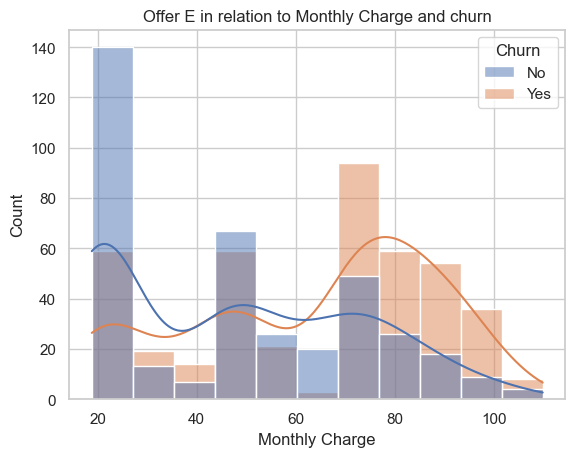

In [22]:
sns.histplot(final_dataset[final_dataset['Offer'] == 'Offer E'], x='Monthly Charge', hue='Churn', kde=True)
plt.title('Offer E in relation to Monthly Charge and churn')

### Plotting Gender in respect to Churn value

Text(0.5, 1.0, 'Gender in relation to Churn')

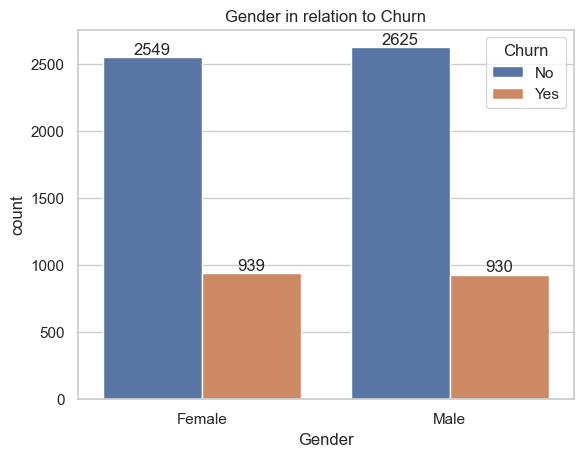

In [21]:

ax = sns.countplot(final_dataset, x='Gender', hue='Churn')
for container in ax.containers:
  ax.bar_label(container)

plt.title('Gender in relation to Churn')

### Boxplot For Offer to Monthly Charges with hue Churn

<Axes: xlabel='Offer', ylabel='Monthly Charges'>

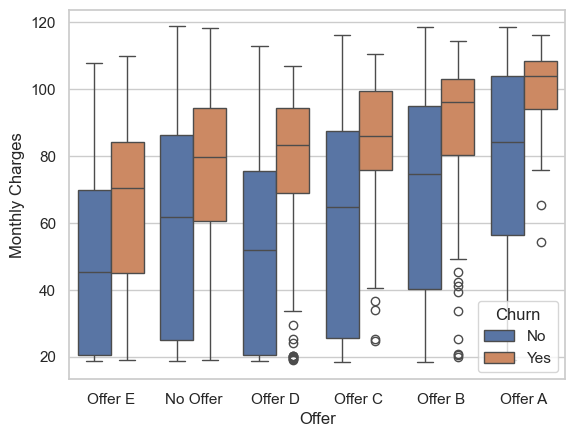

In [190]:
sns.boxplot(final_dataset, x='Offer', y='Monthly Charges', hue='Churn')

### Ploting a joinplot to see where most people leave

In [ ]:
sns.jointplot(data=final_dataset[final_dataset['Churn'] == 'Yes'], x="Longitude", y="Latitude", hue="Churn", kind="kde")

### Plotting numeric columns to find patterns

In [ ]:
dropped_columns = ['Total Refunds', 'Total Extra Data Charges']
for column in final_dataset.select_dtypes('number').drop(columns=dropped_columns).columns:
  print(column)
  # plt.figure(figsize=(10, 10))
  sns.histplot(final_dataset, x=column, 
              hue='Churn', 
              multiple='stack',             
              alpha=0.8)  
  plt.show()

### Plotting the coordination points and checking if there is a pattern of churn value

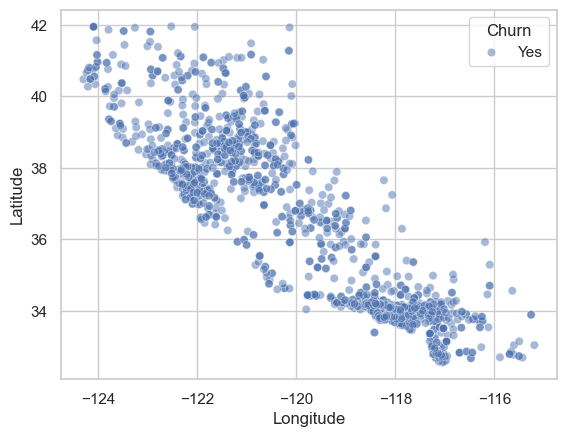

In [72]:
# plt.figure(figsize=(10, 7))
sns.scatterplot(final_dataset[final_dataset['Churn'] == 'Yes'], x='Longitude', y='Latitude', alpha=.5, hue='Churn')
plt.show()

### Plotting cities to find patterns for churn

<Axes: xlabel='City', ylabel='count'>

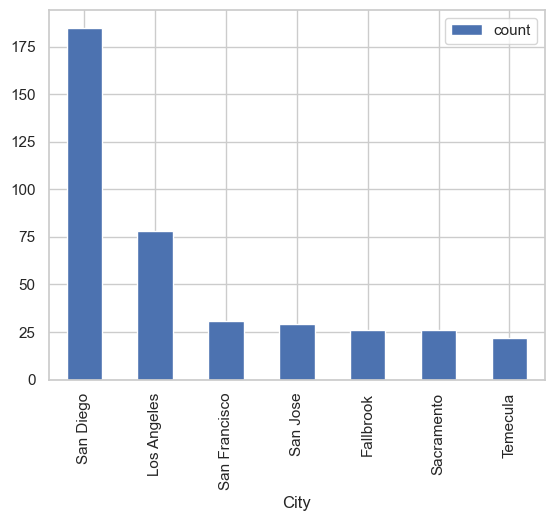

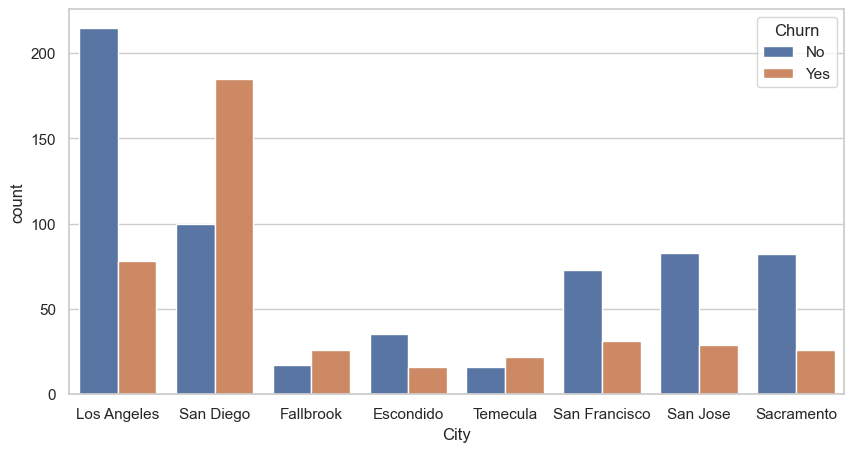

In [110]:
group_by_zip_people = final_dataset.groupby(by='City')['Churn'].count().reset_index()
group_by_zip_churn_type = final_dataset.groupby(by='City')['Churn'].value_counts().reset_index()
group_by_zip_churn_type[group_by_zip_churn_type.Churn == 'Yes'].sort_values(by='count', ascending=False).head(7).plot(kind='bar', x='City', y='count')
cities_with_high_samples = group_by_zip_churn_type[group_by_zip_churn_type.Churn == 'Yes'].sort_values(by='count', ascending=False).head(8)['City'].to_list()
plt.figure(figsize=(10, 5))
sns.countplot(final_dataset[final_dataset['City'].isin(cities_with_high_samples)], x='City', hue='Churn')


### Plotting Number of Dependents

Text(0.5, 1.0, 'Number of Dependents relative Churn')

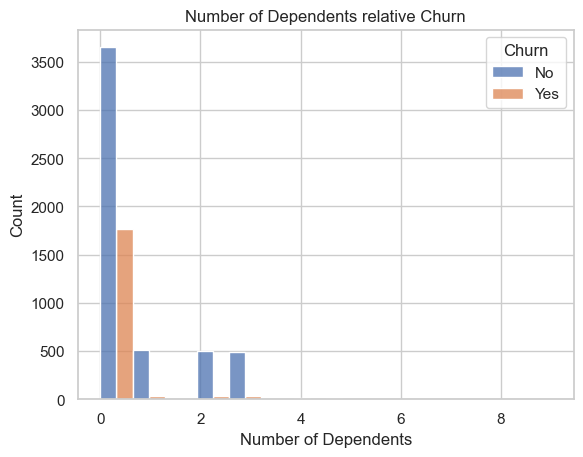

In [18]:
sns.histplot(final_dataset, x='Number of Dependents', hue='Churn', multiple='dodge')
plt.title('Number of Dependents relative Churn')

### Plotting Married Status relative to Churn

Text(0.5, 1.0, 'Married status relative to Churn')

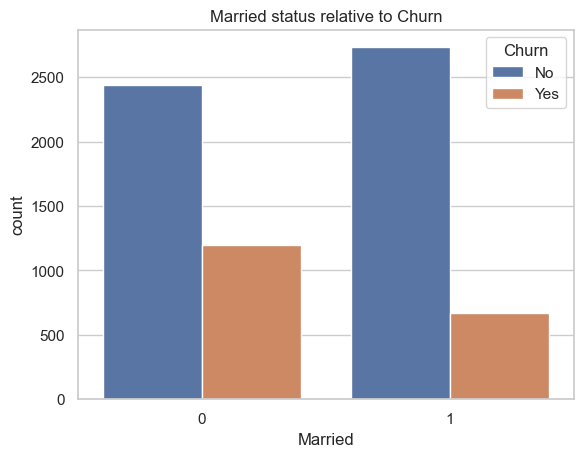

In [420]:
sns.countplot(final_dataset, x='Married', hue='Churn')
plt.title('Married status relative to Churn')

### Plotting Under 30 Status relative to Churn

Text(0.5, 1.0, 'Under 30 status relative to Churn')

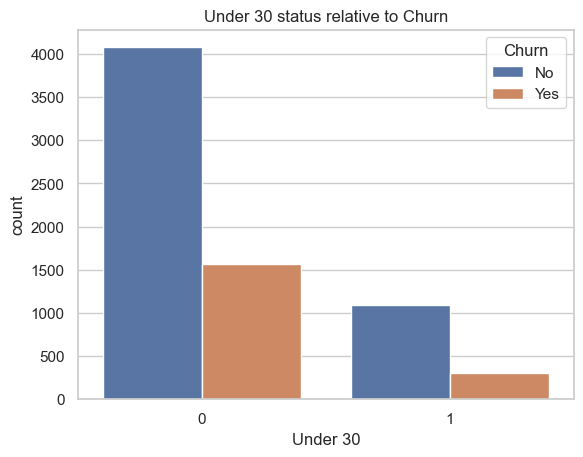

In [19]:
sns.countplot(final_dataset, x='Under 30', hue='Churn')
plt.title('Under 30 status relative to Churn')

### Plotting Internet Type Fiber Optic relative to Churn

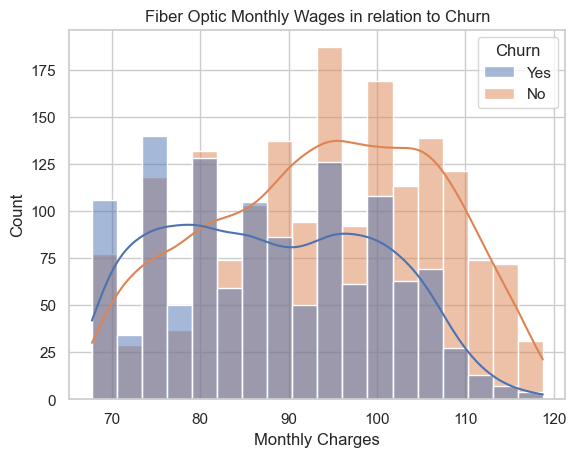

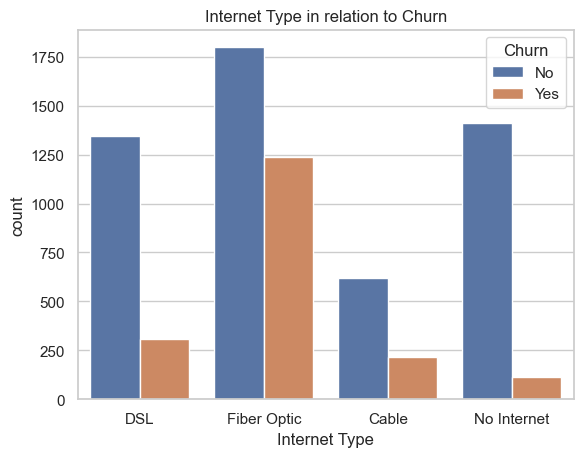

In [23]:
sns.histplot(final_dataset[final_dataset['Internet Type'] == 'Fiber Optic'], x='Monthly Charges', hue='Churn', kde=True)
plt.title('Fiber Optic Monthly Wages in relation to Churn')
plt.show()
sns.countplot(final_dataset, x='Internet Type', hue='Churn')
plt.title('Internet Type in relation to Churn')
plt.show()

Plotting Total Refunds 0 and the rest of the values separately because of change of scale

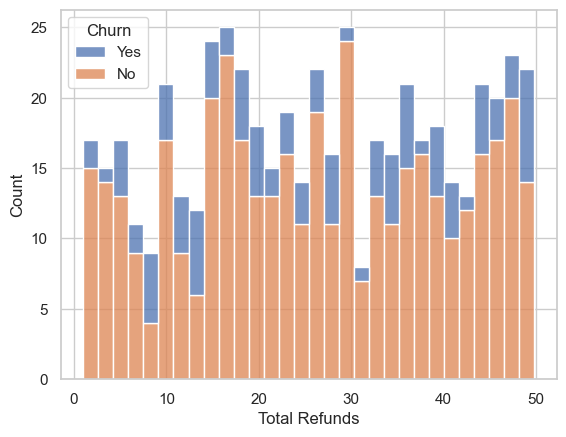

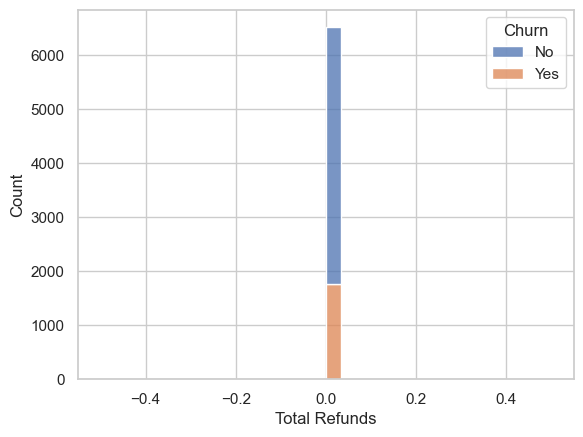

In [122]:
column_to_plot = 'Total Refunds'
sns.histplot(final_dataset[final_dataset[column_to_plot] != 0], x=column_to_plot, bins=30, hue='Churn',  multiple="stack")
plt.show()
print('\n')

sns.histplot(final_dataset[final_dataset[column_to_plot] == 0], x=column_to_plot, bins=30, hue='Churn',  multiple="stack" )
plt.show()
print('\n')

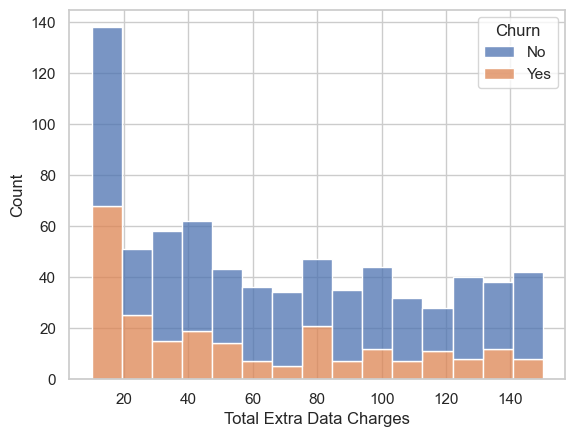

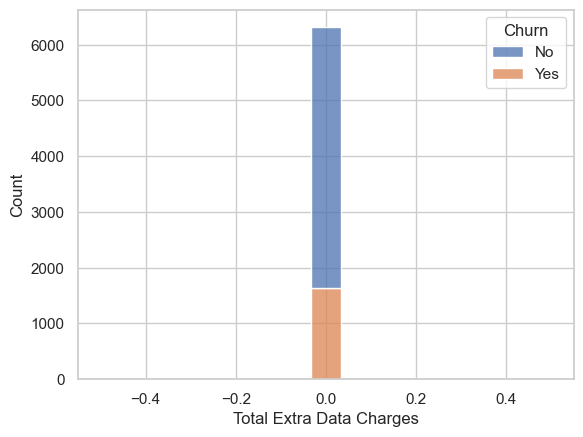

In [123]:
column_to_plot = 'Total Extra Data Charges'
sns.histplot(final_dataset[final_dataset[column_to_plot] != 0], x=column_to_plot, bins=15, hue='Churn',  multiple="stack"  )
plt.show()
print('\n')

sns.histplot(final_dataset[final_dataset[column_to_plot] == 0], x=column_to_plot, bins=15, hue='Churn',  multiple="stack" )
plt.show()
print('\n')

### Plotting Contract type relative to Churn

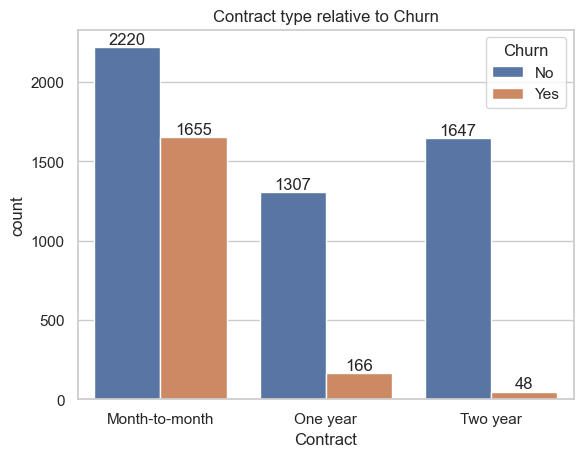

In [29]:
ax = sns.countplot(final_dataset, x='Contract', hue='Churn')
plt.title('Contract type relative to Churn')
for cont in ax.containers:
  ax.bar_label(cont)

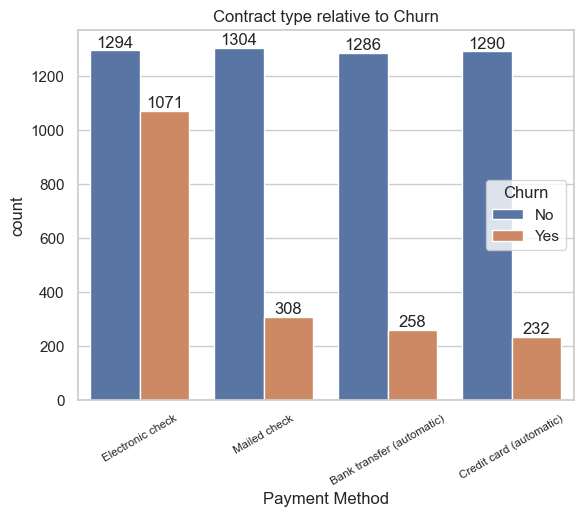

In [32]:
ax = sns.countplot(final_dataset, x='Payment Method', hue='Churn')
plt.title('Contract type relative to Churn')
plt.setp(ax.get_xticklabels(), rotation=30, fontsize='x-small')
for cont in ax.containers:
  ax.bar_label(cont)

## Countplots for Categorical features

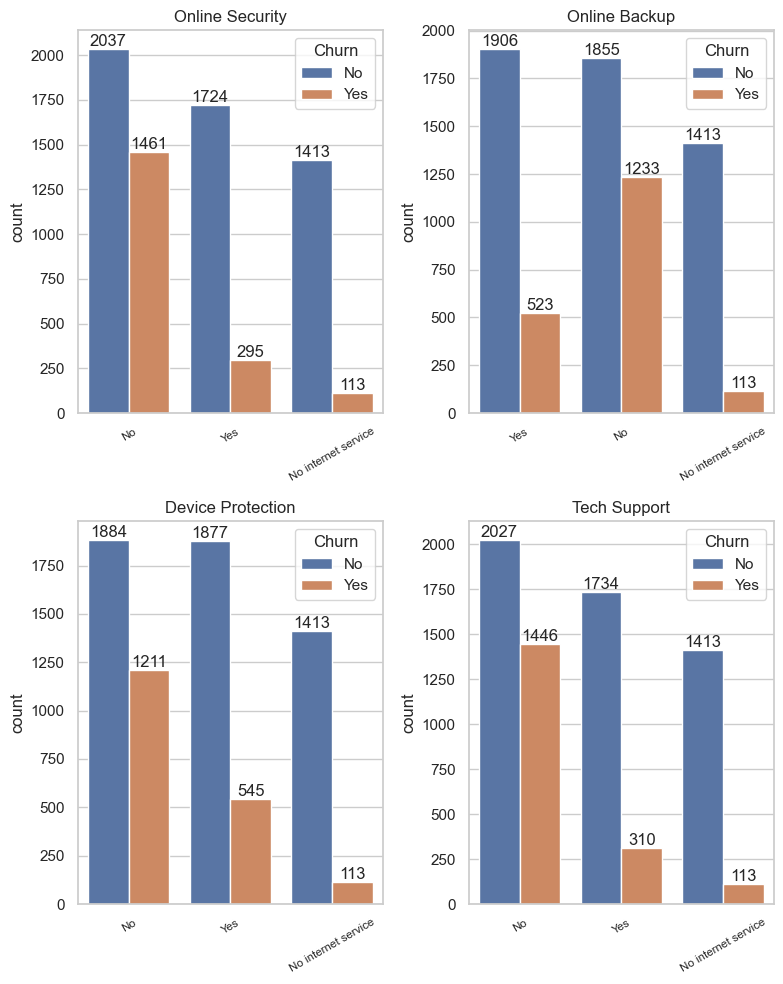

In [41]:
def plotMultiple(df, cols, size, figsize):

  fig, ax = plt.subplots(size[0], size[1], figsize=figsize)

  x=0
  y=0
  for col in cols:

    if col == 'Churn':
      continue        
    sns.countplot(df, x=col, hue='Churn', ax=ax[x,y]).set(title=col, xlabel=None)
    plt.setp(ax[x, y].get_xticklabels(), rotation=30, fontsize='x-small')
    for cont in ax[x, y].containers:
      ax[x, y].bar_label(cont)

    y += 1
    

    # move to new line of axes
    if y == size[1]:
      y = 0
      x += 1

  

  plt.tight_layout()
  plt.show()

final_df_objects = final_dataset.select_dtypes('object').drop(columns='City')
final_df_objects
plotMultiple(final_df_objects, final_df_objects.columns[:9], (3, 3), (12, 12))
plotMultiple(final_df_objects, final_df_objects.columns[9:], (2, 2), (10, 10))
columns = ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Churn']
plotMultiple(final_df_objects[columns], final_df_objects[columns], (2, 2), (8, 10))


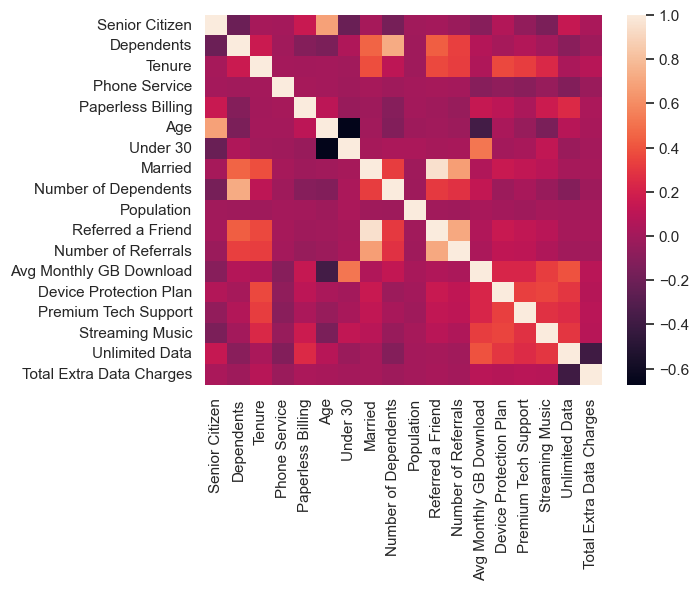

In [9]:
sns.heatmap(final_dataset.select_dtypes(include=[int]).corr())
plt.show()

## Create Heatmaps with categorical features and the class column

This has the same output as the countplots it is an alternative view of the same data

In [ ]:
def createHeatmaps(df):
  for col in df.select_dtypes('object'):
    if col not in ['Churn', 'City']:
      dft = pd.crosstab(df["Churn"], df[col]).apply(func=lambda x : x / 7043 * 100).round(0)
      ax = sns.heatmap(dft, annot=True, fmt=".0f", cmap='coolwarm')
      for t in ax.texts: t.set_text(t.get_text() + "%")
      plt.show()
      print("\n")

createHeatmaps(final_dataset)

## One Hot Encoding of categorical columns

Dropping Columns that will not be needed for for the machine learning algorithms

In [5]:
duplicate_not_needed_columns = ['Zip Code', 'Monthly Charge', 'Internet Service', 'Partner', 'Tenure in Months']
final_dataset = final_dataset.drop(columns=duplicate_not_needed_columns, errors='ignore')

In [6]:
def onehot_enc(df):
  for col in df.columns:
    if df[col].dtype == object and col not in ['Churn', 'City', 'Monthly Charges Cat']:
      onehot = OneHotEncoder(sparse_output=False, drop='if_binary')
      onehot.fit(df[[col]])
      OH_cols_train = pd.DataFrame(onehot.transform(df[[col]]),
                                   columns=onehot.get_feature_names_out(),
                                   index=df.index)
      droped_cols = df.drop(columns=col, axis=1)
      df = pd.concat([droped_cols, OH_cols_train], axis=1)
  return df

def onehot_cities(df):
  column = 'City'
  onehot = OneHotEncoder(sparse_output=False)
  onehot.fit(df[[column]])
  OH_cols_train = pd.DataFrame(onehot.transform(df[[column]]),
                                columns=onehot.get_feature_names_out(),
                                index=df.index)
  droped_cols = df.drop(columns=[column], axis=1)
  df = pd.concat([droped_cols, OH_cols_train[['City_Los Angeles', 'City_San Diego']]], axis=1)
  return df



final_dataset_oh = onehot_enc(final_dataset)
final_dataset_oh = onehot_cities(final_dataset_oh)

# Removing Similar Columns to reduce multi collinearity 
dup_cols = ['Monthly Charges', 'Online Security_No internet service', 'Tech Support_No internet service', 
            'Streaming Movies_No internet service', 'Online Backup_No internet service', 
            'Device Protection_No internet service']
final_dataset_oh.drop(columns=dup_cols, inplace=True)

y = final_dataset['Churn'].map({'No': False, 'Yes': True})
y.astype(np.bool)
X = final_dataset_oh
X.drop(columns=['Churn'], inplace=True)
X.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 62 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Senior Citizen                            7043 non-null   int64  
 1   Dependents                                7043 non-null   int64  
 2   Tenure                                    7043 non-null   int64  
 3   Phone Service                             7043 non-null   int64  
 4   Paperless Billing                         7043 non-null   int64  
 5   Age                                       7043 non-null   int64  
 6   Under 30                                  7043 non-null   int64  
 7   Married                                   7043 non-null   int64  
 8   Number of Dependents                      7043 non-null   int64  
 9   Latitude                                  7043 non-null   float64
 10  Longitude                 

## Target Class Percentages

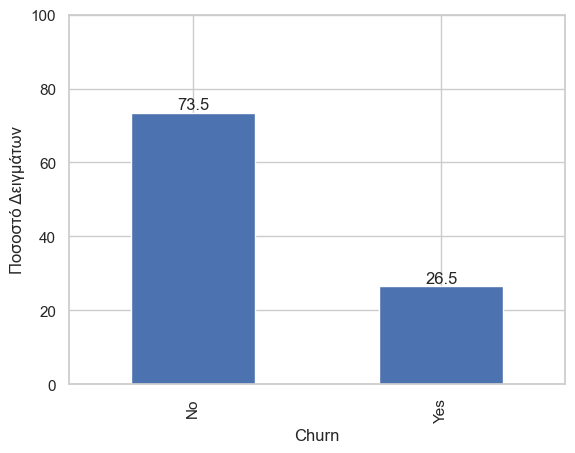

Churn
No     73.5
Yes    26.5
Name: count, dtype: float64


In [24]:
agro = final_dataset['Churn'].value_counts().map(lambda x: round(x/7043, 3) * 100)
ax = agro.plot(kind='bar')
for cnt in ax.containers:  
  ax.bar_label(cnt)
plt.ylim(.0, 100)
plt.ylabel('Ποσοστό Δειγμάτων')
plt.show()
print(agro)

# Train test split final dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

# Scaling data for specific models

In [8]:

scale_columns = ['Tenure', 'Population', 'Population Percentage', 'Number of Referrals', 'Avg Monthly Long Distance Charges',
                 'Avg Monthly GB Download', 'Total Charges', 'Age', 'Number of Dependents', 'Total Long Distance Charges',
                 'Total Revenue', 'Total Refunds', 'Total Extra Data Charges']

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

scaler = StandardScaler()
X_train_norm[scale_columns] = scaler.fit_transform(X_train[scale_columns])
X_test_norm[scale_columns] = scaler.transform(X_test[scale_columns])

# Utility Functions

### Plotting Confusion Matrix

In [9]:
def plot_confusion_matrix(model, X, y):
  titles_options = [
      ("Confusion matrix, without normalization", None),
      ("Normalized confusion matrix", "true"),
  ]
  for title, normalize in titles_options:
      disp = ConfusionMatrixDisplay.from_estimator(
          model,
          X,
          y,
          display_labels=y.unique(),
          cmap=plt.cm.Blues,
          normalize=normalize,
      )
      disp.ax_.set_title(title)

      print(title)
      print(disp.confusion_matrix)

      plt.show()
      print("\n")



In [10]:
def show_metrics(estimator, x_test):
  # print(f'Best parameters for estimator: {search_cv.best_params_}')  
  y_pred = estimator.predict(x_test)

  print("Perfomance:")
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("Classification Report:")
  print(classification_report(y_test, y_pred, zero_division=0.0))
  print("ROC AUC Score:")
  try:
    print(roc_auc_score(y_test, estimator.predict_proba(x_test)[:, 1]))
  except:
    metrics.RocCurveDisplay.from_estimator(estimator, x_test, y_test)

  print("\n")

  # Plot confusion matrix
  plot_confusion_matrix(estimator, x_test, y_test)

  # Plot ROC Curve
  metrics.RocCurveDisplay.from_estimator(estimator, x_test, y_test)


### Collecting classifiers to lists according to scaling

In [11]:
random_state=42
def get_classifiers():
  clf_names = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'AdaBoost', 'Naive Bayes', 'K-Nearest Neighbor', 'Stochastic Gradient Descent', 'Logistic Regression']
  clf_models = [DecisionTreeClassifier(random_state=random_state), RandomForestClassifier(random_state=random_state), GradientBoostingClassifier(random_state=random_state),
                XGBClassifier(enable_categorical=True, tree_method="hist", eval_metric='logloss', early_stopping_rounds=2, random_state=2, booster='gbtree'), AdaBoostClassifier(algorithm='SAMME', random_state=random_state),
                GaussianNB(), KNeighborsClassifier(), SGDClassifier(random_state=random_state, loss='log_loss'), LogisticRegression(penalty="l2", solver="liblinear", random_state=random_state)]
  return dict(zip(clf_names, clf_models))

# Evaluating Default Models Without Feature Selection

### Training models

In [12]:
starting_estimators = get_classifiers()

# Train models 
for name, model in starting_estimators.items():
  print('Training ' + name)
  if name == 'XGBoost':
    start = time()
    model.fit(X_train_norm, y_train, eval_set=[(X_test_norm, y_test)])
  else:
    start = time()
    model.fit(X_train_norm, y_train)
  print('Time to fit %.2f' % (time() - start))

Training Decision Tree
Time to fit 0.12
Training Random Forest
Time to fit 1.42
Training Gradient Boosting
Time to fit 3.55
Training XGBoost
[0]	validation_0-logloss:0.49169
[1]	validation_0-logloss:0.44106
[2]	validation_0-logloss:0.41046
[3]	validation_0-logloss:0.38705
[4]	validation_0-logloss:0.37113
[5]	validation_0-logloss:0.36277
[6]	validation_0-logloss:0.35739
[7]	validation_0-logloss:0.34853
[8]	validation_0-logloss:0.34409
[9]	validation_0-logloss:0.34088
[10]	validation_0-logloss:0.34179
[11]	validation_0-logloss:0.33892
[12]	validation_0-logloss:0.33874
[13]	validation_0-logloss:0.33849
[14]	validation_0-logloss:0.33791
[15]	validation_0-logloss:0.33714
[16]	validation_0-logloss:0.33564
[17]	validation_0-logloss:0.33541
[18]	validation_0-logloss:0.33733
Time to fit 0.59
Training AdaBoost
Time to fit 0.79
Training Naive Bayes
Time to fit 0.02
Training K-Nearest Neighbor
Time to fit 0.01
Training Stochastic Gradient Descent
Time to fit 0.26
Training Logistic Regression
Time 

### Predicting and calculating metrics

Predicting:  Decision Tree
Predicting:  Random Forest
Predicting:  Gradient Boosting
Predicting:  XGBoost
Predicting:  AdaBoost
Predicting:  Naive Bayes
Predicting:  K-Nearest Neighbor
Predicting:  Stochastic Gradient Descent
Predicting:  Logistic Regression


Accuracy  f1-score  roc_auc_score
Decision Tree                0.767211  0.568421       0.706644
Random Forest                0.816891  0.612613       0.887069
Gradient Boosting            0.842441  0.678261       0.910091
XGBoost                      0.831796  0.666667       0.903781
AdaBoost                     0.829666  0.659091       0.894455
Naive Bayes                  0.782825  0.670968       0.869406
K-Nearest Neighbor           0.765791  0.554054       0.798095
Stochastic Gradient Descent  0.826118  0.700122       0.880855
Logistic Regression          0.828247  0.659155       0.894162

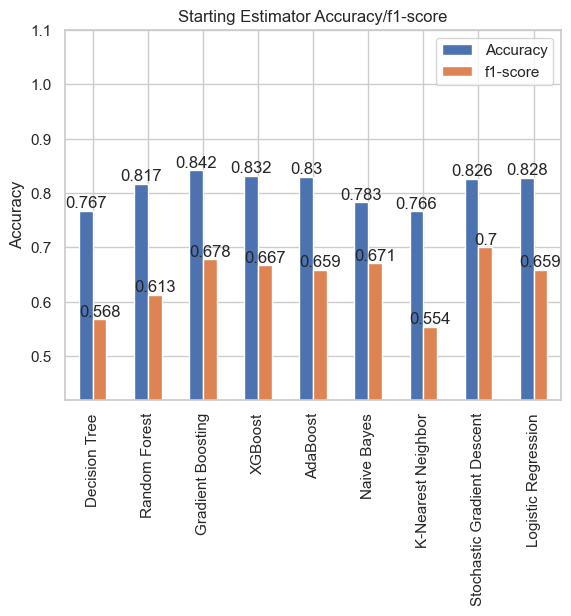

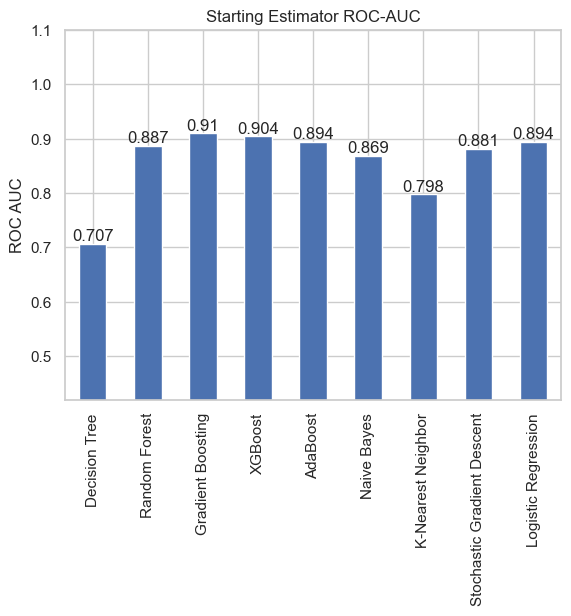

In [14]:
df_scores = pd.DataFrame(columns=['Accuracy', 'f1-score', 'roc_auc_score'])
starting_accuracy=0
starting_f1_score=0 
starting_roc_auc=0
for name, model in starting_estimators.items():
  print('Predicting: ', name)
  y_pred = model.predict(X_test_norm)
  if name == 'XGBoost':    
    starting_accuracy = accuracy_score(y_test, y_pred)
    starting_f1_score = f1_score(y_test, y_pred)
    starting_roc_auc = roc_auc_score(y_test==1, model.predict_proba(X_test_norm)[:, 1])
  else:    
    starting_accuracy = accuracy_score(y_test, y_pred)
    starting_f1_score = f1_score(y_test, y_pred, pos_label=1)
    starting_roc_auc = roc_auc_score(y_test==1, model.predict_proba(X_test_norm)[:, 1])
  df_scores.loc[name] = {'Accuracy': starting_accuracy, 'f1-score': starting_f1_score, 'roc_auc_score': starting_roc_auc}
  # Needs probabilities for correct calculation
  # print(f'{name} {roc_auc_score(y_test, y_pred=="Yes")}')

display(df_scores)

# Plotting Scores
ax = df_scores[['Accuracy', 'f1-score']].apply(lambda x : round(x, 3)).plot.bar()
plt.ylim((0.42, 1.1))
plt.title("Starting Estimator Accuracy/f1-score")
plt.ylabel('Accuracy')
for container in ax.containers:
  ax.bar_label(container)
plt.show()

ax = df_scores.apply(lambda x : round(x, 3))['roc_auc_score'].plot.bar()
plt.ylim((0.42, 1.1))
plt.title("Starting Estimator ROC-AUC")
plt.ylabel('ROC AUC')
for container in ax.containers:
  ax.bar_label(container)




# Evaluating Model with SelectKBest Feature Selection method

### Utility Functions

In [15]:
def plot_cv_results(gscv):
  cv_results = pd.DataFrame(gscv.cv_results_)
  len(cv_results.mean_test_score)
  cv_results
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Mean test accuracy")
  # plt.xticks(range(1, gscv.n_features_in_ + 1, 1))
  plt.errorbar(
      x=cv_results.index + 1,
      y=cv_results.mean_test_score,
      yerr=cv_results.std_test_score
  )
  plt.show()

Initializing dictionary to hold values

In [16]:
f1_scorer = make_scorer(f1_score, pos_label=1)
kbest_accuracy = {}
kbest_f1_score = {}
kbest_k = {}
kbest_metrics = pd.DataFrame(columns=['k-best accuracy', 'k-best f1-score', 'k-best roc_auc_score', 'bestk'])

## Train models together

### Train Models

GridSearch for KBest Decision Tree


Time to search Decision Tree: 8.920585870742798
Best k features for Decision Tree: {'selectkbest__k': 38}


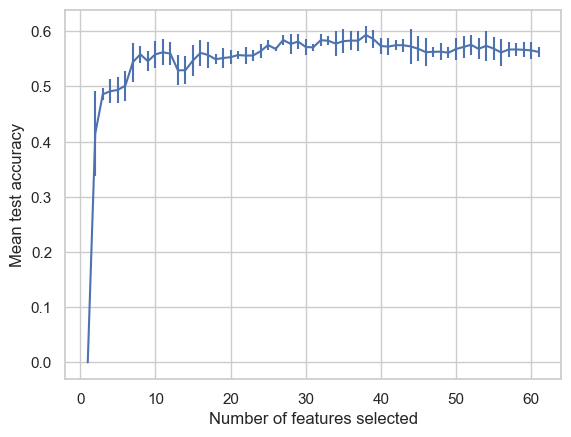

Perfomance:
Accuracy: 0.7721788502484032
Classification Report:
              precision    recall  f1-score   support

       False       0.85      0.84      0.84      1035
        True       0.57      0.57      0.57       374

    accuracy                           0.77      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409

ROC AUC Score:
0.7083184789067142


Confusion matrix, without normalization
[[874 161]
 [160 214]]


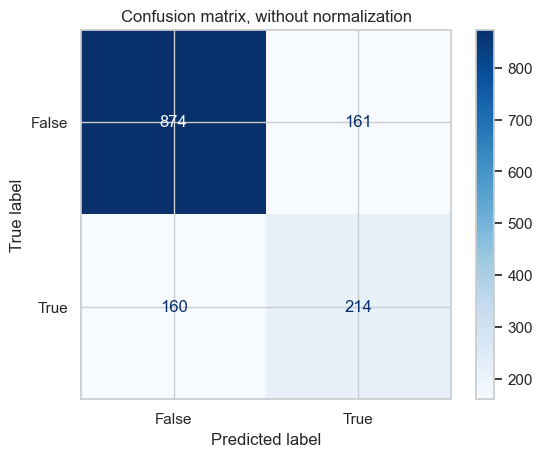



Normalized confusion matrix
[[0.84444444 0.15555556]
 [0.42780749 0.57219251]]


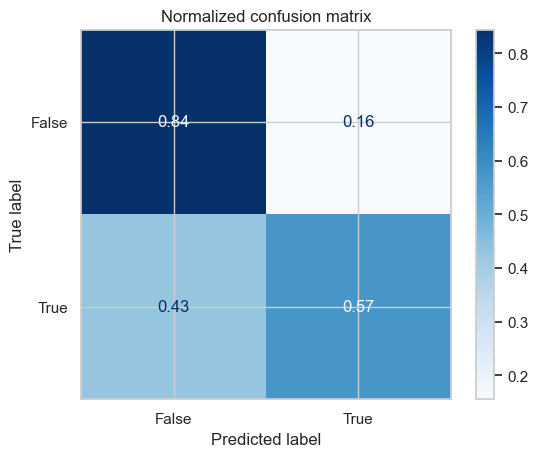



GridSearch for KBest Random Forest
Time to search Random Forest: 89.1654908657074
Best k features for Random Forest: {'selectkbest__k': 54}


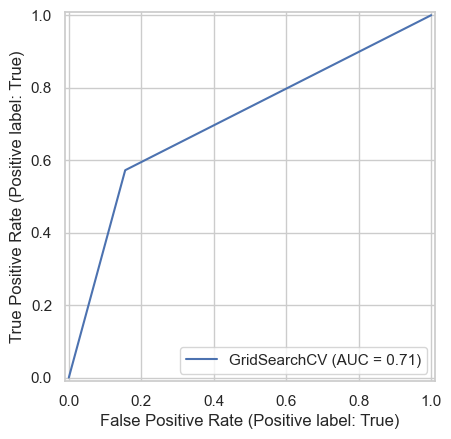

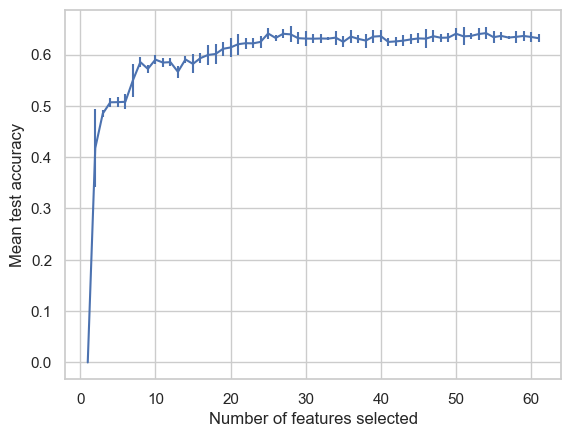

Perfomance:
Accuracy: 0.8218594748048261
Classification Report:
              precision    recall  f1-score   support

       False       0.85      0.92      0.88      1035
        True       0.71      0.55      0.62       374

    accuracy                           0.82      1409
   macro avg       0.78      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409

ROC AUC Score:
0.8855201632695239


Confusion matrix, without normalization
[[951  84]
 [167 207]]


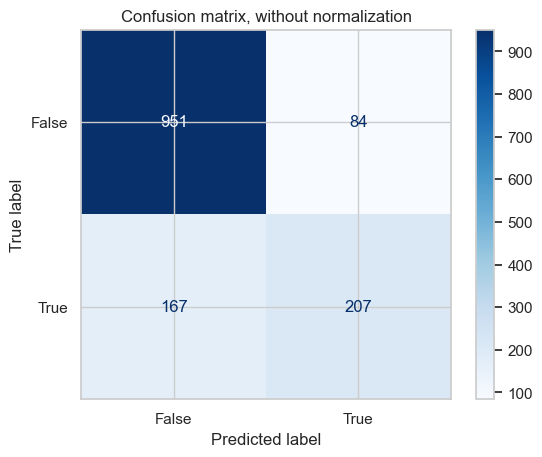



Normalized confusion matrix
[[0.91884058 0.08115942]
 [0.44652406 0.55347594]]


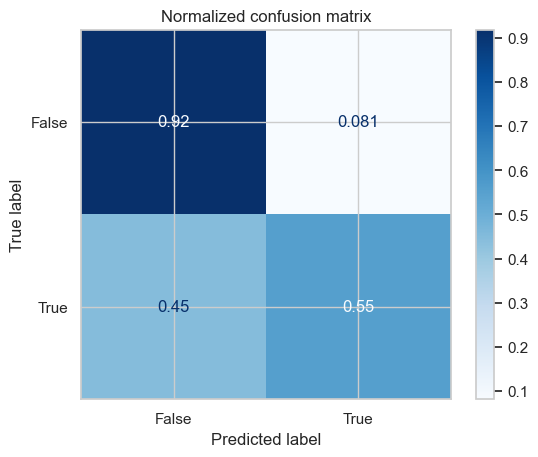



GridSearch for KBest Gradient Boosting
Time to search Gradient Boosting: 122.16726446151733
Best k features for Gradient Boosting: {'selectkbest__k': 58}


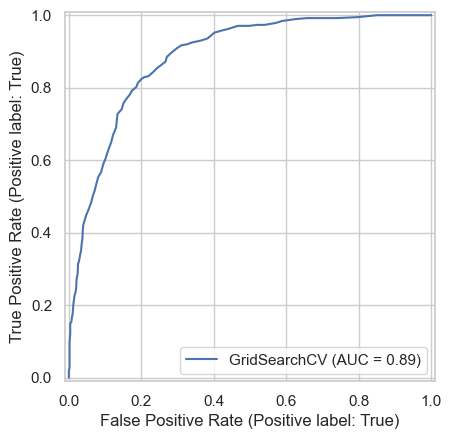

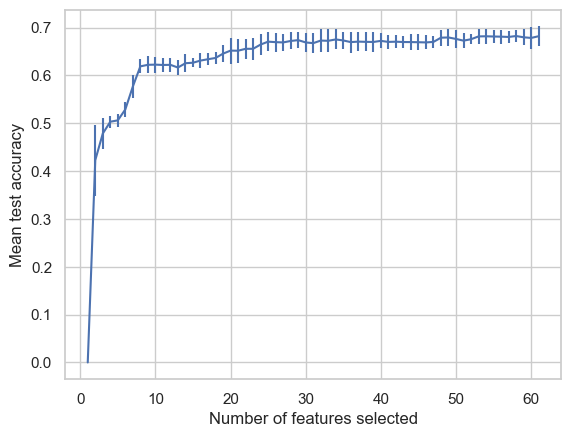

Perfomance:
Accuracy: 0.8396025550035486
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.92      0.89      1035
        True       0.73      0.62      0.67       374

    accuracy                           0.84      1409
   macro avg       0.80      0.77      0.78      1409
weighted avg       0.83      0.84      0.84      1409

ROC AUC Score:
0.9095107081040583


Confusion matrix, without normalization
[[951  84]
 [142 232]]


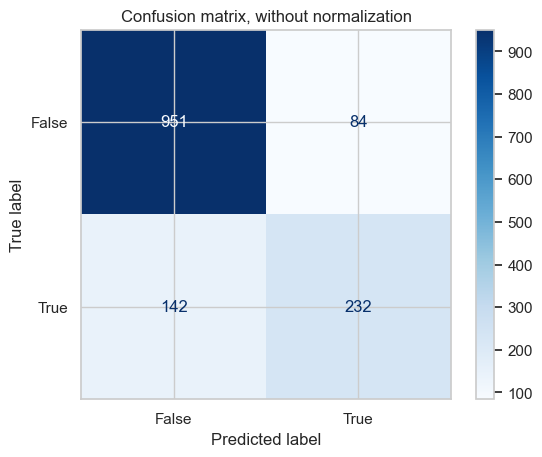



Normalized confusion matrix
[[0.91884058 0.08115942]
 [0.37967914 0.62032086]]


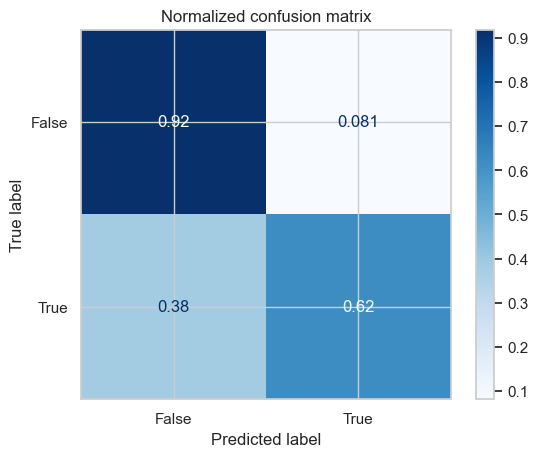



GridSearch for KBest XGBoost
Time to search XGBoost: 22.832113027572632
Best k features for XGBoost: {'selectkbest__k': 57, 'xgbclassifier__early_stopping_rounds': 0}


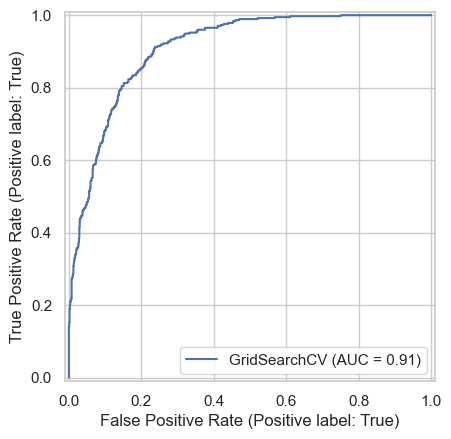

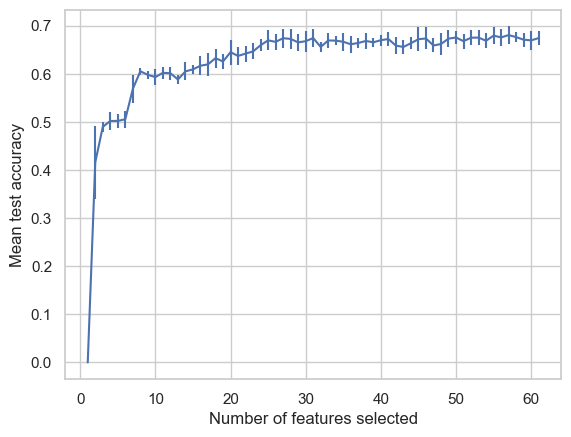

Perfomance:
Accuracy: 0.8289567068843151
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.90      0.89      1035
        True       0.69      0.64      0.66       374

    accuracy                           0.83      1409
   macro avg       0.78      0.77      0.77      1409
weighted avg       0.83      0.83      0.83      1409

ROC AUC Score:
0.8986824769433466


Confusion matrix, without normalization
[[930 105]
 [136 238]]


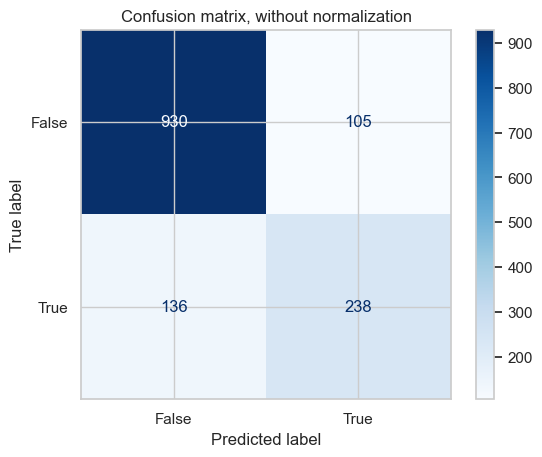



Normalized confusion matrix
[[0.89855072 0.10144928]
 [0.36363636 0.63636364]]


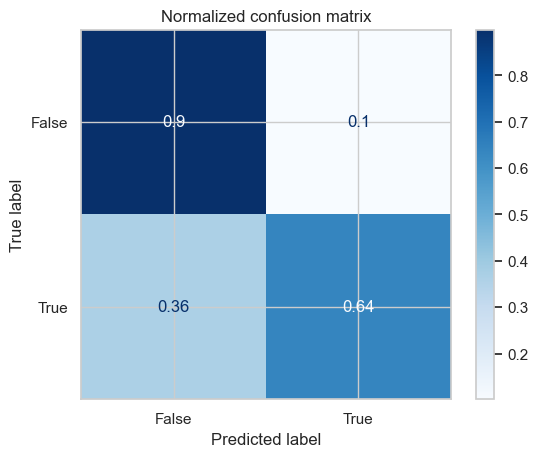



GridSearch for KBest AdaBoost
Time to search AdaBoost: 37.689709186553955
Best k features for AdaBoost: {'selectkbest__k': 60}


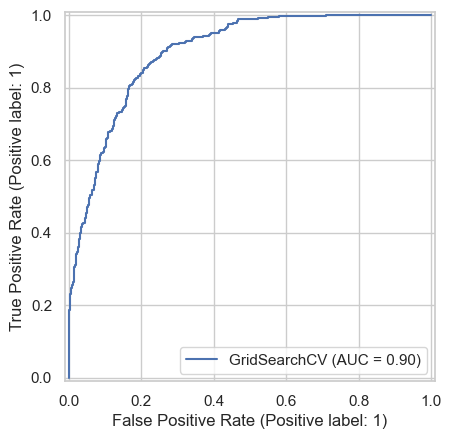

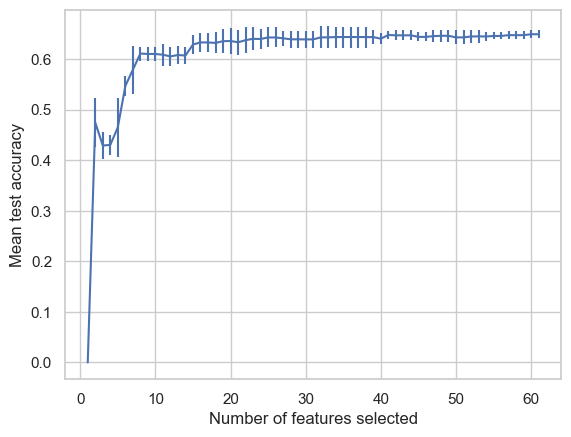

Perfomance:
Accuracy: 0.829666430092264
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.91      0.89      1035
        True       0.70      0.62      0.66       374

    accuracy                           0.83      1409
   macro avg       0.79      0.76      0.77      1409
weighted avg       0.82      0.83      0.83      1409

ROC AUC Score:
0.8944547779586143


Confusion matrix, without normalization
[[937  98]
 [142 232]]


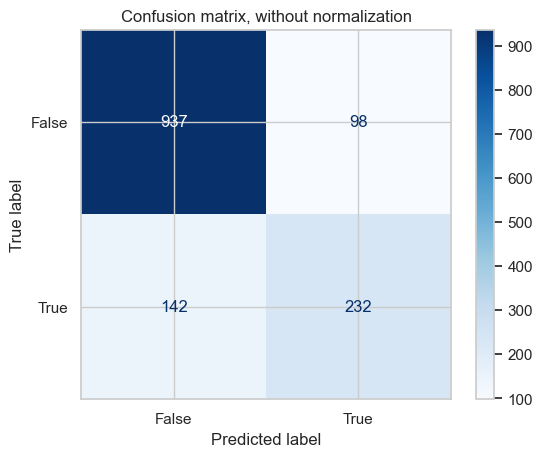



Normalized confusion matrix
[[0.90531401 0.09468599]
 [0.37967914 0.62032086]]


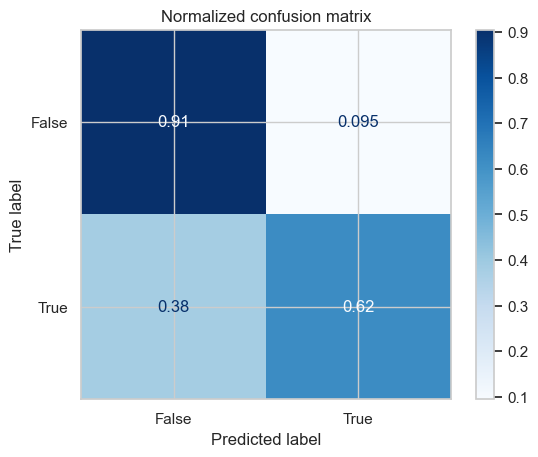



GridSearch for KBest Naive Bayes
Time to search Naive Bayes: 4.873926162719727
Best k features for Naive Bayes: {'selectkbest__k': 54}


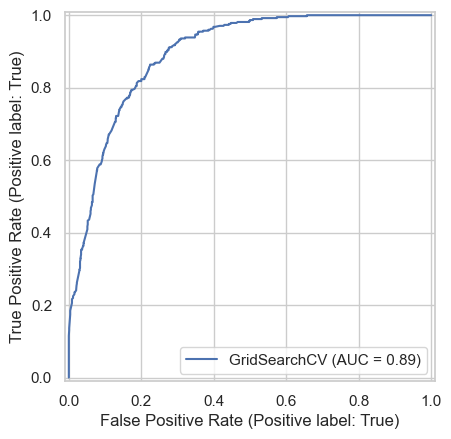

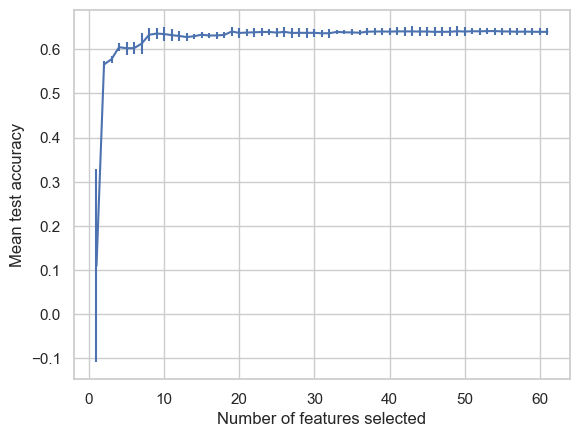

Perfomance:
Accuracy: 0.7821149751596878
Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.76      0.84      1035
        True       0.56      0.83      0.67       374

    accuracy                           0.78      1409
   macro avg       0.74      0.80      0.75      1409
weighted avg       0.83      0.78      0.79      1409

ROC AUC Score:
0.8693120462941436


Confusion matrix, without normalization
[[790 245]
 [ 62 312]]


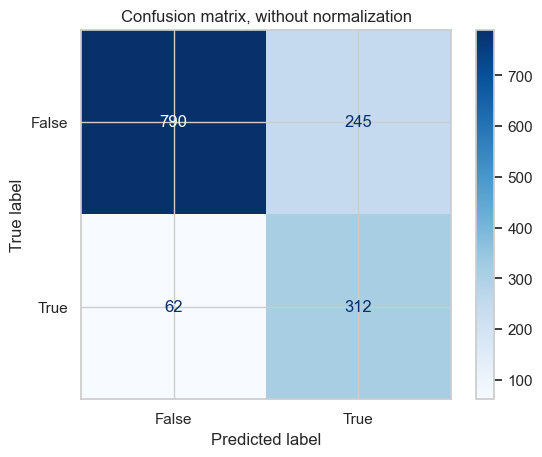



Normalized confusion matrix
[[0.76328502 0.23671498]
 [0.1657754  0.8342246 ]]


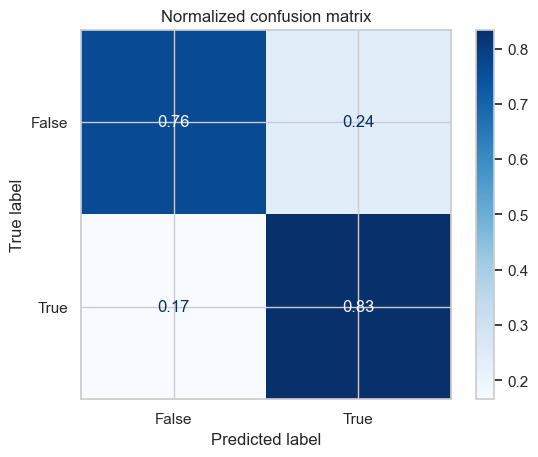



GridSearch for KBest K-Nearest Neighbor
Time to search K-Nearest Neighbor: 11.411332607269287
Best k features for K-Nearest Neighbor: {'selectkbest__k': 50}


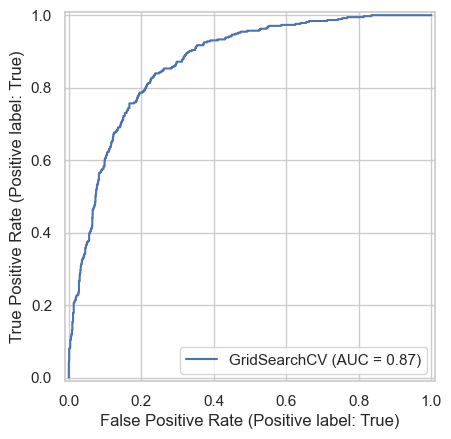

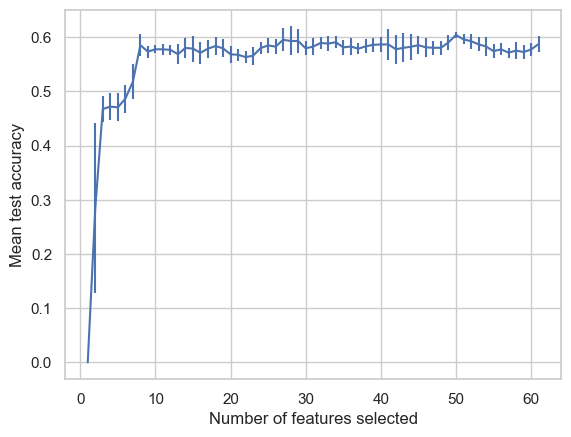

Perfomance:
Accuracy: 0.7835344215755855
Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.86      0.85      1035
        True       0.60      0.56      0.58       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.72      1409
weighted avg       0.78      0.78      0.78      1409

ROC AUC Score:
0.8227156475238318


Confusion matrix, without normalization
[[895 140]
 [165 209]]


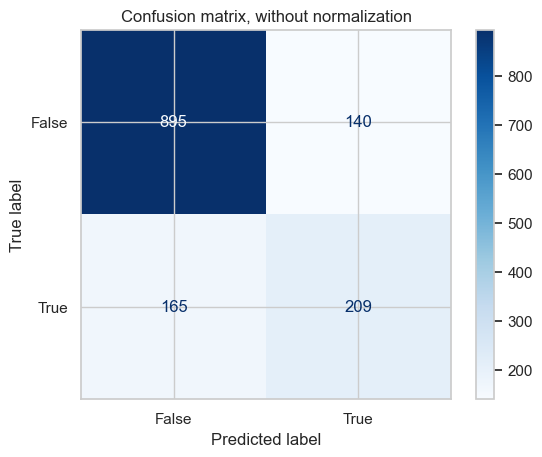



Normalized confusion matrix
[[0.8647343  0.1352657 ]
 [0.44117647 0.55882353]]


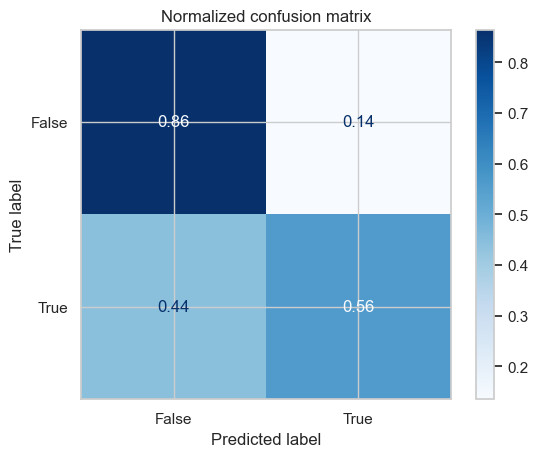



GridSearch for KBest Stochastic Gradient Descent
Time to search Stochastic Gradient Descent: 11.121981859207153
Best k features for Stochastic Gradient Descent: {'selectkbest__k': 52}


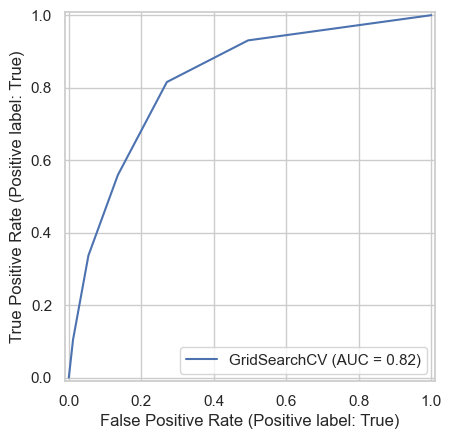

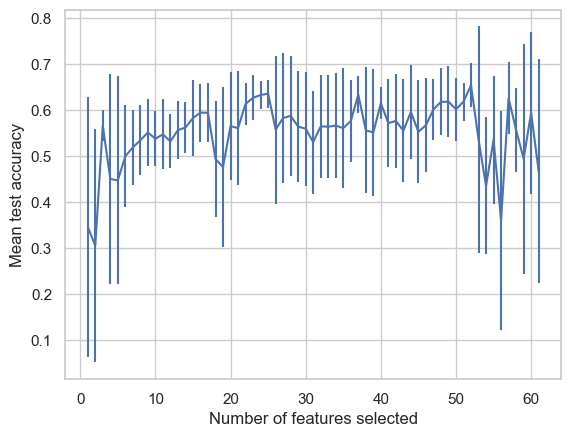

Perfomance:
Accuracy: 0.37189496096522356
Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.14      0.25      1035
        True       0.30      1.00      0.46       374

    accuracy                           0.37      1409
   macro avg       0.65      0.57      0.36      1409
weighted avg       0.81      0.37      0.31      1409

ROC AUC Score:
0.880758996615774


Confusion matrix, without normalization
[[150 885]
 [  0 374]]


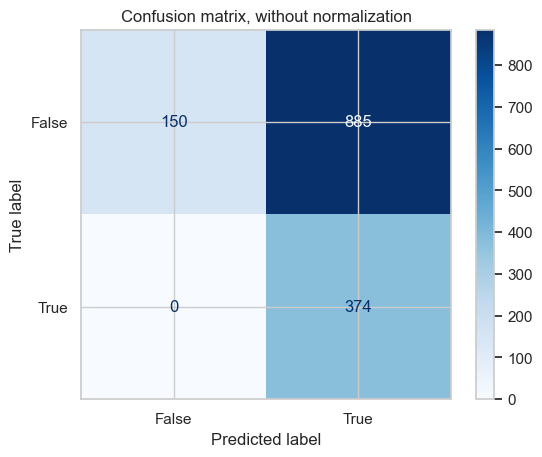



Normalized confusion matrix
[[0.14492754 0.85507246]
 [0.         1.        ]]


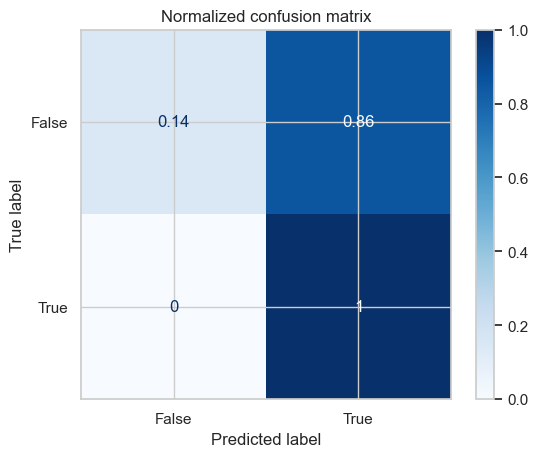



GridSearch for KBest Logistic Regression
Time to search Logistic Regression: 7.574962139129639
Best k features for Logistic Regression: {'selectkbest__k': 29}


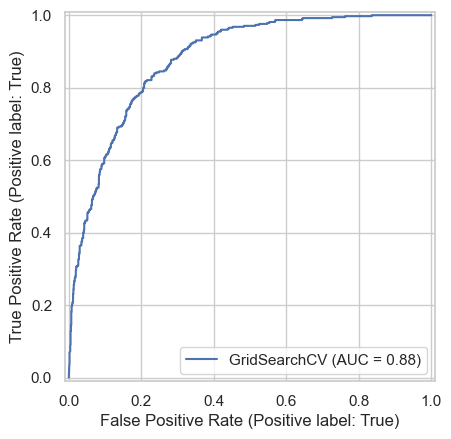

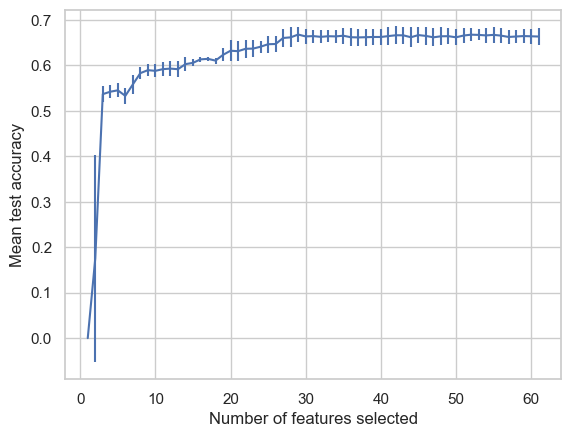

Perfomance:
Accuracy: 0.8289567068843151
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.90      0.89      1035
        True       0.70      0.63      0.66       374

    accuracy                           0.83      1409
   macro avg       0.78      0.76      0.77      1409
weighted avg       0.82      0.83      0.83      1409

ROC AUC Score:
0.8962463509778088


Confusion matrix, without normalization
[[934 101]
 [140 234]]


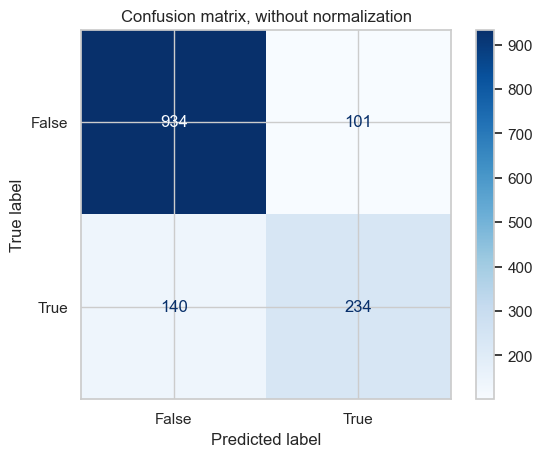



Normalized confusion matrix
[[0.90241546 0.09758454]
 [0.37433155 0.62566845]]


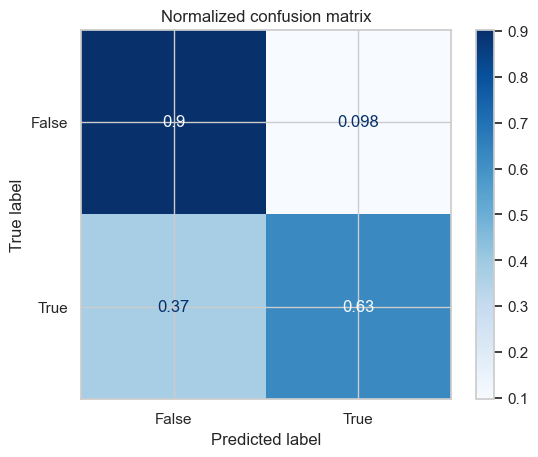

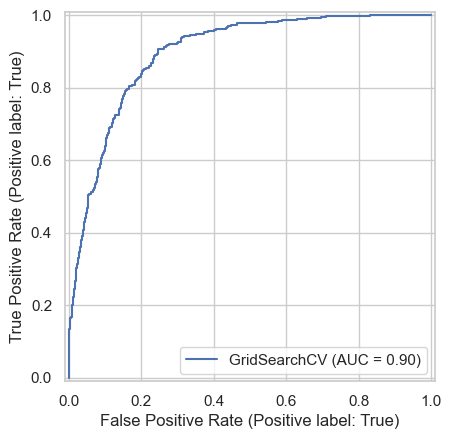

In [18]:
kbest_test_estimators = get_classifiers()
grids_cv = {}

for name, estimator in kbest_test_estimators.items():
  print(f'GridSearch for KBest {name}')
  param_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
  }

  # Create Pipeline with SelectKBest and Model 
  estimator_pipeline = make_pipeline(SelectKBest(score_func=f_classif), estimator)  

  cv = StratifiedKFold(5)
  gscv_kbest = GridSearchCV(estimator_pipeline, param_grid=param_grid, cv=cv, n_jobs=-1, scoring=f1_scorer)

  # Run GridSearchCV
  start = time()
  if name == 'XGBoost':
    param_grid2 = {
      'selectkbest__k' : range(1, X_train.shape[1]),
      'xgbclassifier__early_stopping_rounds' : [0]
    }
    gscv_kbest = GridSearchCV(estimator_pipeline, param_grid=param_grid2, cv=cv, n_jobs=-1, scoring=f1_scorer)
    gscv_kbest.fit(X_train_norm, y_train)
  else:  
    gscv_kbest.fit(X_train_norm, y_train)
    
  print(f'Time to search {name}: {time() - start}', )
  print(f"Best k features for {name}: {gscv_kbest.best_params_}")

  # Plot CV results
  plot_cv_results(gscv_kbest)

  # Show Metrics
  show_metrics(gscv_kbest, X_test_norm)

  # Collect Metrics
  kbest_metrics.loc[name] = {'k-best accuracy': accuracy_score(y_test, gscv_kbest.predict(X_test_norm)),
                             'k-best f1-score': f1_score(y_test, gscv_kbest.predict(X_test_norm), pos_label=1),
                             'k-best roc_auc_score': roc_auc_score(y_test, gscv_kbest.predict_proba(X_test_norm)[:, 1]),
                             'bestk': gscv_kbest.best_params_['selectkbest__k']}
  
  grids_cv[name] = gscv_kbest

  

### Visualize and plot all metrics for kbest models

In [447]:
display(kbest_metrics.sort_values(by='k-best f1-score', ascending=False))
display(kbest_metrics.sort_values(by='k-best roc_auc_score', ascending=False))

k-best accuracy  k-best f1-score  \
Gradient Boosting                   0.839603         0.672464   
Naive Bayes                         0.782115         0.670247   
XGBoost                             0.828957         0.663877   
Logistic Regression                 0.828957         0.660085   
AdaBoost                            0.829666         0.659091   
Random Forest                       0.821859         0.622556   
K-Nearest Neighbor                  0.783534         0.578147   
Decision Tree                       0.772179         0.571429   
Stochastic Gradient Descent         0.371895         0.458053   

                             k-best roc_auc_score  bestk  
Gradient Boosting                        0.909511     58  
Naive Bayes                              0.869312     54  
XGBoost                                  0.898682     57  
Logistic Regression                      0.896246     29  
AdaBoost                                 0.894455     60  
Random Forest                            0.885520     54  
K-Nearest Neighbor                       0.822716     50  
Decision Tree                            0.708318     38  
Stochastic Gradient Descent              0.880759     52

k-best accuracy  k-best f1-score  \
Gradient Boosting                   0.839603         0.672464   
XGBoost                             0.828957         0.663877   
Logistic Regression                 0.828957         0.660085   
AdaBoost                            0.829666         0.659091   
Random Forest                       0.821859         0.622556   
Stochastic Gradient Descent         0.371895         0.458053   
Naive Bayes                         0.782115         0.670247   
K-Nearest Neighbor                  0.783534         0.578147   
Decision Tree                       0.772179         0.571429   

                             k-best roc_auc_score  bestk  
Gradient Boosting                        0.909511     58  
XGBoost                                  0.898682     57  
Logistic Regression                      0.896246     29  
AdaBoost                                 0.894455     60  
Random Forest                            0.885520     54  
Stochastic Gradient Descent              0.880759     52  
Naive Bayes                              0.869312     54  
K-Nearest Neighbor                       0.822716     50  
Decision Tree                            0.708318     38

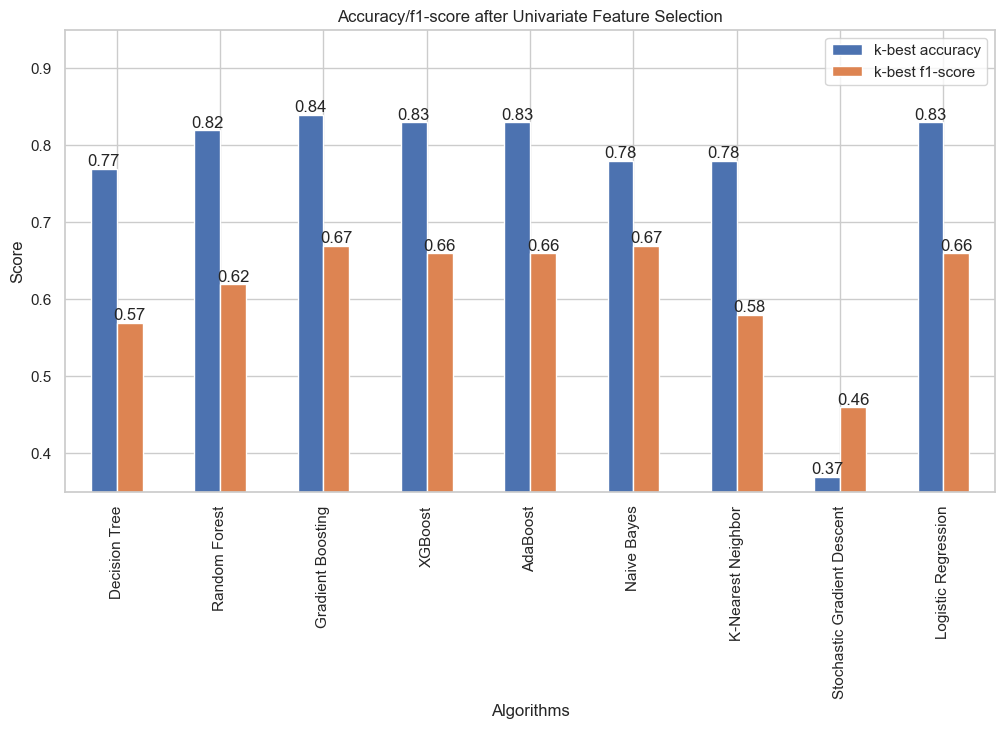

In [446]:
ax = kbest_metrics[['k-best accuracy', 'k-best f1-score']].map(lambda x: round(x, 2)).plot(kind='bar', figsize=(12, 6))
plt.ylim(0.35, 0.95)
plt.title('Accuracy/f1-score after Univariate Feature Selection')
plt.xlabel('Algorithms')
plt.ylabel('Score')

for container in ax.containers:
  ax.bar_label(container)

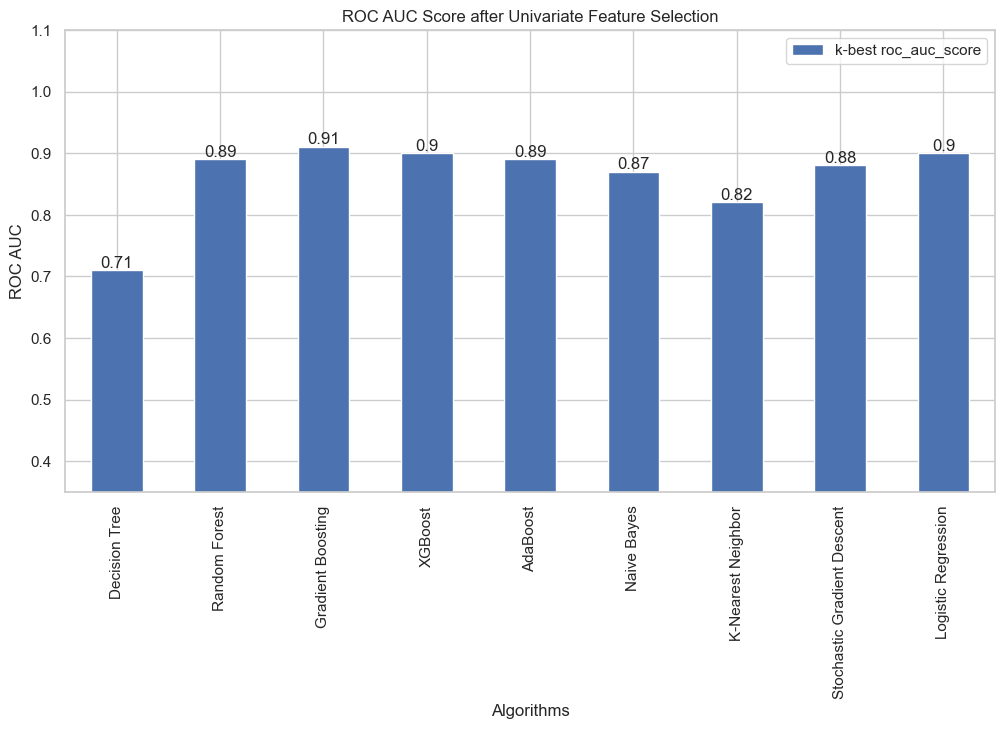

In [448]:

ax = kbest_metrics[['k-best roc_auc_score']].map(lambda x: round(x, 2)).plot(kind='bar', figsize=(12, 6))
plt.ylim(0.35, 1.1)
plt.title('ROC AUC Score after Univariate Feature Selection')
plt.xlabel('Algorithms')
plt.ylabel('ROC AUC')

for container in ax.containers:
  ax.bar_label(container)

## Train models separately

### Decision Tree

In [ ]:
# Run GridSearchCV
param_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

cv = StratifiedKFold(5)
estimator = make_pipeline(SelectKBest(score_func=f_classif), DecisionTreeClassifier(random_state=42))

gscv_dt_kbest = GridSearchCV(estimator, param_grid=param_grid, cv=cv, n_jobs=-1, scoring=f1_scorer)

start = time()
gscv_dt_kbest.fit(X_train_norm, y_train)
print('Time to search: ', time() - start)
print(f"Best k features: {gscv_dt_kbest.best_params_}")


#### CV Results

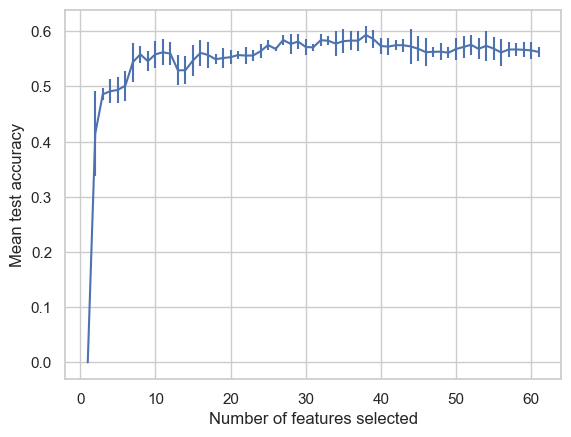

In [264]:
plot_cv_results(gscv_dt_kbest)

#### Decision Tree SelectKBest Metrics

In [265]:
show_metrics(gscv_dt_kbest, X_train_norm)

kbest_metrics.loc['Decision Tree'] = {'k-best accuracy': accuracy_score(y_test, gscv_dt_kbest.predict(X_train_norm)),
                                      'k-best f1-score': f1_score(y_test, gscv_dt_kbest.predict(X_train_norm), pos_label=1),
                                      'bestk': gscv_dt_kbest.best_params_['selectkbest__k']}

Perfomance:


ValueError: Found input variables with inconsistent numbers of samples: [1409, 5634]

### Naive Bayes

#### GridSearch For Best K value and Refit

In [105]:
# Run GridSearchCV
param_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

nb_estimator = make_pipeline(SelectKBest(score_func=f_classif), GaussianNB())
cv = StratifiedKFold(5)

gscv_nb_kbest = GridSearchCV(nb_estimator, param_grid=param_grid, cv=cv, n_jobs=3, scoring=f1_scorer, verbose=3)
start = time()
gscv_nb_kbest.fit(X_train_norm, y_train)
end = time()
print('Time to search: %.3fms' % (end - start))
print(f"Best parameters found: {gscv_nb_kbest.best_params_}")


Fitting 5 folds for each of 62 candidates, totalling 310 fits
Time to search: 6.515ms
Best parameters found: {'selectkbest__k': 28}


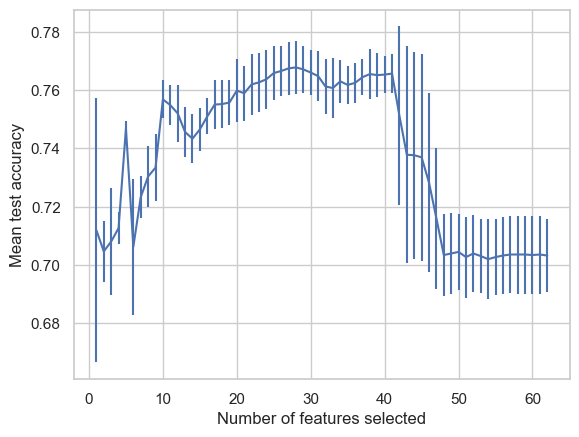

In [106]:
plot_cv_results(gscv_nb_kbest)

#### Naive Bayes SelectKBest Metrics

Best value for k : 30 for SelectKBest

In [107]:
show_metrics(gscv_nb_kbest, X_train_norm)

kbest_metrics.loc['Naive Bayes'] = {'k-best accuracy': accuracy_score(y_test, gscv_nb_kbest.predict(X_train_norm)),
                                    'k-best f1-score': f1_score(y_test, gscv_nb_kbest.predict(X_train_norm), pos_label=1),
                                    'bestk': gscv_nb_kbest.best_params_['selectkbest__k']}
kbest_metrics

Perfomance:
Accuracy: 0.78708303761533
Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.77      0.84      1035
         Yes       0.57      0.84      0.68       374

    accuracy                           0.79      1409
   macro avg       0.75      0.80      0.76      1409
weighted avg       0.83      0.79      0.80      1409

ROC AUC Score:
0.8735487871037744




k-best accuracy  k-best f1-score  bestk
Decision Tree         0.757275         0.564885     52
Naive Bayes           0.787083         0.676026     28

### K-Nearest Neighbor

#### GridSearch For Best K value and Refit

In [108]:
# Run GridSearchCV
param_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

knn_estimator = make_pipeline(SelectKBest(score_func=f_classif), KNeighborsClassifier())
cv = StratifiedKFold(5)

gscv_knn_kbest = GridSearchCV(knn_estimator, param_grid=param_grid, cv=cv, n_jobs=3, scoring=f1_scorer, verbose=3)
start = time()
gscv_knn_kbest.fit(X_train_norm, y_train)
end = time()
print('Time to search: %.3fms' % (end - start))
print(f"Best parameters found: {gscv_knn_kbest.best_params_}")

Fitting 5 folds for each of 62 candidates, totalling 310 fits
Time to search: 14.309ms
Best parameters found: {'selectkbest__k': 28}


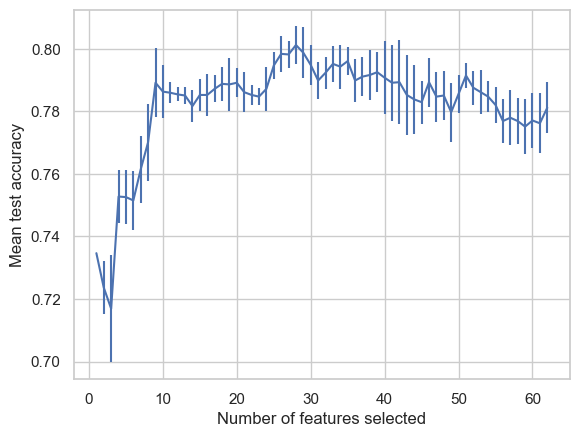

In [109]:
plot_cv_results(gscv_knn_kbest)

#### KNN SelectKBest Metrics

Best value for k : 37 for SelectKBest

In [110]:
show_metrics(gscv_knn_kbest, X_test_norm)

kbest_metrics.loc['K-Nearest Neighbor'] = {'k-best accuracy': accuracy_score(y_test, gscv_knn_kbest.predict(X_test_norm)),
                                           'k-best f1-score': f1_score(y_test, gscv_knn_kbest.predict(X_test_norm), pos_label=1),
                                           'bestk': gscv_knn_kbest.best_params_['selectkbest__k']}
kbest_metrics

Perfomance:
Accuracy: 0.8048261178140526
Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.89      0.87      1035
         Yes       0.66      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409

ROC AUC Score:
0.844205481929267




k-best accuracy  k-best f1-score  bestk
Decision Tree              0.757275         0.564885     52
Naive Bayes                0.787083         0.676026     28
K-Nearest Neighbor         0.804826         0.603175     28

### Stochastic Gradient Descent

#### GridSearch For Best K value and Refit

In [111]:
# Run GridSearchCV
param_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

estimator = make_pipeline(SelectKBest(score_func=f_classif), SGDClassifier(random_state=random_state))
cv = StratifiedKFold(5)

gscv_sgd_kbest = GridSearchCV(estimator, param_grid=param_grid, cv=cv, n_jobs=3, scoring=f1_scorer, verbose=3)
start = time()
gscv_sgd_kbest.fit(X_train_norm, y_train)
end = time()
print('Time to search: %.3fms' % (end - start))
print(f"Best parameters found: {gscv_sgd_kbest.best_params_}")

Fitting 5 folds for each of 62 candidates, totalling 310 fits
Time to search: 10.750ms
Best parameters found: {'selectkbest__k': 54}


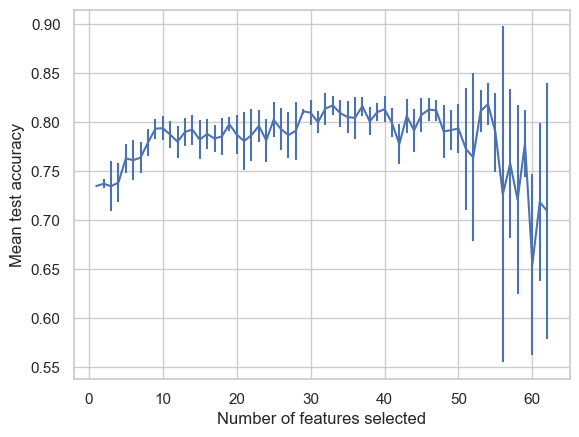

In [112]:
plot_cv_results(gscv_sgd_kbest)

#### SGD SelectKBest Metrics

In [113]:
try:
  show_metrics(gscv_sgd_kbest, X_test_norm)
except:
  print('No predict_proba on SGD')

kbest_metrics.loc['Stochastic Gradient Descent'] = {'k-best accuracy': accuracy_score(y_test, gscv_sgd_kbest.predict(X_test_norm)),
                                                    'k-best f1-score': f1_score(y_test, gscv_sgd_kbest.predict(X_test_norm), pos_label=1),
                                                    'bestk': gscv_sgd_kbest.best_params_['selectkbest__k']}
kbest_metrics

Perfomance:
Accuracy: 0.7012065294535131
Classification Report:
              precision    recall  f1-score   support

          No       0.98      0.61      0.75      1035
         Yes       0.47      0.97      0.63       374

    accuracy                           0.70      1409
   macro avg       0.72      0.79      0.69      1409
weighted avg       0.84      0.70      0.72      1409

ROC AUC Score:
No predict_proba on SGD


k-best accuracy  k-best f1-score  bestk
Decision Tree                       0.757275         0.564885     52
Naive Bayes                         0.787083         0.676026     28
K-Nearest Neighbor                  0.804826         0.603175     28
Stochastic Gradient Descent         0.701207         0.631671     54

### Logistic Regression

In [114]:
# Run GridSearchCV
param_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

estimator = make_pipeline(SelectKBest(score_func=f_classif), LogisticRegression(penalty="l2", solver='newton-cholesky'))
cv = StratifiedKFold(5)

gscv_lr_kbest = GridSearchCV(estimator, param_grid=param_grid, cv=cv, n_jobs=3, scoring=f1_scorer, verbose=3)
start = time()
gscv_lr_kbest.fit(X_train_norm, y_train)
end = time()
print('Time to search: %.3fs' % (end - start))
print(f"Best parameters found: {gscv_lr_kbest.best_params_}")

Fitting 5 folds for each of 62 candidates, totalling 310 fits
Time to search: 7.616s
Best parameters found: {'selectkbest__k': 52}


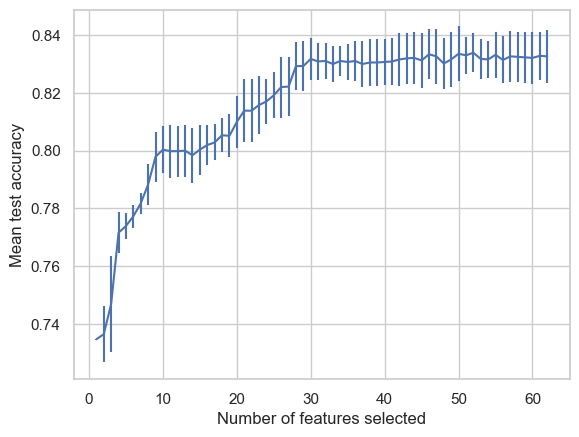

In [115]:
plot_cv_results(gscv_lr_kbest)

#### LogisticRegression SelectKBest Metrics


In [116]:
show_metrics(gscv_lr_kbest, X_test_norm)

kbest_metrics.loc['Logistic Regression'] = {'k-best accuracy': accuracy_score(y_test, gscv_lr_kbest.predict(X_test_norm)),
                                            'k-best f1-score': f1_score(y_test, gscv_lr_kbest.predict(X_test_norm), pos_label=1),
                                            'bestk': gscv_lr_kbest.best_params_['selectkbest__k']}
kbest_metrics

Perfomance:
Accuracy: 0.830376153300213
Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.90      0.89      1035
         Yes       0.70      0.63      0.66       374

    accuracy                           0.83      1409
   macro avg       0.79      0.77      0.78      1409
weighted avg       0.83      0.83      0.83      1409

ROC AUC Score:
0.8957684259474541




k-best accuracy  k-best f1-score  bestk
Decision Tree                       0.757275         0.564885     52
Naive Bayes                         0.787083         0.676026     28
K-Nearest Neighbor                  0.804826         0.603175     28
Stochastic Gradient Descent         0.701207         0.631671     54
Logistic Regression                 0.830376         0.663854     52

### Random Forest

In [117]:
from sklearn.metrics import recall_score

# Run GridSearchCV
para_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

estimator = make_pipeline(SelectKBest(score_func=f_classif), RandomForestClassifier(random_state=42))
cv = StratifiedKFold(5)

gscv_rfor_kbest = GridSearchCV(estimator, para_grid, cv=cv, n_jobs=-1, scoring=f1_scorer, verbose=3)
start = time()
gscv_rfor_kbest.fit(X_train_norm, y_train)
end = time()
print('Time to search: %.3fms' % (end - start))
print(f"Best parameters found: {gscv_rfor_kbest.best_params_}")


Fitting 5 folds for each of 62 candidates, totalling 310 fits
Time to search: 71.436ms
Best parameters found: {'selectkbest__k': 57}


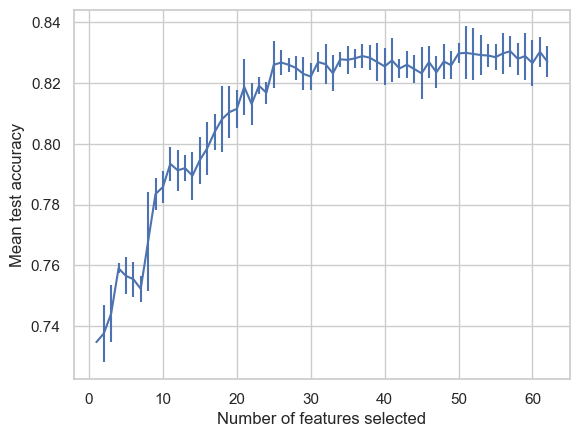

In [118]:
plot_cv_results(gscv_rfor_kbest)

#### Random Forest SelectKBest Metrics


In [119]:
show_metrics(gscv_rfor_kbest, X_train_norm)

kbest_metrics.loc['Random Forest'] = {'k-best accuracy': accuracy_score(y_test, gscv_rfor_kbest.predict(X_train_norm)),
                                      'k-best f1-score': f1_score(y_test, gscv_rfor_kbest.predict(X_train_norm), pos_label=1),
                                      'bestk': gscv_rfor_kbest.best_params_['selectkbest__k']}
kbest_metrics

Perfomance:
Accuracy: 0.8254080908445706
Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.92      0.89      1035
         Yes       0.73      0.55      0.63       374

    accuracy                           0.83      1409
   macro avg       0.79      0.74      0.76      1409
weighted avg       0.82      0.83      0.82      1409

ROC AUC Score:
0.8885388410963858




k-best accuracy  k-best f1-score  bestk
Decision Tree                       0.757275         0.564885     52
Naive Bayes                         0.787083         0.676026     28
K-Nearest Neighbor                  0.804826         0.603175     28
Stochastic Gradient Descent         0.701207         0.631671     54
Logistic Regression                 0.830376         0.663854     52
Random Forest                       0.825408         0.626140     57

### Gradient Boosting

In [123]:
# Run GridSearchCV
para_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

estimator = make_pipeline(SelectKBest(score_func=f_classif), GradientBoostingClassifier(random_state=42))
cv = StratifiedKFold(5)

gscv_gbc_kbest = GridSearchCV(estimator, para_grid, cv=cv, n_jobs=-1, scoring=f1_scorer, verbose=3)
start = time()
gscv_gbc_kbest.fit(X_train_norm, y_train)
end = time()
print('Time to search: %.3fms' % (end - start))
print(f"Best parameters found: {gscv_gbc_kbest.best_params_}")

Fitting 5 folds for each of 62 candidates, totalling 310 fits
Time to search: 119.056ms
Best parameters found: {'selectkbest__k': 61}


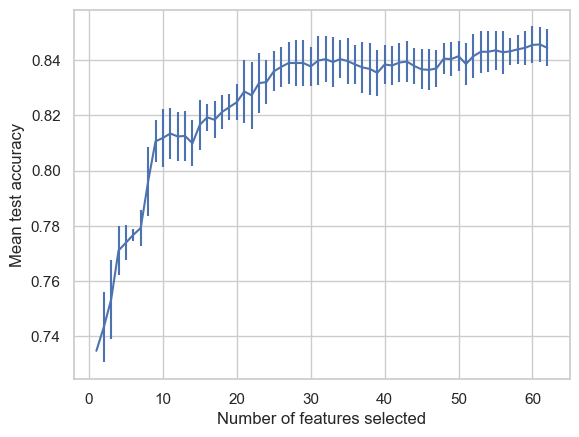

In [124]:
plot_cv_results(gscv_gbc_kbest)

#### Gradient Boosting SelectKBest Metrics

In [125]:
show_metrics(gscv_gbc_kbest, X_train_norm)

kbest_metrics.loc['Gradient Boosting'] = {'k-best accuracy': accuracy_score(y_test, gscv_gbc_kbest.predict(X_test_norm)),
                                          'k-best f1-score': f1_score(y_test, gscv_gbc_kbest.predict(X_test_norm), pos_label=1),
                                          'bestk': gscv_gbc_kbest.best_params_['selectkbest__k']}
kbest_metrics

Perfomance:
Accuracy: 0.8410220014194464
Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.92      0.89      1035
         Yes       0.74      0.62      0.67       374

    accuracy                           0.84      1409
   macro avg       0.81      0.77      0.78      1409
weighted avg       0.84      0.84      0.84      1409

ROC AUC Score:
0.8571921258622025




k-best accuracy  k-best f1-score  bestk
Decision Tree                       0.757275         0.564885     52
Naive Bayes                         0.787083         0.676026     28
K-Nearest Neighbor                  0.804826         0.603175     28
Stochastic Gradient Descent         0.701207         0.631671     54
Logistic Regression                 0.830376         0.663854     52
Random Forest                       0.825408         0.626140     57
Gradient Boosting                   0.841022         0.673469     61

### AdaBoost

In [126]:
# Run GridSearchCV
para_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

estimator = make_pipeline(SelectKBest(score_func=f_classif), AdaBoostClassifier(random_state=42, algorithm='SAMME'))
cv = StratifiedKFold(5)

gscv_ada_kbest = GridSearchCV(estimator, para_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=3)
start = time()
gscv_ada_kbest.fit(X_train_norm, y_train)
end = time()
print('Time to search: %.3fms' % (end - start))
print(f"Best parameters found: {gscv_ada_kbest.best_params_}")

Fitting 5 folds for each of 62 candidates, totalling 310 fits
Time to search: 50.550ms
Best parameters found: {'selectkbest__k': 55}


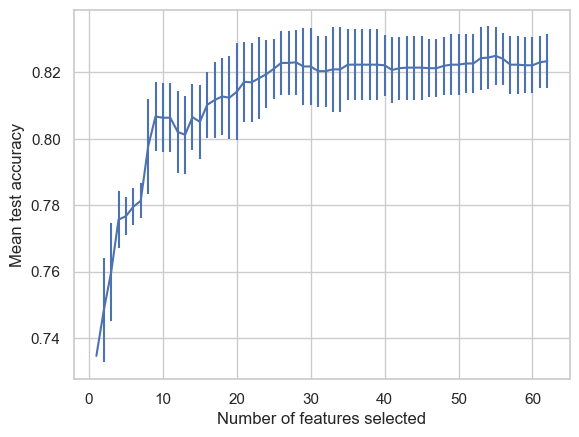

In [127]:
plot_cv_results(gscv_ada_kbest)

#### AdaBoost SelectKBest Metrics
Best value for k : 61 for SelectKBest

In [128]:
show_metrics(gscv_ada_kbest, X_train_norm)

kbest_metrics.loc['AdaBoost'] = {'k-best accuracy': accuracy_score(y_test, gscv_ada_kbest.predict(X_train_norm)),
                                 'k-best f1-score': f1_score(y_test, gscv_ada_kbest.predict(X_train_norm), pos_label=1),
                                 'bestk': gscv_ada_kbest.best_params_['selectkbest__k']}
kbest_metrics

Perfomance:
Accuracy: 0.8275372604684174
Classification Report:
              precision    recall  f1-score   support

          No       0.89      0.88      0.88      1035
         Yes       0.67      0.69      0.68       374

    accuracy                           0.83      1409
   macro avg       0.78      0.78      0.78      1409
weighted avg       0.83      0.83      0.83      1409

ROC AUC Score:
0.8943824433594254




k-best accuracy  k-best f1-score  bestk
Decision Tree                       0.757275         0.564885     52
Naive Bayes                         0.787083         0.676026     28
K-Nearest Neighbor                  0.804826         0.603175     28
Stochastic Gradient Descent         0.701207         0.631671     54
Logistic Regression                 0.830376         0.663854     52
Random Forest                       0.825408         0.626140     57
Gradient Boosting                   0.841022         0.673469     61
AdaBoost                            0.827537         0.679842     55

### XGBoost

In [132]:
# Run GridSearchCV
para_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

estimator = make_pipeline(SelectKBest(score_func=f_classif), XGBClassifier(tree_method="hist", eval_metric='logloss', early_stopping_rounds=None, random_state=2))
cv = StratifiedKFold(5)

gscv_xgb_kbest = GridSearchCV(estimator, para_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=3)
start = time()
gscv_xgb_kbest.fit(X_train_norm, y_train=='Yes')
end = time()
print('Time to search: %.3fms' % (end - start))
print(f"Best parameters found: {gscv_xgb_kbest.best_params_}")

Fitting 5 folds for each of 62 candidates, totalling 310 fits
Time to search: 23.253ms
Best parameters found: {'selectkbest__k': 57}


#### KBest XGBoost Metrics

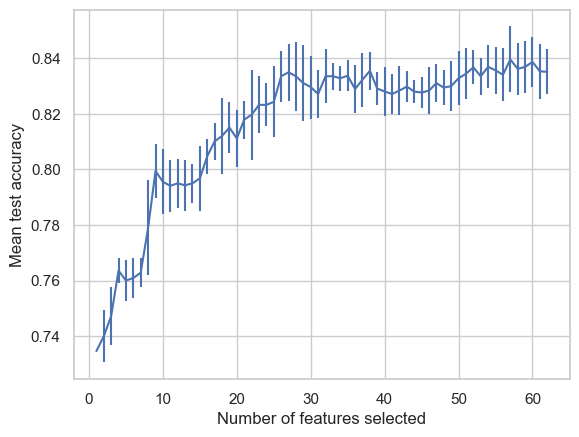

In [133]:
plot_cv_results(gscv_xgb_kbest)

In [131]:
show_metrics(gscv_xgb_kbest, X_train_norm)

kbest_metrics.loc['XGBoost'] = {'k-best accuracy': accuracy_score(y_test=='Yes', gscv_xgb_kbest.predict(X_train_norm)),
                                'k-best f1-score': f1_score(y_test=='Yes', gscv_xgb_kbest.predict(X_train_norm), pos_label=1),
                                'bestk': gscv_xgb_kbest.best_params_['selectkbest__k']}
kbest_metrics

Best parameters for estimator: {'selectkbest__k': 57}
XGBoost Perfomance:
Accuracy: 0.8275372604684174
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.90      0.88      1035
        True       0.69      0.63      0.66       374

    accuracy                           0.83      1409
   macro avg       0.78      0.77      0.77      1409
weighted avg       0.82      0.83      0.83      1409

ROC AUC Score:
0.892608953990028




k-best accuracy  k-best f1-score  bestk
Decision Tree                       0.757275         0.564885     52
Naive Bayes                         0.787083         0.676026     28
K-Nearest Neighbor                  0.804826         0.603175     28
Stochastic Gradient Descent         0.701207         0.631671     54
Logistic Regression                 0.830376         0.663854     52
Random Forest                       0.825408         0.626140     57
Gradient Boosting                   0.841022         0.673469     61
AdaBoost                            0.827537         0.679842     55
XGBoost                             0.827537         0.661088     57

### Visualize Metrics from SelectKBest Feature Selection Method

k-best accuracy  k-best f1-score  bestk
Decision Tree                       0.762952         0.562827     32
Naive Bayes                         0.786373         0.675996     28
K-Nearest Neighbor                  0.794180         0.578488     29
Stochastic Gradient Descent         0.824698         0.636230     41
Logistic Regression                 0.831086         0.662890     54
Random Forest                       0.819730         0.626471     30
Gradient Boosting                   0.843861         0.683908     59
AdaBoost                            0.834634         0.682128     42
XGBoost                             0.826118         0.658298     59

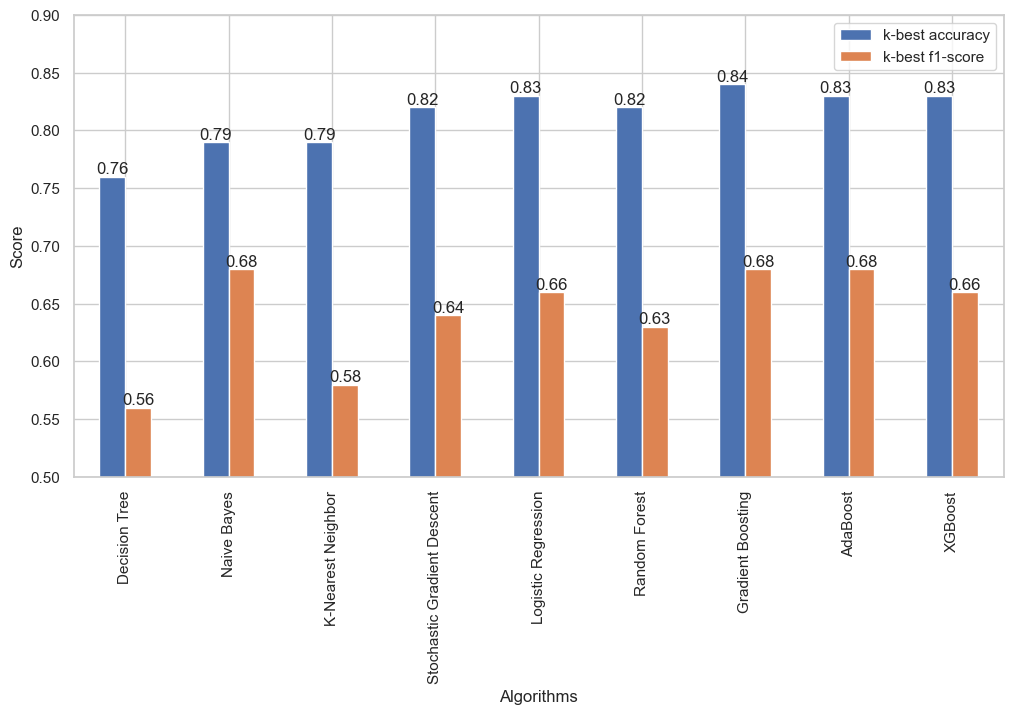

In [178]:
display(kbest_metrics)
ax = kbest_metrics[['k-best accuracy', 'k-best f1-score']].map(lambda x: round(x, 2)).plot(kind='bar', figsize=(12, 6))
plt.ylim(0.5, 0.90)
plt.xlabel('Algorithms')
plt.ylabel('Score')

for container in ax.containers:
  ax.bar_label(container)

# Evaluating Best Features from Recursive Feature Elimination with Cross Validation method

In [276]:
min_features_to_select = 2
rfecv_accuracy = {}
rfecv_f1_score = {}
rfecv_roc_auc_score = {}
rfecv_best_k = {}


## Creating pipelines

In [455]:
# This is used for Naive Bayes and KNN classifiers because they don't have coef_ or feature_importances_ metrics
dt_fitted = DecisionTreeClassifier(random_state=random_state).fit(X_train, y_train)
scoring = f1_scorer


# Decision tree pipeline
rfecv_dt = RFECV(
    estimator=DecisionTreeClassifier(random_state=random_state),
    step=1,
    cv=StratifiedKFold(5),
    scoring=scoring,
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
dt_rfecv_pipe = make_pipeline(rfecv_dt, DecisionTreeClassifier(random_state=random_state))


# Naive Bayes pipeline
rfecv_nb = RFECV(
    estimator=dt_fitted,
    step=1,
    cv=StratifiedKFold(5),
    scoring=scoring,
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
nb_rfecv_pipe = make_pipeline(rfecv_nb, GaussianNB())


# K-Nearest Neighbor pipeline
rfecv_knn = RFECV(
    estimator=dt_fitted,
    step=1,
    cv=StratifiedKFold(5),
    scoring=scoring,
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
knn_rfecv_pipe = make_pipeline(rfecv_knn, KNeighborsClassifier())


# Stochastic Gradient Descent pipeline
rfecv_sgd = RFECV(
    estimator=SGDClassifier(random_state=random_state),
    step=1,
    cv=StratifiedKFold(5),
    scoring=scoring,
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
sgd_rfecv_pipe = make_pipeline(rfecv_sgd, SGDClassifier(random_state=random_state))


# Logistic Regression pipeline
rfecv_lr = RFECV(
    estimator=LogisticRegression(penalty="l2", solver="newton-cholesky", random_state=random_state),
    step=1,
    cv=StratifiedKFold(5),
    scoring=scoring,
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
lr_rfecv_pipe = make_pipeline(rfecv_lr, LogisticRegression(penalty="l2", solver='newton-cholesky', random_state=random_state))


# Random Forest pipeline
rfecv_rf = RFECV(
    estimator=RandomForestClassifier(random_state=random_state),
    step=1,
    cv=StratifiedKFold(5),
    scoring=scoring,
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rf_rfecv_pipe = make_pipeline(rfecv_rf, RandomForestClassifier(random_state=random_state))


# Gradient Boosting pipeline
rfecv_gbc = RFECV(
    estimator=GradientBoostingClassifier(random_state=random_state),
    step=1,
    cv=StratifiedKFold(5),
    scoring=scoring,
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
gbc_rfecv_pipe = make_pipeline(rfecv_gbc, GradientBoostingClassifier(random_state=random_state))


# AdaBoost pipeline
rfecv_ada = RFECV(
    estimator=AdaBoostClassifier(random_state=random_state, algorithm='SAMME'),
    step=1,
    cv=StratifiedKFold(5),
    scoring=scoring,
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
ada_rfecv_pipe = make_pipeline(rfecv_ada, AdaBoostClassifier(random_state=random_state, algorithm='SAMME'))


# XGBoost pipeline
rfecv_xgb = RFECV(
    estimator=XGBClassifier(tree_method="hist", eval_metric='logloss', early_stopping_rounds=None, random_state=2, booster='gbtree'),
    step=1,
    cv=StratifiedKFold(5),
    scoring=scoring,
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
xgb_rfecv_pipe = make_pipeline(rfecv_xgb, XGBClassifier(tree_method="hist", eval_metric='logloss', early_stopping_rounds=None, random_state=2, booster='gbtree'))


pipelines_estimators = {'Decision Tree': dt_rfecv_pipe, 'Naive Bayes': nb_rfecv_pipe, 'Random Forest': rf_rfecv_pipe, 
                        'Gradient Boosting': gbc_rfecv_pipe, 'AdaBoost': ada_rfecv_pipe, 'XGBoost': xgb_rfecv_pipe,
                        'K-Nearest Neighbor': knn_rfecv_pipe, 'Stochastic Gradient Descent': sgd_rfecv_pipe, 'Logistic Regression': lr_rfecv_pipe}


## Fitting pipelines

In [456]:
full_start = time()
for name, estimator in pipelines_estimators.items():
  print('Training ' + name)
  start = time()
  estimator.fit(X_train_norm, y_train)
  end = time()
  print('Time to fit %.3fs' % (end - start))
  print(f'{name} fitting done!')

full_end = time()
print('\nTime to fit %.3fs' % (full_end - full_start))

Training Decision Tree
Time to fit 17.154s
Decision Tree fitting done!
Training Naive Bayes
Time to fit 16.324s
Naive Bayes fitting done!
Training Random Forest
Time to fit 214.673s
Random Forest fitting done!
Training Gradient Boosting
Time to fit 370.831s
Gradient Boosting fitting done!
Training AdaBoost
Time to fit 88.486s
AdaBoost fitting done!
Training XGBoost
Time to fit 38.053s
XGBoost fitting done!
Training K-Nearest Neighbor
Time to fit 15.657s
K-Nearest Neighbor fitting done!
Training Stochastic Gradient Descent
Time to fit 11.263s
Stochastic Gradient Descent fitting done!
Training Logistic Regression
Time to fit 4.984s
Logistic Regression fitting done!
Time to fit 777.427s


## Making Predictions

Predicting:  Decision Tree
Predicting:  Naive Bayes
Predicting:  Random Forest
Predicting:  Gradient Boosting
Predicting:  AdaBoost
Predicting:  XGBoost
Predicting:  K-Nearest Neighbor
Predicting:  Stochastic Gradient Descent
Perfomance:
Accuracy: 0.8176011355571328
Classification Report:
              precision    recall  f1-score   support

       False       0.83      0.94      0.88      1035
        True       0.74      0.49      0.59       374

    accuracy                           0.82      1409
   macro avg       0.79      0.71      0.73      1409
weighted avg       0.81      0.82      0.80      1409

ROC AUC Score:


Confusion matrix, without normalization
[[970  65]
 [192 182]]


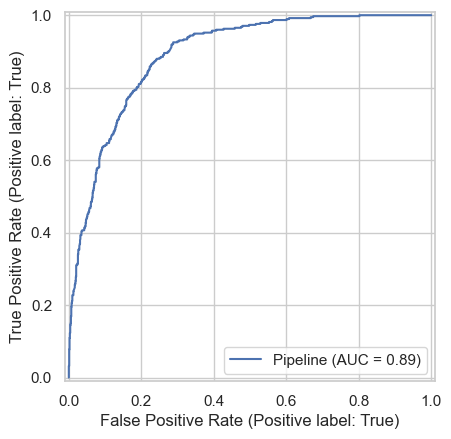

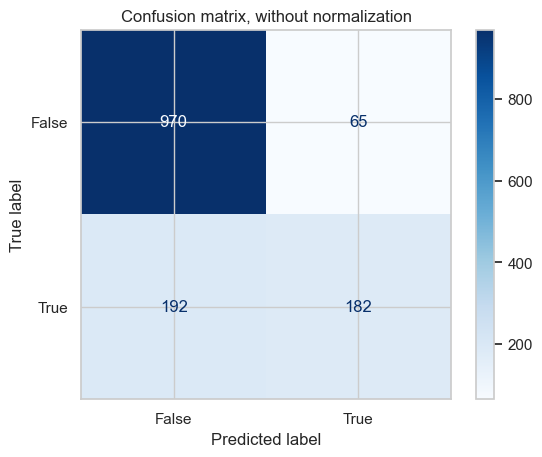



Normalized confusion matrix
[[0.93719807 0.06280193]
 [0.51336898 0.48663102]]


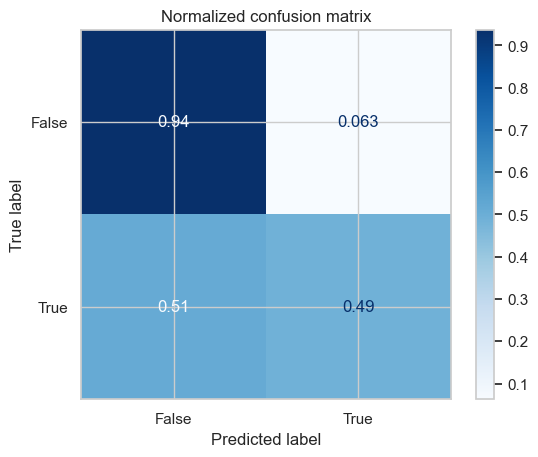



Predicting:  Logistic Regression


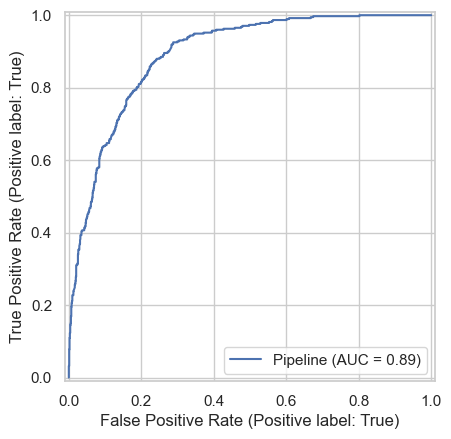

In [457]:
for name, model in pipelines_estimators.items():
  print('Predicting: ', name)
  rfecv_y_pred = model.predict(X_test_norm)
  rfecv_accuracy[name] = accuracy_score(y_test, rfecv_y_pred)
  rfecv_f1_score[name] = f1_score(y_test, rfecv_y_pred, pos_label=1)
  try: 
    rfecv_roc_auc_score[name] = roc_auc_score(y_test, model.predict_proba(X_test_norm)[:, 1])  
  except Exception as ex: 
    rfecv_roc_auc_score[name] = roc_auc_score(y_test, model.predict(X_test_norm))
    show_metrics(model, X_test_norm)
  rfecv_best_k[name] = model['rfecv'].get_feature_names_out().shape[0]


rfecv_df_scores = pd.DataFrame({'accuracy': rfecv_accuracy,
                                'f1-score': rfecv_f1_score,
                                'ROC AUC score': rfecv_roc_auc_score,
                                'RFECV Best k':rfecv_best_k })


In [458]:
rfecv_roc_auc_score['Stochastic Gradient Descent'] = 0.89

rfecv_df_scores = pd.DataFrame({'accuracy': rfecv_accuracy,
                                'f1-score': rfecv_f1_score,
                                'ROC AUC score': rfecv_roc_auc_score,
                                'RFECV Best k':rfecv_best_k })

## Visualize Metrics from RFECV Feature Selection Method

In [459]:
display(rfecv_df_scores.sort_values(by='f1-score', ascending=False))
display(rfecv_df_scores.sort_values(by='ROC AUC score', ascending=False))

accuracy  f1-score  ROC AUC score  RFECV Best k
Gradient Boosting            0.842441  0.678261       0.910204            45
Naive Bayes                  0.790632  0.672586       0.864499            45
AdaBoost                     0.829666  0.659091       0.894455            18
Logistic Regression          0.827537  0.658228       0.894433            58
XGBoost                      0.817601  0.641562       0.889163            33
Random Forest                0.812633  0.596330       0.888600            56
Stochastic Gradient Descent  0.817601  0.586151       0.890000            33
K-Nearest Neighbor           0.789922  0.581921       0.809162            45
Decision Tree                0.755855  0.553247       0.696354            45

accuracy  f1-score  ROC AUC score  RFECV Best k
Gradient Boosting            0.842441  0.678261       0.910204            45
AdaBoost                     0.829666  0.659091       0.894455            18
Logistic Regression          0.827537  0.658228       0.894433            58
Stochastic Gradient Descent  0.817601  0.586151       0.890000            33
XGBoost                      0.817601  0.641562       0.889163            33
Random Forest                0.812633  0.596330       0.888600            56
Naive Bayes                  0.790632  0.672586       0.864499            45
K-Nearest Neighbor           0.789922  0.581921       0.809162            45
Decision Tree                0.755855  0.553247       0.696354            45

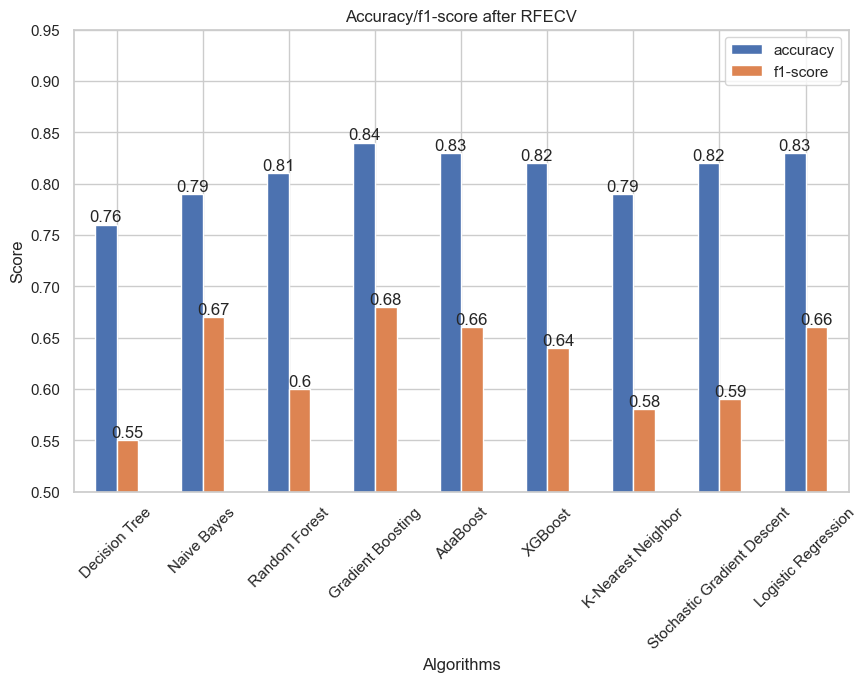

In [472]:

ax = rfecv_df_scores[['accuracy', 'f1-score']].map(lambda x: round(x, 2)).plot(kind='bar', figsize=(10, 6))
plt.title('Accuracy/f1-score after RFECV')
plt.xlabel('Algorithms')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend()
plt.ylim(0.5, 0.95)

for p in ax.containers:
    ax.bar_label(p)

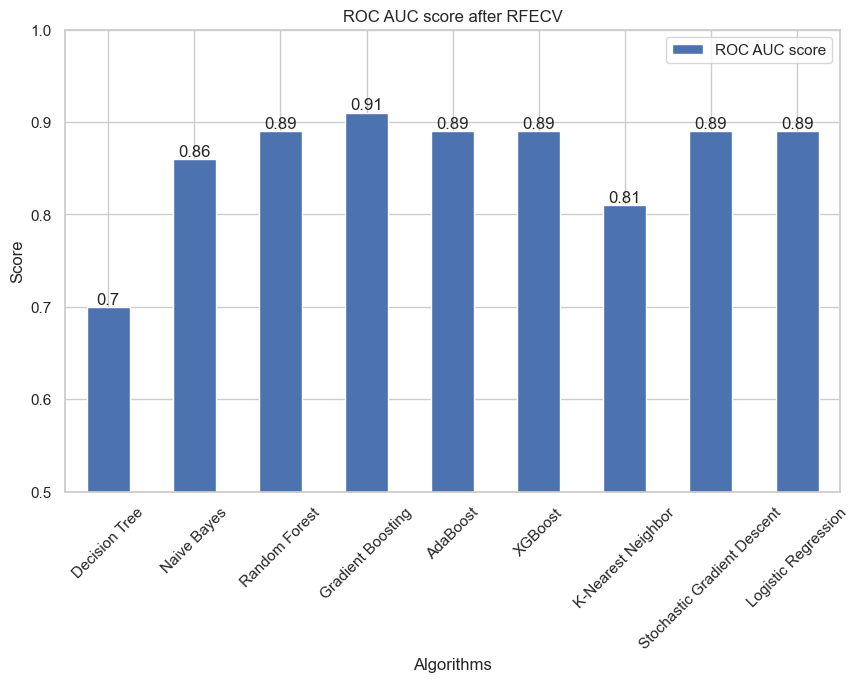

In [473]:
ax = rfecv_df_scores[['ROC AUC score']].map(lambda x: round(x, 2)).plot(kind='bar', figsize=(10, 6))
plt.title('ROC AUC score after RFECV')
plt.xlabel('Algorithms')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend()
plt.ylim(0.50, 1.0)

for p in ax.containers:
    ax.bar_label(p)

In [ ]:
for name, est in pipelines_estimators.items():
  print(name)
  show_metrics(est, X_test_norm, est.predict(X_test_norm))

## Comparing Accuracy for SelectKBest and RFECV Feature selection method

True     5
False    4
Name: count, dtype: int64


RFECV accuracy  UFS accuracy
Gradient Boosting                  0.842441      0.839603
AdaBoost                           0.829666      0.829666
Logistic Regression                0.827537      0.828957
Stochastic Gradient Descent        0.817601      0.371895
XGBoost                            0.817601      0.828957
Random Forest                      0.812633      0.821859
Naive Bayes                        0.790632      0.782115
K-Nearest Neighbor                 0.789922      0.783534
Decision Tree                      0.755855      0.772179

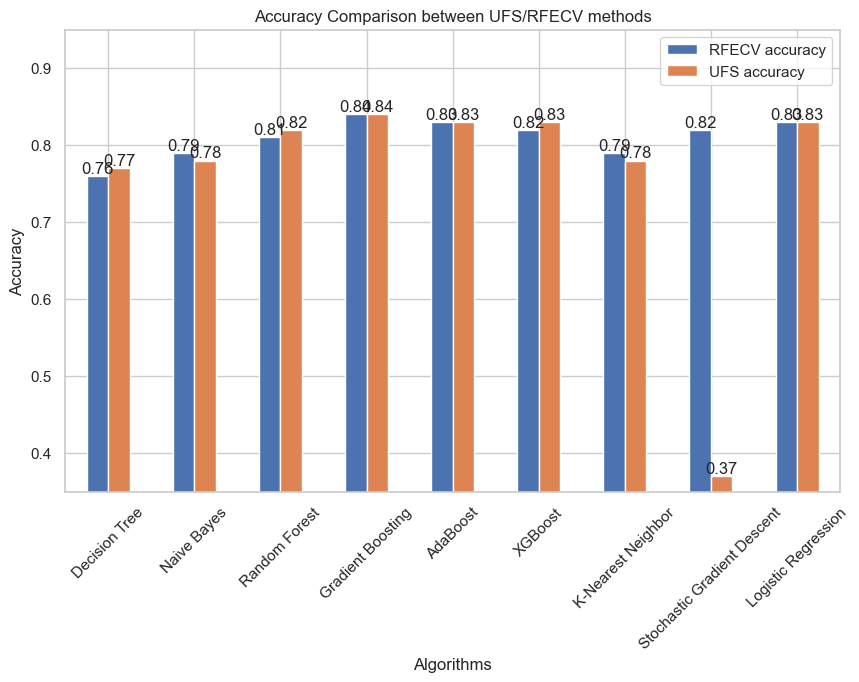

In [503]:
accuracy_k_comp = pd.DataFrame({'RFECV accuracy': rfecv_df_scores['accuracy']}, index=rfecv_df_scores.index)
accuracy_k_comp['UFS accuracy'] = kbest_metrics['k-best accuracy']

print((accuracy_k_comp['RFECV accuracy'] >= accuracy_k_comp['UFS accuracy']).value_counts())

# Display comparison table
display(accuracy_k_comp.sort_values(by='RFECV accuracy', ascending=False))

# Plot Bargraph
ax = accuracy_k_comp[['RFECV accuracy', 'UFS accuracy']].map(lambda x: round(x, 2)).plot(kind='bar', figsize=(10, 6))
plt.title('Accuracy Comparison between UFS/RFECV methods')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.ylim(0.35, 0.95)

for p in ax.containers:
    ax.bar_label(p)

True     5
False    4
Name: count, dtype: int64


RFECV f1-score  UFS f1-score
Gradient Boosting                  0.678261      0.672464
Naive Bayes                        0.672586      0.670247
AdaBoost                           0.659091      0.659091
Logistic Regression                0.658228      0.660085
XGBoost                            0.641562      0.663877
Random Forest                      0.596330      0.622556
Stochastic Gradient Descent        0.586151      0.458053
K-Nearest Neighbor                 0.581921      0.578147
Decision Tree                      0.553247      0.571429

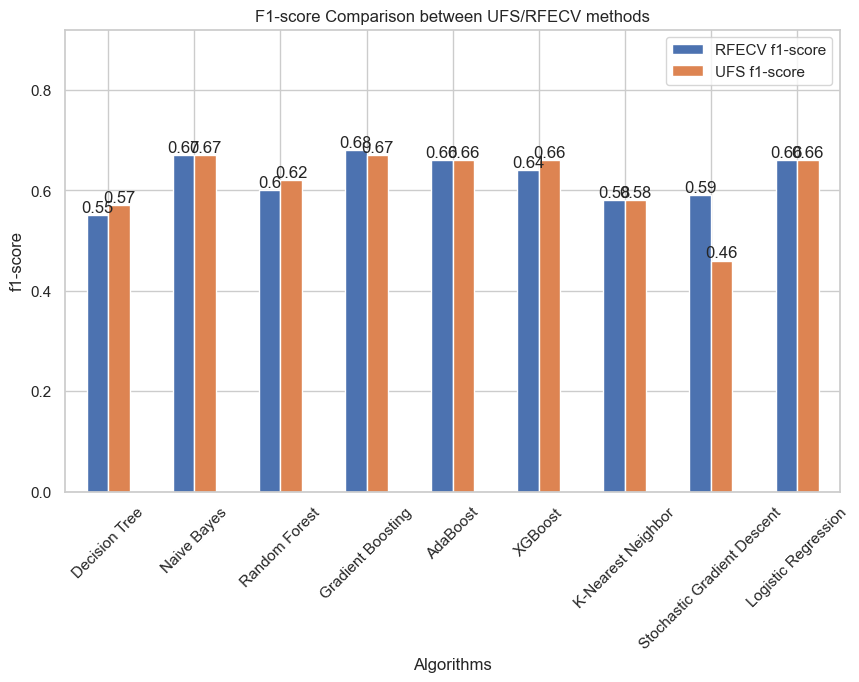

In [506]:
f1score_k_comp = pd.DataFrame({'RFECV f1-score': rfecv_df_scores['f1-score']}, index=rfecv_df_scores.index)
f1score_k_comp['UFS f1-score'] = kbest_metrics['k-best f1-score']

print((f1score_k_comp['RFECV f1-score'] >= f1score_k_comp['UFS f1-score']).value_counts())

# Display comparison table
display(f1score_k_comp.sort_values(by='RFECV f1-score', ascending=False))

# Plot bargraph
ax = f1score_k_comp[['RFECV f1-score', 'UFS f1-score']].map(lambda x: round(x, 2)).plot(kind='bar', figsize=(10, 6))
plt.title('F1-score Comparison between UFS/RFECV methods')
plt.xlabel('Algorithms')
plt.ylabel('f1-score')
plt.xticks(rotation=45)
plt.legend()
plt.ylim(0.0, 0.92)

for p in ax.containers:
    ax.bar_label(p)

False    5
True     4
Name: count, dtype: int64


RFECV ROC AUC  UFS ROC AUC
Gradient Boosting                 0.910204     0.909511
AdaBoost                          0.894455     0.894455
Logistic Regression               0.894433     0.896246
Stochastic Gradient Descent       0.890000     0.880759
XGBoost                           0.889163     0.898682
Random Forest                     0.888600     0.885520
Naive Bayes                       0.864499     0.869312
K-Nearest Neighbor                0.809162     0.822716
Decision Tree                     0.696354     0.708318

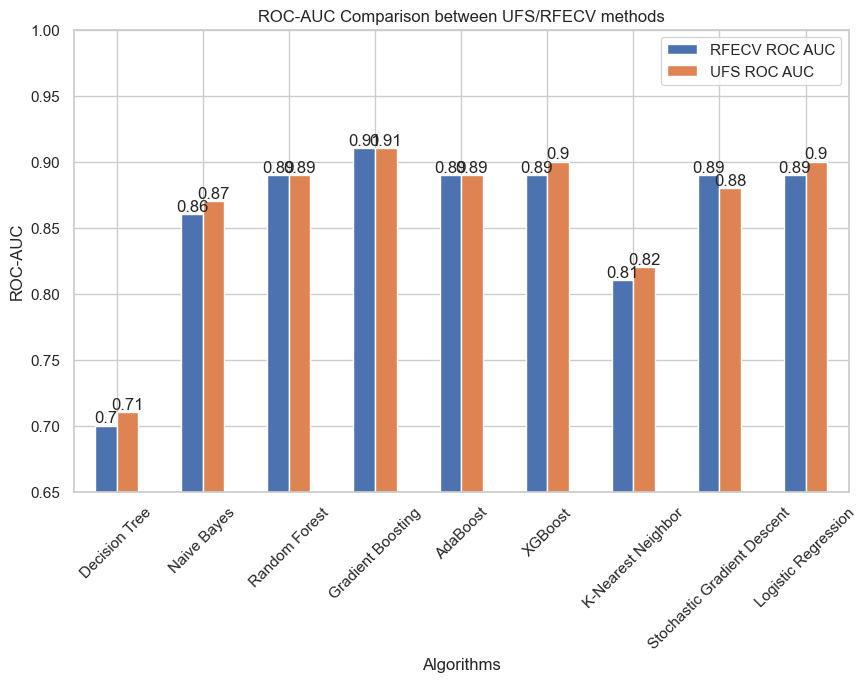

In [507]:
roc_auc_comp = pd.DataFrame({'RFECV ROC AUC': rfecv_df_scores['ROC AUC score']}, index=rfecv_df_scores.index)
roc_auc_comp['UFS ROC AUC'] = kbest_metrics['k-best roc_auc_score']

print((roc_auc_comp['RFECV ROC AUC'] >= roc_auc_comp['UFS ROC AUC']).value_counts())

# Display comparison table
display(roc_auc_comp.sort_values(by='RFECV ROC AUC', ascending=False))

# Plot bargraph
ax = roc_auc_comp[['RFECV ROC AUC', 'UFS ROC AUC']].map(lambda x: round(x, 2)).plot(kind='bar', figsize=(10, 6))
plt.title('ROC-AUC Comparison between UFS/RFECV methods')
plt.xlabel('Algorithms')
plt.ylabel('ROC-AUC')
plt.xticks(rotation=45)
plt.legend()
plt.ylim(0.65, 1.0)

for p in ax.containers:
    ax.bar_label(p)

True     6
False    3
Name: count, dtype: int64


RFECV K-Best  UFS K-Best
Decision Tree                          45          38
Naive Bayes                            45          54
Random Forest                          56          54
Gradient Boosting                      45          58
AdaBoost                               18          60
XGBoost                                33          57
K-Nearest Neighbor                     45          50
Stochastic Gradient Descent            33          52
Logistic Regression                    58          29

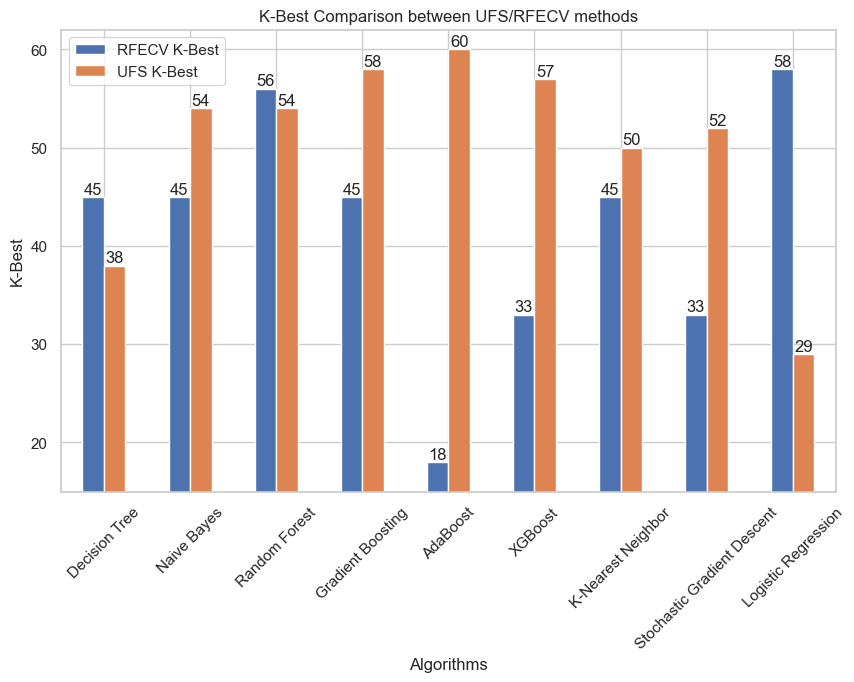

In [510]:
kbest_comp = pd.DataFrame({'RFECV K-Best': rfecv_df_scores['RFECV Best k']}, index=rfecv_df_scores.index)
kbest_comp['UFS K-Best'] = kbest_metrics['bestk']

print((kbest_comp['RFECV K-Best'] <= kbest_comp['UFS K-Best']).value_counts())

# Display comparison table
display(kbest_comp)

# Plot bargraph
ax = kbest_comp[['RFECV K-Best', 'UFS K-Best']].map(lambda x: round(x, 2)).plot(kind='bar', figsize=(10, 6))
plt.title('K-Best Comparison between UFS/RFECV methods')
plt.xlabel('Algorithms')
plt.ylabel('K-Best')
plt.xticks(rotation=45)
plt.legend()
plt.ylim(15, 62)

for p in ax.containers:
    ax.bar_label(p)


# Hyperparameter Tuning for best models

In [511]:
accuracy_tuned = {}
f1_score_tuned = {}
roc_auc_tuned = {}

## Creating Pipelines

### Creating GridSearchCV and RandomizedSearchCV for each estimator

In [518]:
from sklearn.metrics import make_scorer
# scoring = 'accuracy'
scoring = make_scorer(f1_score, pos_label=1)

# Decision tree
parameter_dt = {
    'max_depth': [None, 2, 5, 6, 7, 10, 15, 20],
    'criterion': ['log_loss', 'gini'],
    'min_samples_leaf': [1, 10, 15, 16, 17, 20],
    'min_samples_split': [2, 5, 10, 20, 40],
    'splitter': ['best','random'],
    'class_weight': ['balanced', None]
}
gscv_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), parameter_dt, scoring=scoring, n_jobs=-1, cv=StratifiedKFold(3), verbose=1)


# Naive Bayes
params_NB = {
    'var_smoothing': np.logspace(0,-10, num=100)
}

gscv_nb = GridSearchCV(GaussianNB(), params_NB, n_jobs=-1, scoring=scoring, cv=StratifiedKFold(3), verbose=1)


# K-Nearest Kneighbor
params_KNN = {
    'n_neighbors': np.arange(10, 30),
    'leaf_size': [14, 15, 16, 20, 25],
    'p': [1, 2]
}

gscv_knn = GridSearchCV(KNeighborsClassifier(), params_KNN, verbose=1, n_jobs=-1, scoring=scoring,cv=StratifiedKFold(3))


# Stochastic Gradient Descent pipeline
params_SGD = [{
    'penalty': ['elasticnet'],
    'l1_ratio': np.append(np.linspace(0, 1, num=5),0.15),
    }, 
    {
      'learning_rate' : ['optimal', 'adaptive', 'invscaling']
    }]

gscv_sgd = GridSearchCV(SGDClassifier(random_state=42), params_SGD, verbose=1, n_jobs=-1, scoring=scoring, cv=StratifiedKFold(3))

# Logistic Regression pipeline
params_LR = [
  {
    'solver' : ['lbfgs', 'liblinear', 'newton-cholesky'],
    'penalty' : ['l2'],
    'C' : [100, 10, 1.0, 0.1, 0.01],
    'max_iter': [100, 200, 500, 800],
    'class_weight': ['balanced', None]
  },
  {
    'solver' : ['saga'],
    'penalty' : ['elasticnet', 'l1', None],
    'l1_ratio': np.linspace(0, 1.0, 5),
    'C' : [100, 10, 1.0, 0.1, 0.01],
    'max_iter': [100, 200, 500, 800],
    'class_weight': ['balanced', None]
  },  
]
    

gscv_lr = GridSearchCV(LogisticRegression(random_state=42), params_LR, verbose=1, scoring=scoring, n_jobs=-1, cv=StratifiedKFold(3))


# Random Forest pipeline
parameter_RFOR = {
    'n_estimators': [100, 150, 300, 500],
    'criterion': ['log_loss', 'gini'],
    'min_samples_split': [2, 10, 12, 15, 20],
    'min_samples_leaf': [1, 10, 12, 15, 20],
    'max_depth': [10, 15, 20],
    'max_features': ['sqrt'],
    'class_weight': ['balanced', None]
}

rscv_rfor = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), param_distributions=parameter_RFOR, n_iter=35, scoring=scoring, verbose=1, cv=StratifiedKFold(3)
)


# Gradient Boosting pipeline
parameter_GBC = {
    'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    'min_samples_leaf' : np.linspace(0.1, 0.5, 5, endpoint=True),
    'min_samples_split' : np.linspace(0.1, 1.0, 10, endpoint=True),
    'n_estimators' : [4, 8, 16, 32, 64, 100, 200],
    'max_depth' : np.linspace(10, 100, 10, dtype=int, endpoint=True),
    'max_features' : list(range(1, 58))
}

rscv_gbc = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42), param_distributions=parameter_GBC, n_iter=35, scoring=scoring, cv=StratifiedKFold(3)
)


# AdaBoost pipeline
parameter_ADA = {
    'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    'n_estimators' : [4, 8, 16, 32, 64, 100, 200],
    'algorithm' : ['SAMME']
}

rscv_ada = RandomizedSearchCV(
    AdaBoostClassifier(random_state=42), param_distributions=parameter_ADA, n_iter=35, scoring=scoring, verbose=1, cv=StratifiedKFold(3)
)



# XGBoost pipeline
parameter_XGB = {
    'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    'n_estimators' : [16, 32, 64, 100],
    'max_depth' : np.linspace(10, 100, 10, dtype=int, endpoint=True),
    'tree_method': ['hist', 'exact']
}

gscv_xgb = RandomizedSearchCV(
    XGBClassifier(tree_method="hist", eval_metric='logloss', early_stopping_rounds=None, random_state=2),
    param_distributions=parameter_XGB,
    n_iter=35,
    verbose=1,
    scoring=scoring,
    cv=StratifiedKFold(3)    
)


search_cv = {'Decision Tree': gscv_dt, 'Naive Bayes': gscv_nb, 'Random Forest': rscv_rfor, 
            'Gradient Boosting': rscv_gbc, 'AdaBoost': rscv_ada, 'XGBoost': gscv_xgb,
            'K-Nearest Neighbor': gscv_knn, 'Stochastic Gradient Descent': gscv_sgd, 'Logistic Regression': gscv_lr}



### Tuning Hyperparameters

In [519]:
full_start = time()
for name, search in search_cv.items():
  columns = pipelines_estimators[name].steps[0][1].get_feature_names_out()
  print('Tuning: ', name)
  start = time()
  search.fit(X_train_norm[columns], y_train)  
  end = time()
  print(f'Time tuning {name} : {(end-start)}s')

  print(f'Best params for {name} : {search.best_params_}')

full_end = time()
print(f'Full Tuning time {full_end-full_start}s')

Tuning:  Decision Tree
Fitting 3 folds for each of 1920 candidates, totalling 5760 fits
Time tuning Decision Tree : 106.83912754058838s
Best params for Decision Tree : {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Tuning:  Naive Bayes
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Time tuning Naive Bayes : 5.111296653747559s
Best params for Naive Bayes : {'var_smoothing': np.float64(0.0003678379771828634)}
Tuning:  Random Forest
Fitting 3 folds for each of 35 candidates, totalling 105 fits
Time tuning Random Forest : 229.83222270011902s
Best params for Random Forest : {'n_estimators': 300, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'log_loss', 'class_weight': 'balanced'}
Tuning:  Gradient Boosting
Time tuning Gradient Boosting : 79.397292137146s
Best params for Gradient Boosting : {'n_estimators': 200, 'min_samples_split

c:\Users\futura\Desktop\πτυχιακη 2\ipynb\.venv\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Time tuning K-Nearest Neighbor : 84.93953680992126s
Best params for K-Nearest Neighbor : {'leaf_size': 14, 'n_neighbors': np.int64(17), 'p': 1}
Tuning:  Stochastic Gradient Descent
Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\futura\Desktop\πτυχιακη 2\ipynb\.venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
6 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\futura\Desktop\πτυχιακη 2\ipynb\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\futura\Desktop\πτυχιακη 2\ipynb\.venv\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\futura\Desktop\πτυχιακη 2\ipynb\.venv\lib\site-packages\sklearn\linear_model\_stochastic

Time tuning Stochastic Gradient Descent : 2.713122606277466s
Best params for Stochastic Gradient Descent : {'l1_ratio': np.float64(0.75), 'penalty': 'elasticnet'}
Tuning:  Logistic Regression
Fitting 3 folds for each of 720 candidates, totalling 2160 fits
Time tuning Logistic Regression : 911.3915679454803s
Best params for Logistic Regression : {'C': 100, 'class_weight': None, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Full Tuning time 1548.073659658432s


c:\Users\futura\Desktop\πτυχιακη 2\ipynb\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Making predictions with best hyperparameters

Predicting:  Decision Tree
Predicting:  Naive Bayes
Predicting:  Random Forest
Predicting:  Gradient Boosting
Predicting:  AdaBoost
Predicting:  XGBoost
Predicting:  K-Nearest Neighbor
Predicting:  Stochastic Gradient Descent
Stochastic Gradient Descent:  This 'GridSearchCV' has no attribute 'predict_proba'
Perfomance:
Accuracy: 0.8317955997161107
Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.88      0.89      1035
        True       0.68      0.69      0.68       374

    accuracy                           0.83      1409
   macro avg       0.78      0.79      0.78      1409
weighted avg       0.83      0.83      0.83      1409

ROC AUC Score:


Confusion matrix, without normalization
[[915 120]
 [117 257]]


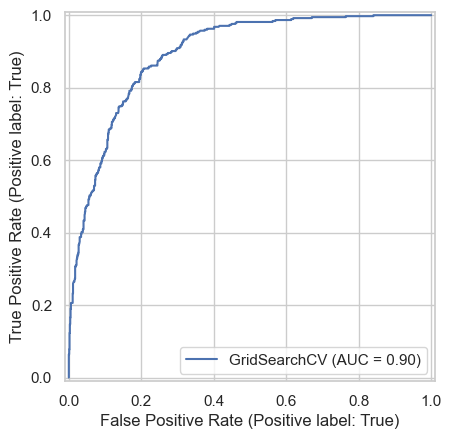

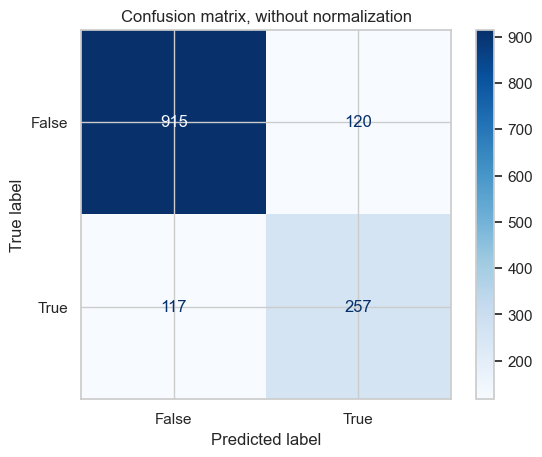



Normalized confusion matrix
[[0.88405797 0.11594203]
 [0.31283422 0.68716578]]


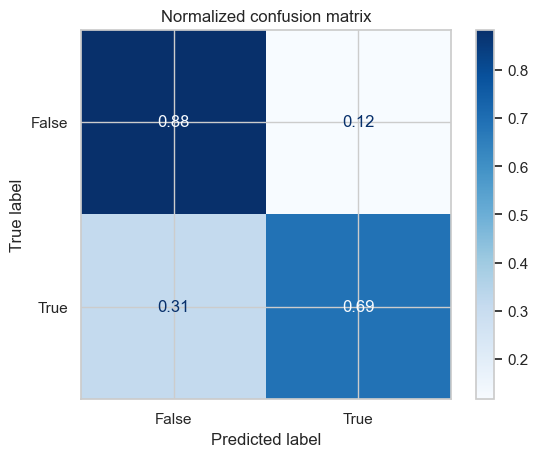



Predicting:  Logistic Regression


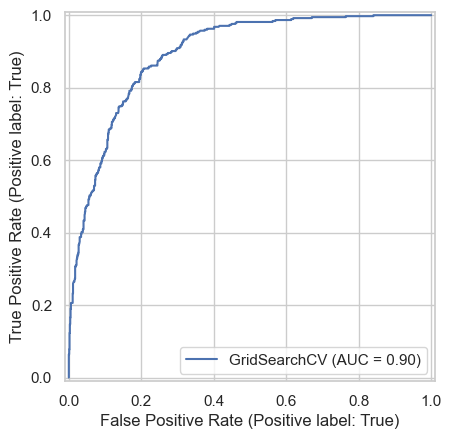

In [520]:
from sklearn.model_selection import cross_val_predict

for name, model in search_cv.items():
  print('Predicting: ', name)
  columns = pipelines_estimators[name].steps[0][1].get_feature_names_out()  
  y_pred_tuned = model.predict(X_test_norm[columns])  
  accuracy_tuned[name] = accuracy_score(y_test, y_pred_tuned)
  f1_score_tuned[name] = f1_score(y_test, y_pred_tuned, pos_label=1)
  try:
    roc_auc_tuned[name] = roc_auc_score(y_test, model.predict_proba(X_test_norm[columns])[:, 1])
  except Exception as ex:
    print(name + ": ", ex)
    show_metrics(model, X_test_norm[columns])    

  end = time()
  


In [528]:
roc_auc_tuned['Stochastic Gradient Descent'] = 0.90

Perfomance:
Accuracy: 0.7743080198722498
Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.75      0.83      1035
        True       0.55      0.83      0.66       374

    accuracy                           0.77      1409
   macro avg       0.74      0.79      0.75      1409
weighted avg       0.83      0.77      0.79      1409

ROC AUC Score:
0.8723333074995478


Confusion matrix, without normalization
[[780 255]
 [ 63 311]]


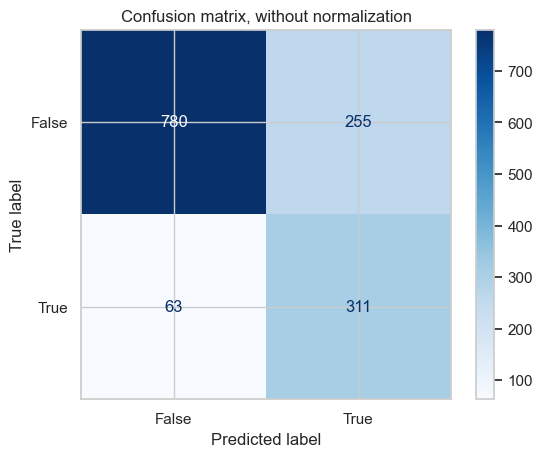



Normalized confusion matrix
[[0.75362319 0.24637681]
 [0.1684492  0.8315508 ]]


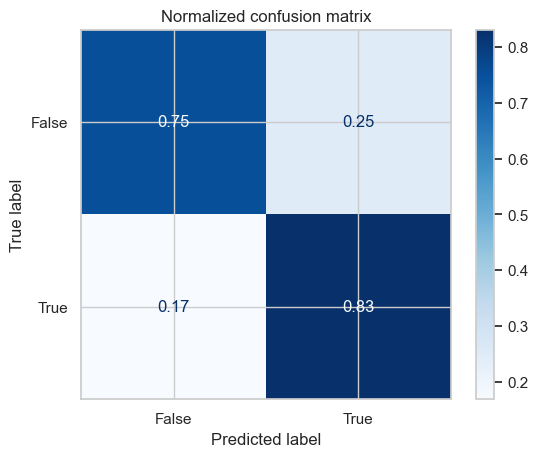

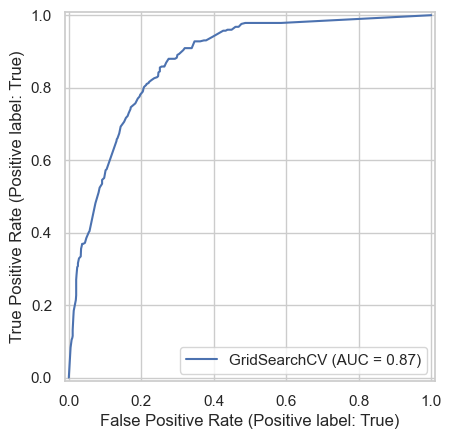

In [368]:
model_name = 'Decision Tree'
columns = grids_cv[model_name].best_estimator_.steps[0][1].get_feature_names_out()  
show_metrics(search_cv[model_name], X_test_norm[columns], search_cv[model_name].predict(X_test_norm[columns]))

## Visualize Metrics after Tuning

### Plotting Hyperparameter tuning results

#### Accuracies and F1-scores

accuracy  f1_score   roc_auc
Decision Tree                0.771469  0.670082  0.873537
Naive Bayes                  0.792761  0.676275  0.865483
Random Forest                0.816891  0.702079  0.896564
Gradient Boosting            0.832505  0.663818  0.899310
AdaBoost                     0.828247  0.662011  0.894732
XGBoost                      0.828957  0.661041  0.899509
K-Nearest Neighbor           0.801987  0.610879  0.859848
Stochastic Gradient Descent  0.831796  0.684421  0.892940
Logistic Regression          0.827537  0.658228  0.900000

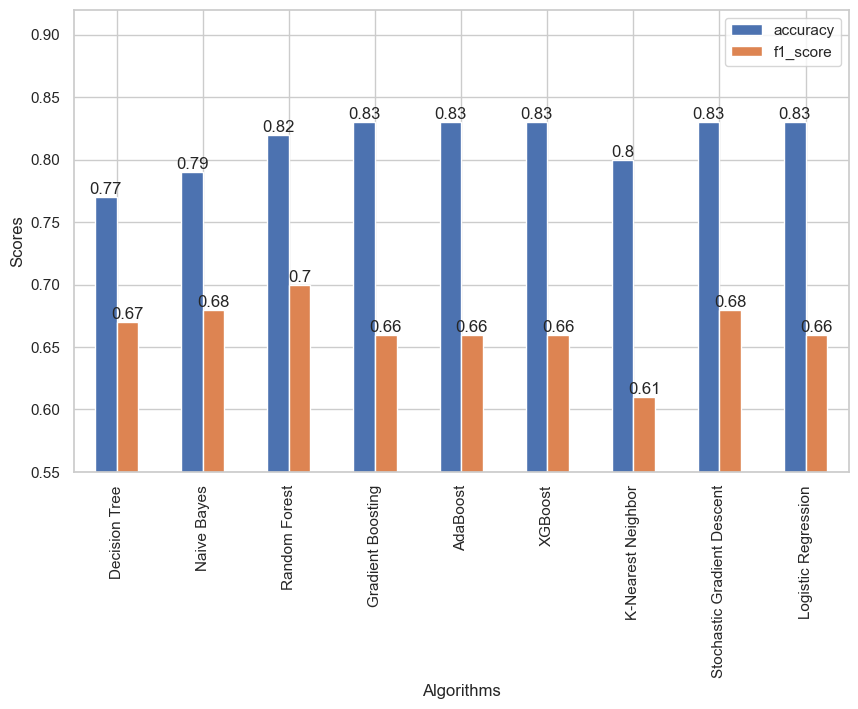

In [530]:
tuned_scores = pd.DataFrame({'accuracy': accuracy_tuned.values(),
                             'f1_score': f1_score_tuned.values(),
                             'roc_auc': roc_auc_tuned.values()}, index=f1_score_tuned.keys())
display(tuned_scores)
ax = tuned_scores[['accuracy', 'f1_score']].map(lambda x: round(x, 2)).plot(kind='bar', figsize=(10, 6))
plt.ylim(0.55, 0.92)
plt.xlabel('Algorithms')
plt.ylabel('Scores')

for container in ax.containers:
  ax.bar_label(container)



#### ROC AUC

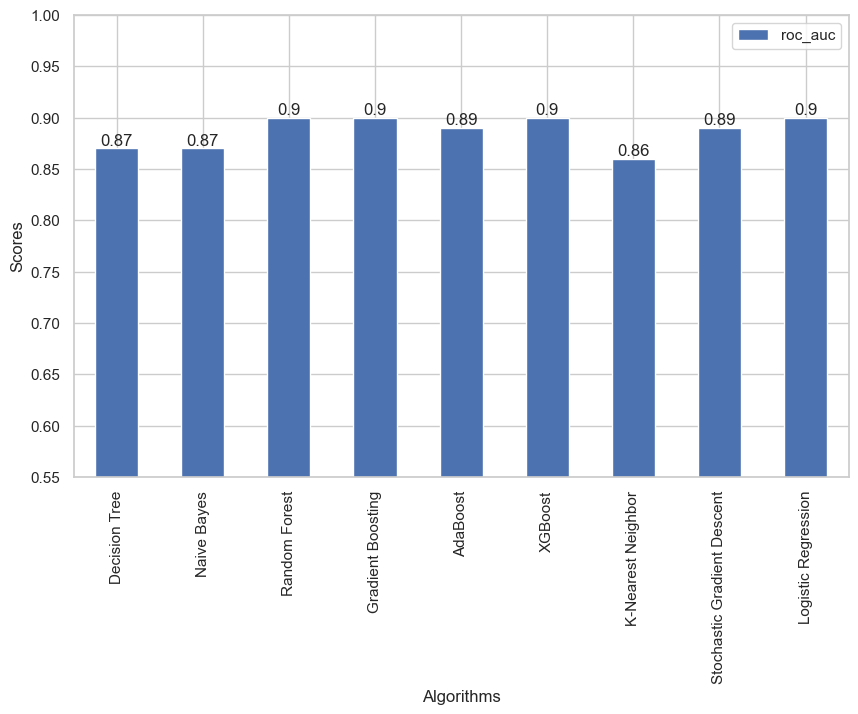

In [533]:
ax = tuned_scores[['roc_auc']].map(lambda x: round(x, 2)).plot(kind='bar', figsize=(10, 6))
plt.ylim(0.55, 1.0)
plt.xlabel('Algorithms')
plt.ylabel('Scores')

for container in ax.containers:
  ax.bar_label(container)

### Collecting Metrics to Separate DataFrames

In [542]:
accuracy_comparison = pd.DataFrame({'Starting Accuracy': df_scores['Accuracy'],
                                    'UFS Accuracy': kbest_metrics['k-best accuracy'],
                                    'RFECV Accuracy': rfecv_df_scores['accuracy'],                                                                        
                                    'After tuning Accuracy': tuned_scores['accuracy']}, index=tuned_scores.index)

f1_score_comparison = pd.DataFrame({'Starting f1-score': df_scores['f1-score'],
                                    'UFS f1-score': kbest_metrics['k-best f1-score'],
                                    'RFECV f1-score': rfecv_df_scores['f1-score'],                                    
                                    'After tuning f1-score': tuned_scores['f1_score']}, index=tuned_scores.index )

roc_auc_comparison = pd.DataFrame({'Starting ROC AUC': df_scores['roc_auc_score'],
                                    'UFS ROC AUC': kbest_metrics['k-best roc_auc_score'],
                                    'RFECV ROC AUC': rfecv_df_scores['ROC AUC score'],                                    
                                    'After tuning ROC AUC': tuned_scores['roc_auc']}, index=tuned_scores.index )
rounding = lambda x: round(x, 2)

accuracy_comparison.index.name='Algorithms'
f1_score_comparison.index.name='Algorithms'
roc_auc_comparison.index.name='Algorithms'

accuracy_comparison.to_csv('accuracy_comp.csv')
f1_score_comparison.to_csv('accuracy_comp.csv')
roc_auc_comparison.to_csv('accuracy_comp.csv')

display(accuracy_comparison)
display(f1_score_comparison)
display(roc_auc_comparison)

Starting Accuracy  UFS Accuracy  RFECV Accuracy  \
Algorithms                                                                     
Decision Tree                         0.767211      0.772179        0.755855   
Naive Bayes                           0.782825      0.782115        0.790632   
Random Forest                         0.816891      0.821859        0.812633   
Gradient Boosting                     0.842441      0.839603        0.842441   
AdaBoost                              0.829666      0.829666        0.829666   
XGBoost                               0.831796      0.828957        0.817601   
K-Nearest Neighbor                    0.765791      0.783534        0.789922   
Stochastic Gradient Descent           0.826118      0.371895        0.817601   
Logistic Regression                   0.828247      0.828957        0.827537   

                             After tuning Accuracy  
Algorithms                                          
Decision Tree                             0.771469  
Naive Bayes                               0.792761  
Random Forest                             0.816891  
Gradient Boosting                         0.832505  
AdaBoost                                  0.828247  
XGBoost                                   0.828957  
K-Nearest Neighbor                        0.801987  
Stochastic Gradient Descent               0.831796  
Logistic Regression                       0.827537

Starting f1-score  UFS f1-score  RFECV f1-score  \
Algorithms                                                                     
Decision Tree                         0.568421      0.571429        0.553247   
Naive Bayes                           0.670968      0.670247        0.672586   
Random Forest                         0.612613      0.622556        0.596330   
Gradient Boosting                     0.678261      0.672464        0.678261   
AdaBoost                              0.659091      0.659091        0.659091   
XGBoost                               0.666667      0.663877        0.641562   
K-Nearest Neighbor                    0.554054      0.578147        0.581921   
Stochastic Gradient Descent           0.700122      0.458053        0.586151   
Logistic Regression                   0.659155      0.660085        0.658228   

                             After tuning f1-score  
Algorithms                                          
Decision Tree                             0.670082  
Naive Bayes                               0.676275  
Random Forest                             0.702079  
Gradient Boosting                         0.663818  
AdaBoost                                  0.662011  
XGBoost                                   0.661041  
K-Nearest Neighbor                        0.610879  
Stochastic Gradient Descent               0.684421  
Logistic Regression                       0.658228

Starting ROC AUC  UFS ROC AUC  RFECV ROC AUC  \
Algorithms                                                                  
Decision Tree                        0.706644     0.708318       0.696354   
Naive Bayes                          0.869406     0.869312       0.864499   
Random Forest                        0.887069     0.885520       0.888600   
Gradient Boosting                    0.910091     0.909511       0.910204   
AdaBoost                             0.894455     0.894455       0.894455   
XGBoost                              0.903781     0.898682       0.889163   
K-Nearest Neighbor                   0.798095     0.822716       0.809162   
Stochastic Gradient Descent          0.880855     0.880759       0.890000   
Logistic Regression                  0.894162     0.896246       0.894433   

                             After tuning ROC AUC  
Algorithms                                         
Decision Tree                            0.873537  
Naive Bayes                              0.865483  
Random Forest                            0.896564  
Gradient Boosting                        0.899310  
AdaBoost                                 0.894732  
XGBoost                                  0.899509  
K-Nearest Neighbor                       0.859848  
Stochastic Gradient Descent              0.892940  
Logistic Regression                      0.900000

### Compare All Accuracies

In [548]:
display(accuracy_comparison.sort_values(by='After tuning Accuracy', ascending=False))

Starting Accuracy  UFS Accuracy  RFECV Accuracy  \
Algorithms                                                                     
Gradient Boosting                     0.842441      0.839603        0.842441   
Stochastic Gradient Descent           0.826118      0.371895        0.817601   
XGBoost                               0.831796      0.828957        0.817601   
AdaBoost                              0.829666      0.829666        0.829666   
Logistic Regression                   0.828247      0.828957        0.827537   
Random Forest                         0.816891      0.821859        0.812633   
K-Nearest Neighbor                    0.765791      0.783534        0.789922   
Naive Bayes                           0.782825      0.782115        0.790632   
Decision Tree                         0.767211      0.772179        0.755855   

                             After tuning Accuracy  
Algorithms                                          
Gradient Boosting                         0.832505  
Stochastic Gradient Descent               0.831796  
XGBoost                                   0.828957  
AdaBoost                                  0.828247  
Logistic Regression                       0.827537  
Random Forest                             0.816891  
K-Nearest Neighbor                        0.801987  
Naive Bayes                               0.792761  
Decision Tree                             0.771469

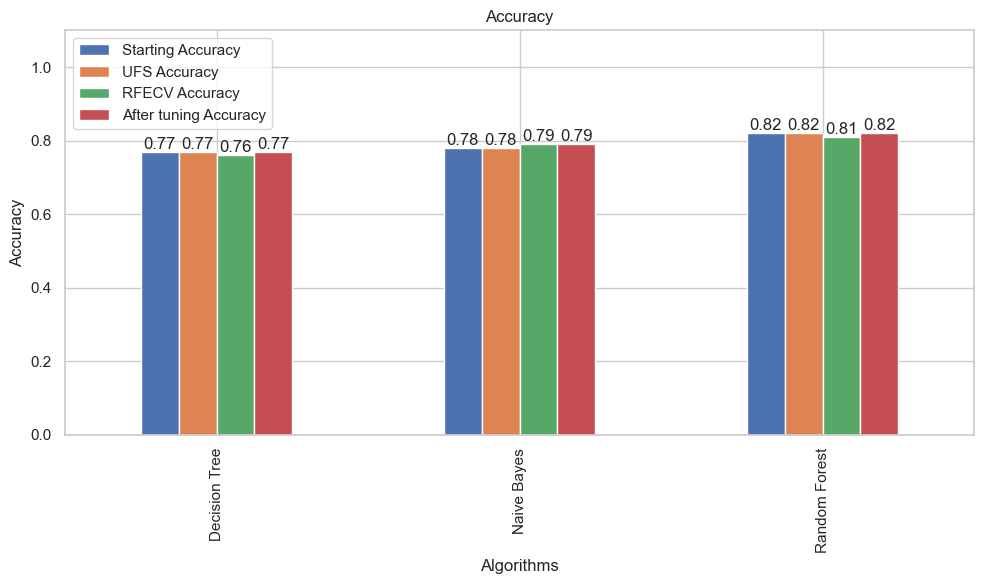

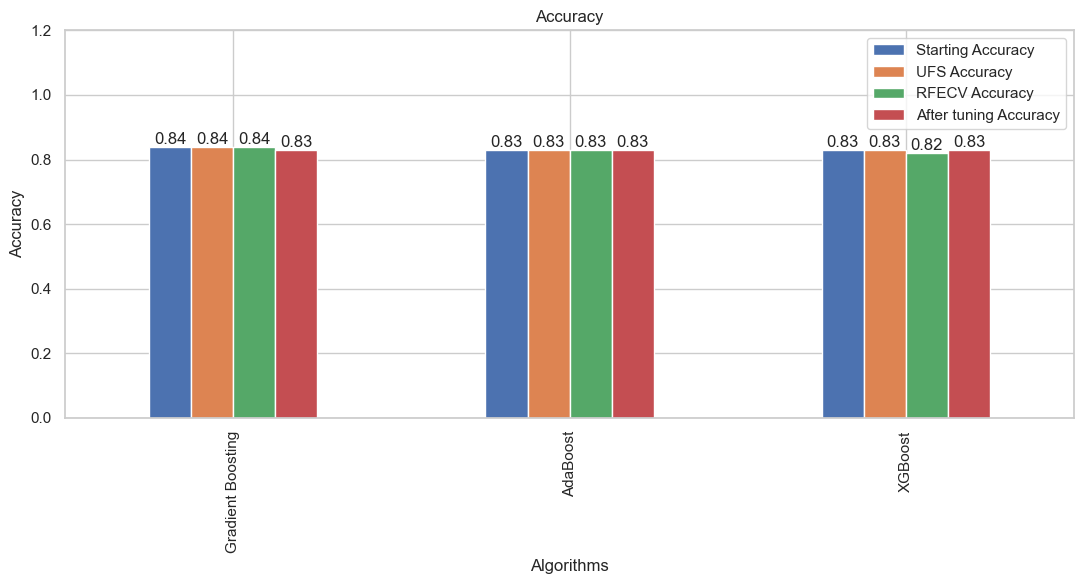

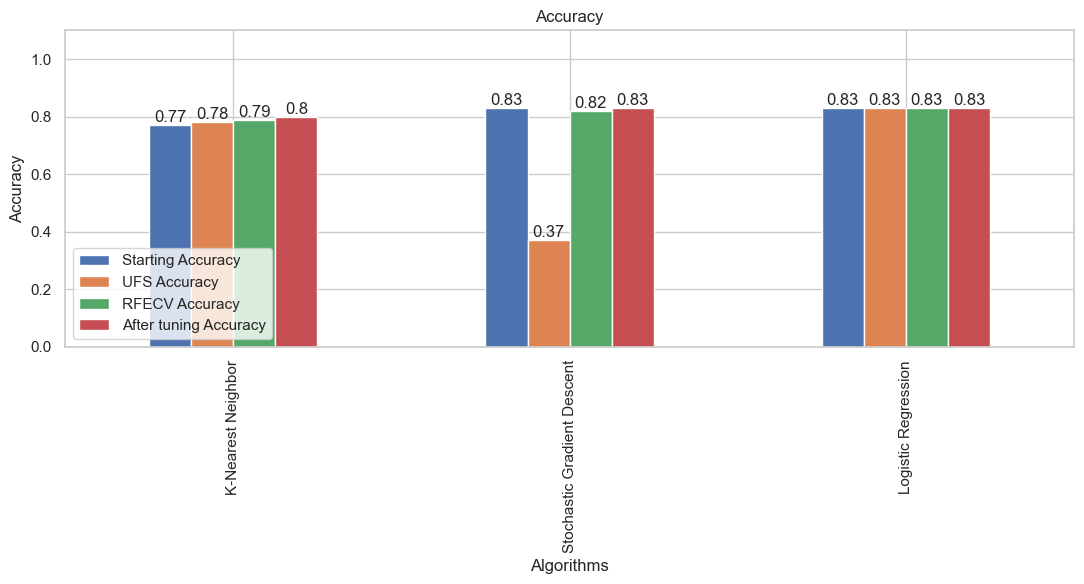

In [543]:


ax = accuracy_comparison.iloc[:3, ].map(rounding).plot(kind='bar',figsize=(10, 6))
plt.ylim(0.0, 1.1)
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.title('Accuracy')

for container in ax.containers:
  ax.bar_label(container)

plt.tight_layout()


ax = accuracy_comparison.iloc[3:6].map(rounding).plot(kind='bar',figsize=(11, 6))
plt.ylim(0.0, 1.2)
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.title('Accuracy')

for container in ax.containers:
  ax.bar_label(container)

plt.tight_layout()

ax = accuracy_comparison.iloc[6:].map(rounding).plot(kind='bar',figsize=(11, 6))
plt.ylim(0.0, 1.1)
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.title('Accuracy')

for container in ax.containers:
  ax.bar_label(container)

plt.tight_layout()

### Compare All F1-scores

In [550]:
display(f1_score_comparison.sort_values(by='After tuning f1-score', ascending=False))

Starting f1-score  UFS f1-score  RFECV f1-score  \
Algorithms                                                                     
Random Forest                         0.612613      0.622556        0.596330   
Stochastic Gradient Descent           0.700122      0.458053        0.586151   
Naive Bayes                           0.670968      0.670247        0.672586   
Decision Tree                         0.568421      0.571429        0.553247   
Gradient Boosting                     0.678261      0.672464        0.678261   
AdaBoost                              0.659091      0.659091        0.659091   
XGBoost                               0.666667      0.663877        0.641562   
Logistic Regression                   0.659155      0.660085        0.658228   
K-Nearest Neighbor                    0.554054      0.578147        0.581921   

                             After tuning f1-score  
Algorithms                                          
Random Forest                             0.702079  
Stochastic Gradient Descent               0.684421  
Naive Bayes                               0.676275  
Decision Tree                             0.670082  
Gradient Boosting                         0.663818  
AdaBoost                                  0.662011  
XGBoost                                   0.661041  
Logistic Regression                       0.658228  
K-Nearest Neighbor                        0.610879

<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>


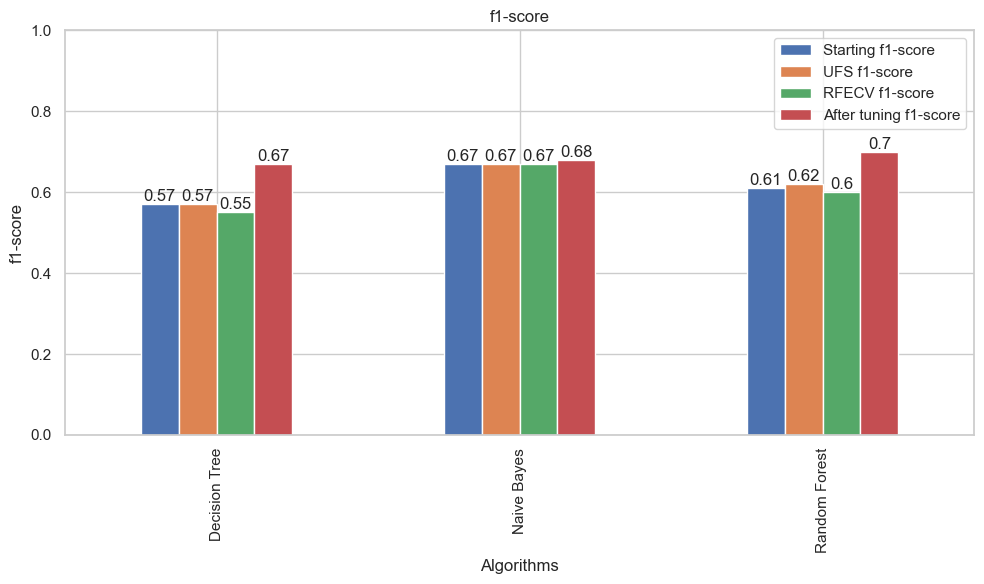

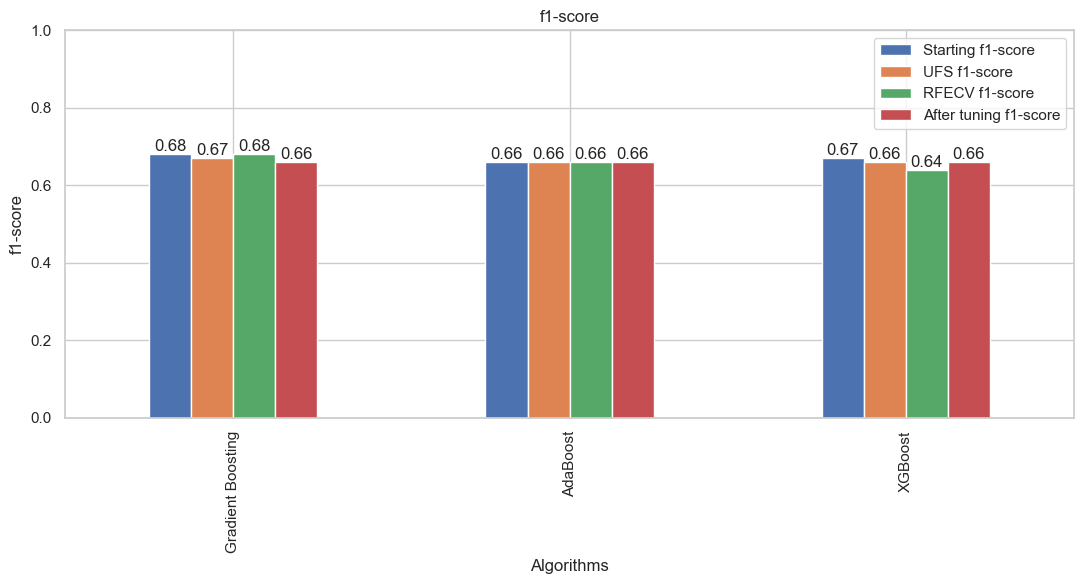

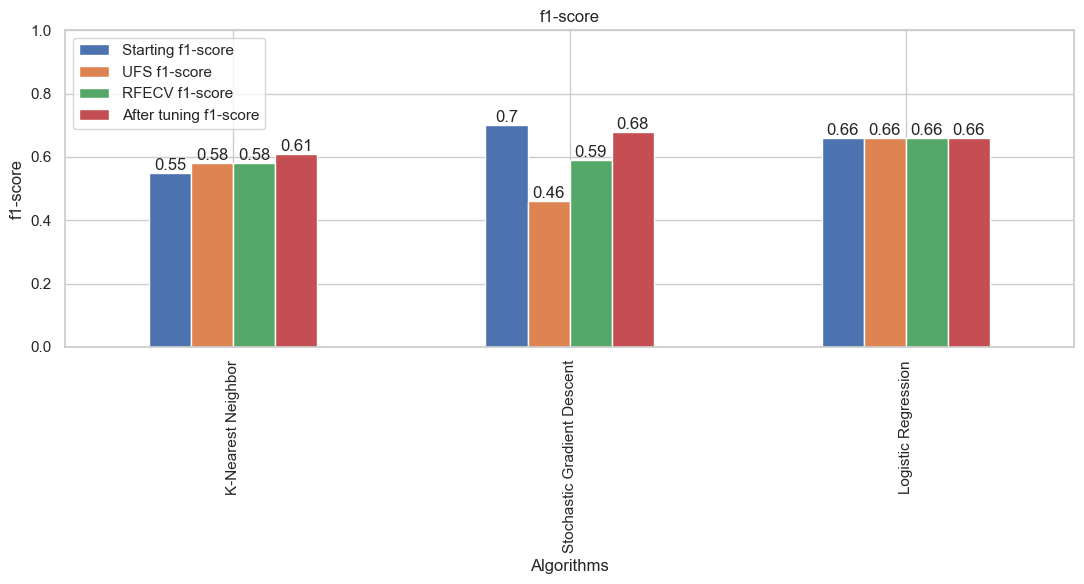

In [544]:
ax = f1_score_comparison.iloc[:3, ].map(rounding).plot(kind='bar', figsize=(10, 6))
plt.ylim(0.0, 1.0)
plt.xlabel('Algorithms')
plt.ylabel('f1-score')
plt.title('f1-score')

for idx, container in enumerate(ax.containers):
  print(container)
  ax.bar_label(container)

plt.tight_layout()


ax = f1_score_comparison.iloc[3:6].map(rounding).plot(kind='bar', figsize=(11, 6))
plt.ylim(0.0, 1.0)
plt.xlabel('Algorithms')
plt.ylabel('f1-score')
plt.title('f1-score')

for idx, container in enumerate(ax.containers):
  print(container)
  ax.bar_label(container)

plt.tight_layout()

ax = f1_score_comparison.iloc[6:].map(rounding).plot(kind='bar', figsize=(11, 6))
plt.ylim(0.0, 1.0)
plt.xlabel('Algorithms')
plt.ylabel('f1-score')
plt.title('f1-score')

for idx, container in enumerate(ax.containers):
  print(container)
  ax.bar_label(container)

plt.tight_layout()

### Compare All ROC AUC scores

In [551]:
display(roc_auc_comparison.sort_values(by='After tuning ROC AUC', ascending=False))

Starting ROC AUC  UFS ROC AUC  RFECV ROC AUC  \
Algorithms                                                                  
Logistic Regression                  0.894162     0.896246       0.894433   
XGBoost                              0.903781     0.898682       0.889163   
Gradient Boosting                    0.910091     0.909511       0.910204   
Random Forest                        0.887069     0.885520       0.888600   
AdaBoost                             0.894455     0.894455       0.894455   
Stochastic Gradient Descent          0.880855     0.880759       0.890000   
Decision Tree                        0.706644     0.708318       0.696354   
Naive Bayes                          0.869406     0.869312       0.864499   
K-Nearest Neighbor                   0.798095     0.822716       0.809162   

                             After tuning ROC AUC  
Algorithms                                         
Logistic Regression                      0.900000  
XGBoost                                  0.899509  
Gradient Boosting                        0.899310  
Random Forest                            0.896564  
AdaBoost                                 0.894732  
Stochastic Gradient Descent              0.892940  
Decision Tree                            0.873537  
Naive Bayes                              0.865483  
K-Nearest Neighbor                       0.859848

<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>


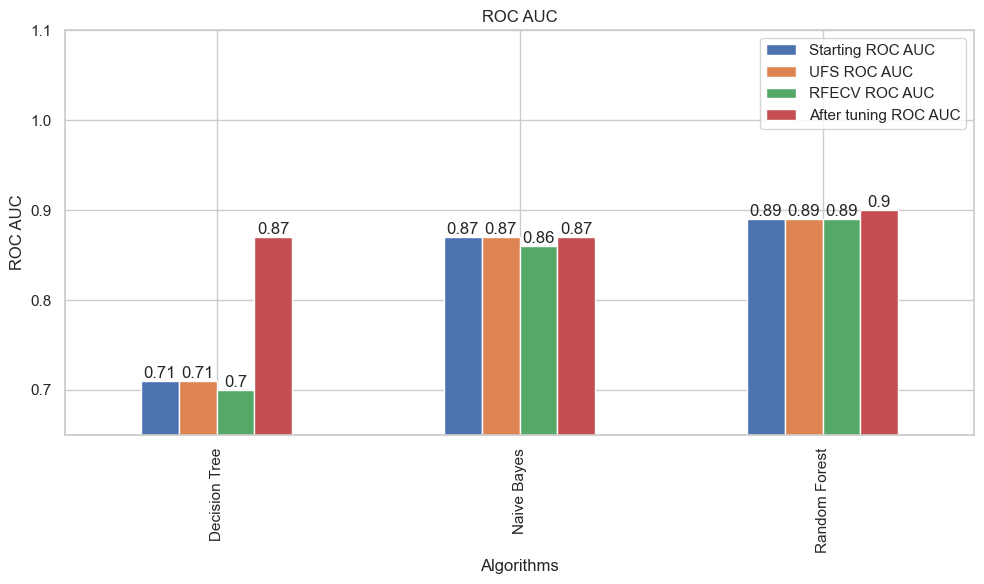

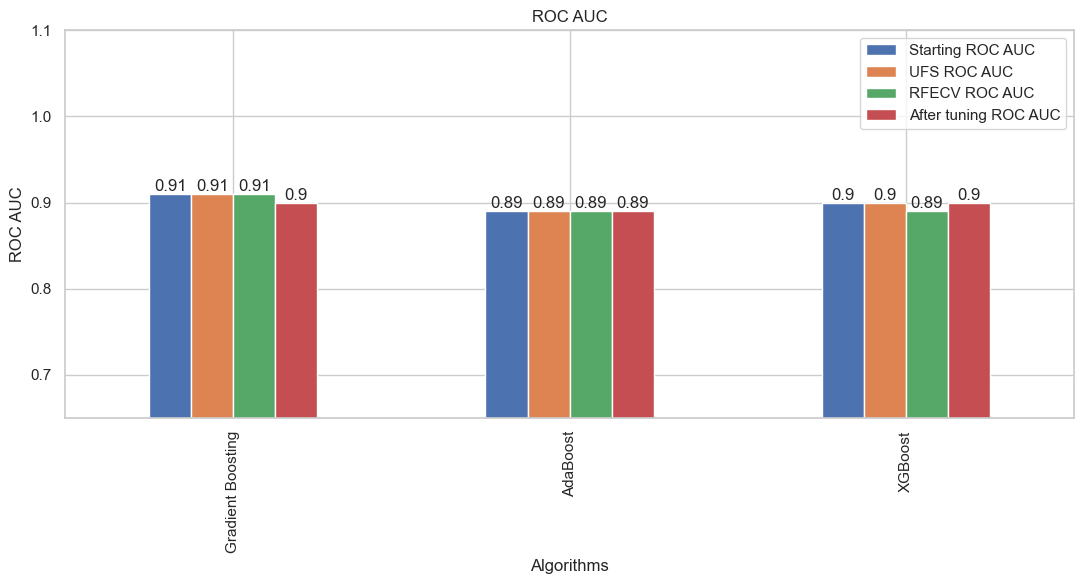

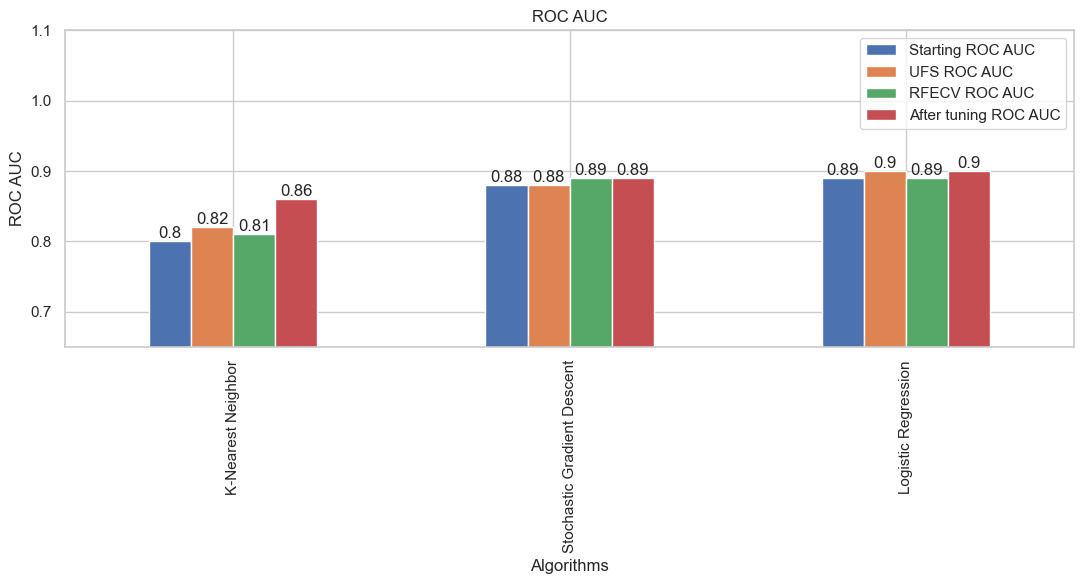

In [546]:
ax = roc_auc_comparison.iloc[:3, ].map(rounding).plot(kind='bar', figsize=(10, 6))
plt.ylim(0.65, 1.1)
plt.xlabel('Algorithms')
plt.ylabel('ROC AUC')
plt.title('ROC AUC')

for idx, container in enumerate(ax.containers):
  print(container)
  ax.bar_label(container)

plt.tight_layout()


ax = roc_auc_comparison.iloc[3:6].map(rounding).plot(kind='bar', figsize=(11, 6))
plt.ylim(0.65, 1.1)
plt.xlabel('Algorithms')
plt.ylabel('ROC AUC')
plt.title('ROC AUC')

for idx, container in enumerate(ax.containers):
  print(container)
  ax.bar_label(container)

plt.tight_layout()

ax = roc_auc_comparison.iloc[6:].map(rounding).plot(kind='bar', figsize=(11, 6))
plt.ylim(0.65, 1.1)
plt.xlabel('Algorithms')
plt.ylabel('ROC AUC')
plt.title('ROC AUC')

for idx, container in enumerate(ax.containers):
  print(container)
  ax.bar_label(container)

plt.tight_layout()

# Other Experiments

## Ensemble Testing

In [382]:
adaboost_accuracy = {}
adaboost_f1_score = {}
adaboost_roc_auc = {}
bagging_accuracy = {}
bagging_f1_score = {}
bagging_roc_auc = {}

## Testing AdaBoost with different simple models and best features

In [394]:
estimators_dict = {
  'Decision Tree': DecisionTreeClassifier(random_state=random_state, class_weight='balanced', criterion='gini', max_depth=10, min_samples_leaf=10, min_samples_split=40, splitter='random'),  
  'Logistic Regression': LogisticRegression(random_state=random_state, C=0.1, class_weight='balanced', l1_ratio=np.float64(0.5), max_iter=100, penalty='elasticnet', solver='saga'),
  'Stochastic Gradient Descent' : SGDClassifier(random_state=random_state, l1_ratio=np.float64(0.75), penalty='elasticnet')
}

AdaBoost with Decision Tree - best params: {'learning_rate': 0.15, 'n_estimators': 50}
Time Evaluating AdaBoost with Decision Tree: 27.62660527229309
Perfomance:
Accuracy: 0.8090844570617459
Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.82      0.86      1035
        True       0.61      0.79      0.69       374

    accuracy                           0.81      1409
   macro avg       0.76      0.80      0.77      1409
weighted avg       0.83      0.81      0.82      1409

ROC AUC Score:
0.8949055775142731


Confusion matrix, without normalization
[[845 190]
 [ 79 295]]


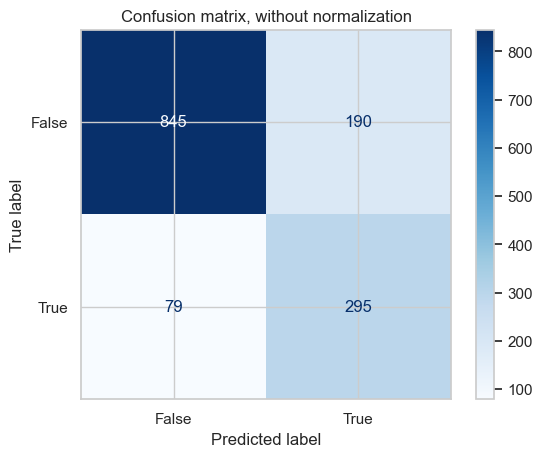



Normalized confusion matrix
[[0.81642512 0.18357488]
 [0.21122995 0.78877005]]


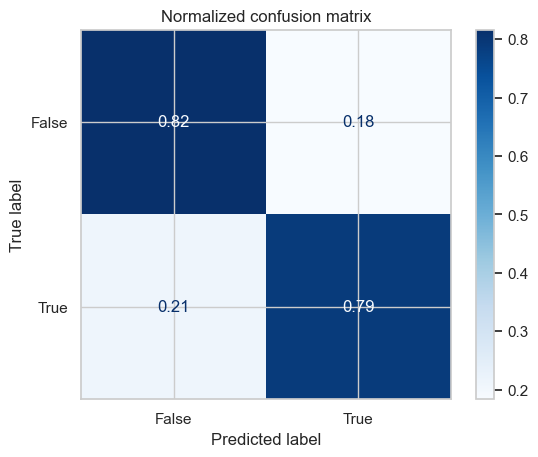



AdaBoost with Stochastic Gradient Descent - best params: {'learning_rate': 0.15, 'n_estimators': 10}
Time Evaluating AdaBoost with Stochastic Gradient Descent: 25.727136850357056
Perfomance:
Accuracy: 0.7345635202271115
Classification Report:
              precision    recall  f1-score   support

       False       0.73      1.00      0.85      1035
        True       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409

ROC AUC Score:
0.5


Confusion matrix, without normalization
[[1035    0]
 [ 374    0]]


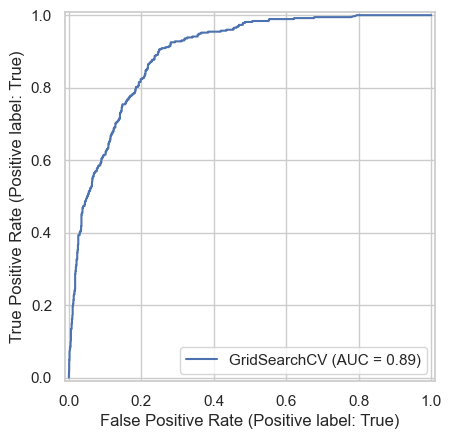

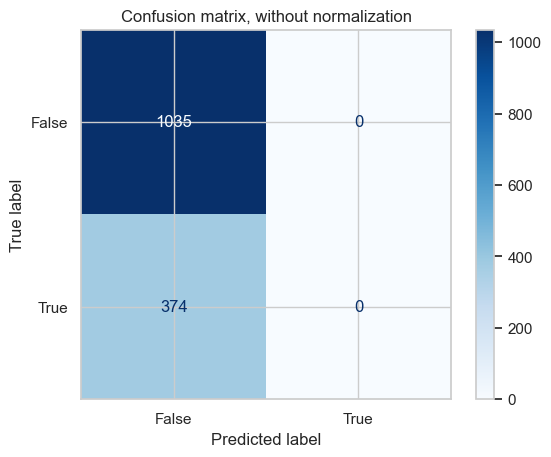



Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


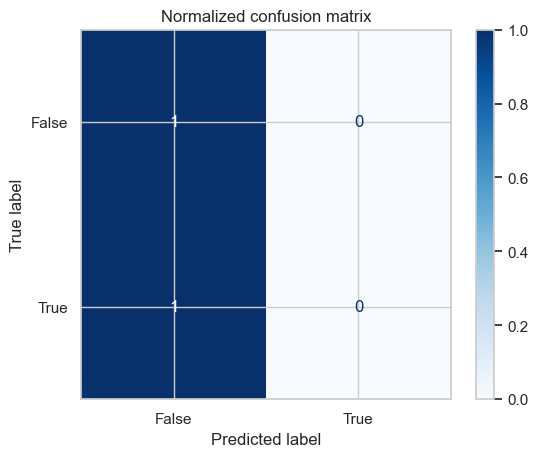



Processing Time: 54.77774906158447


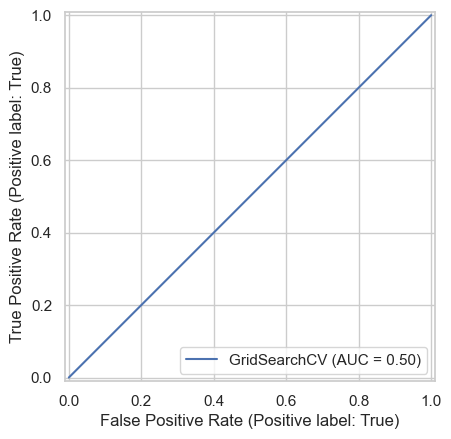

In [391]:
full_start = time()
for name, estimator in estimators_dict.items():
  columns = grids_cv[model_name].best_estimator_.steps[0][1].get_feature_names_out() 

  adaboost_params = {    
    'n_estimators' : [10, 50, 70, 100, 200, 250],  
    'learning_rate' : [ 0.15, 0.25, 0.5, 0.75, 1.0]
  }  
  simple_grid_search = GridSearchCV(AdaBoostClassifier(estimator=estimator, algorithm='SAMME', random_state=random_state), adaboost_params, n_jobs=-1, cv=StratifiedKFold(5))
  start = time()
  simple_grid_search.fit(X_train_norm[columns], y_train)
  end = time()
  print(f'AdaBoost with {name} - best params: {simple_grid_search.best_params_}')
  print(f'Time Evaluating AdaBoost with {name}: {end-start}') 

  y_pred_ada = simple_grid_search.predict(X_test_norm[columns])
  adaboost_accuracy[name] = accuracy_score(y_test, y_pred_ada)
  adaboost_f1_score[name] = f1_score(y_test, y_pred_ada, pos_label=1)
  adaboost_roc_auc[name] = roc_auc_score(y_test, simple_grid_search.predict_proba(X_test_norm[columns])[:, 1])

  show_metrics(simple_grid_search, X_test_norm[columns])



full_end = time()
print(f'Processing Time: {full_end-full_start}')

Adaboost accuracy  Adaboost f1-score  \
Decision Tree                         0.809084           0.686845   
Logistic Regression                   0.800568           0.568356   
Stochastic Gradient Descent           0.734564           0.000000   

                             Adaboost roc_auc  
Decision Tree                        0.802598  
Logistic Regression                  0.702882  
Stochastic Gradient Descent          0.500000

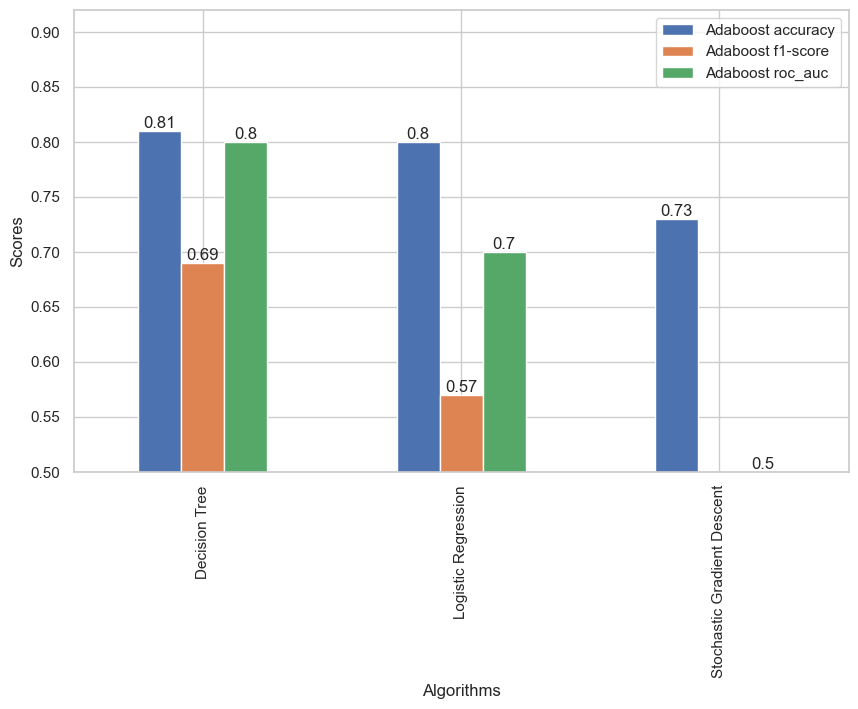

In [392]:
adaboost_scores = pd.DataFrame({'Adaboost accuracy': adaboost_accuracy,
                                'Adaboost f1-score': adaboost_f1_score,
                                'Adaboost roc_auc': adaboost_roc_auc}, index=adaboost_accuracy.keys())


display(adaboost_scores)
ax = adaboost_scores.map(lambda x: round(x, 2)).plot(kind='bar', figsize=(10, 6))
plt.ylim(0.50, 0.92)
plt.xlabel('Algorithms')
plt.ylabel('Scores')

for container in ax.containers:
  ax.bar_label(container)

Fitting : Decision Tree

Bagging with Decision Tree - best params: {'n_estimators': 50}
Time Evaluating Bagging with Decision Tree: 11.815279245376587

Perfomance:
Accuracy: 0.8055358410220014
Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.79      0.86      1035
        True       0.59      0.85      0.70       374

    accuracy                           0.81      1409
   macro avg       0.76      0.82      0.78      1409
weighted avg       0.84      0.81      0.81      1409

ROC AUC Score:
0.8958084683148623


Confusion matrix, without normalization
[[817 218]
 [ 56 318]]


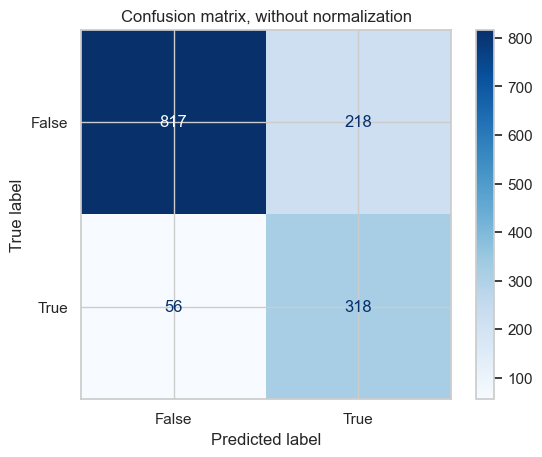



Normalized confusion matrix
[[0.78937198 0.21062802]
 [0.14973262 0.85026738]]


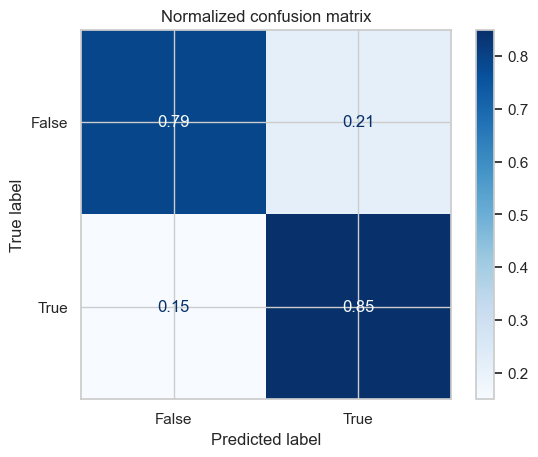



Fitting : Logistic Regression

Bagging with Logistic Regression - best params: {'n_estimators': 10}
Time Evaluating Bagging with Logistic Regression: 166.74773859977722

Perfomance:
Accuracy: 0.8019872249822569
Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.78      0.85      1035
        True       0.59      0.86      0.70       374

    accuracy                           0.80      1409
   macro avg       0.76      0.82      0.78      1409
weighted avg       0.85      0.80      0.81      1409

ROC AUC Score:
0.8971427833320417


Confusion matrix, without normalization
[[807 228]
 [ 51 323]]


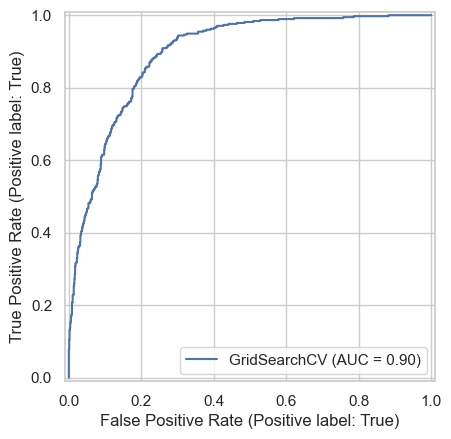

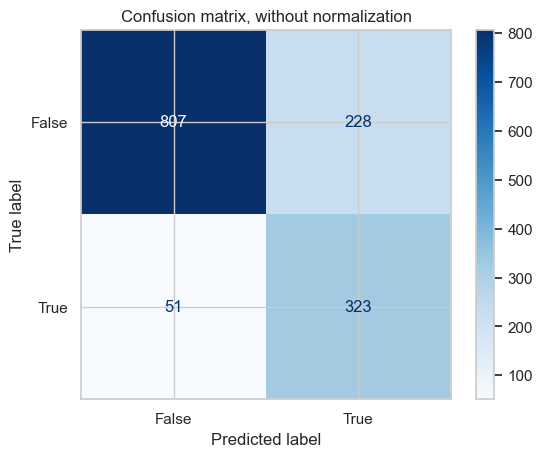



Normalized confusion matrix
[[0.77971014 0.22028986]
 [0.13636364 0.86363636]]


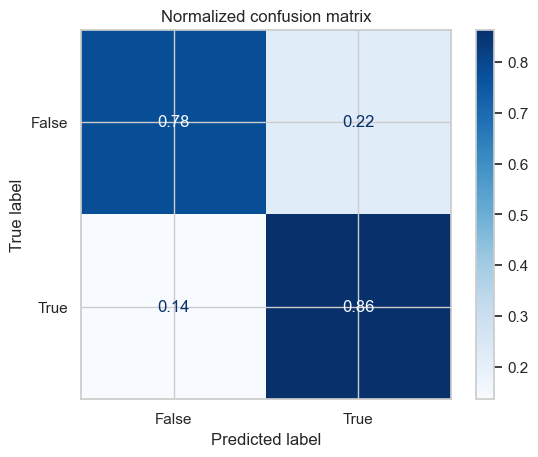



Fitting : Stochastic Gradient Descent

Bagging with Stochastic Gradient Descent - best params: {'n_estimators': 50}
Time Evaluating Bagging with Stochastic Gradient Descent: 81.4260196685791

Perfomance:
Accuracy: 0.8218594748048261
Classification Report:
              precision    recall  f1-score   support

       False       0.85      0.92      0.88      1035
        True       0.72      0.54      0.62       374

    accuracy                           0.82      1409
   macro avg       0.78      0.73      0.75      1409
weighted avg       0.81      0.82      0.81      1409

ROC AUC Score:
0.8800382340024285


Confusion matrix, without normalization
[[956  79]
 [172 202]]


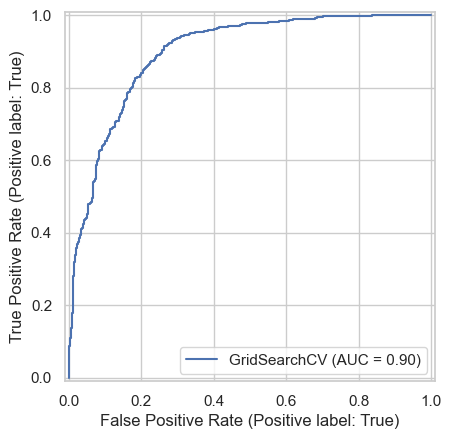

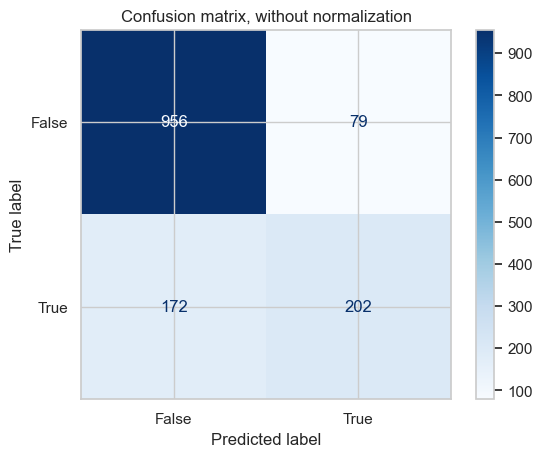



Normalized confusion matrix
[[0.9236715  0.0763285 ]
 [0.45989305 0.54010695]]


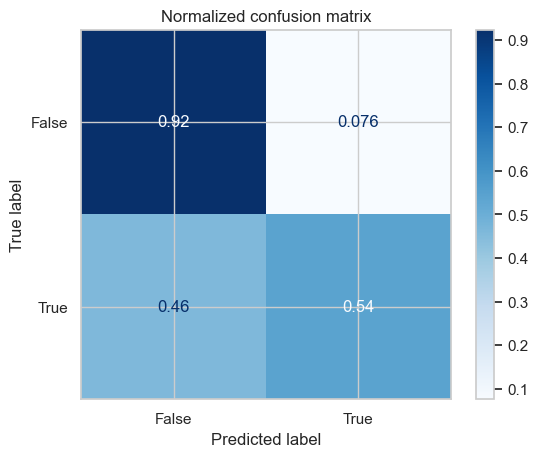



Processing Time: 262.42309284210205


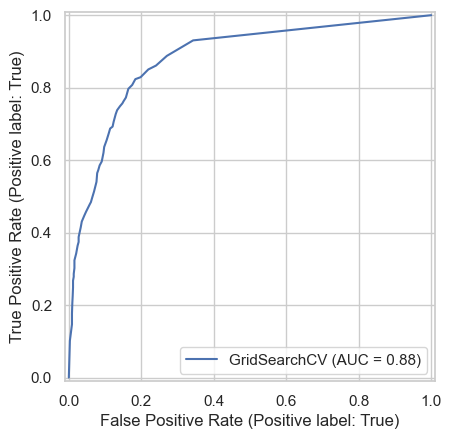

In [400]:
full_start = time()
for name, estimator in estimators_dict.items():
  columns = grids_cv[model_name].best_estimator_.steps[0][1].get_feature_names_out()  

  bagging_params_scaled = {  
    'n_estimators': [10, 20, 50, 70, 100, 150, 200]    
  }
  bagging_grid_search = GridSearchCV(BaggingClassifier(estimator=estimator, random_state=random_state), bagging_params_scaled, n_jobs=-1, cv=StratifiedKFold(5))  
  print('Fitting : ' + name)
  start = time()
  bagging_grid_search.fit(X_train_norm[columns], y_train)
  end = time()
  print(f'\nBagging with {name} - best params: {bagging_grid_search.best_params_}')
  print(f'Time Evaluating Bagging with {name}: {end-start}\n') 

  y_pred_ada = bagging_grid_search.predict(X_test_norm[columns])
  bagging_accuracy[name] = accuracy_score(y_test, y_pred_ada)
  bagging_f1_score[name] = f1_score(y_test, y_pred_ada, pos_label=1)
  bagging_roc_auc[name] = roc_auc_score(y_test, bagging_grid_search.predict_proba(X_test_norm[columns])[:, 1])

  show_metrics(bagging_grid_search, X_test_norm[columns])



full_end = time()
print(f'Processing Time: {full_end-full_start}')


Bagging accuracy  Bagging f1-score  \
Decision Tree                        0.805536          0.698901   
Logistic Regression                  0.801987          0.698378   
Stochastic Gradient Descent          0.821859          0.616794   

                             Bagging roc_auc  
Decision Tree                       0.895808  
Logistic Regression                 0.897143  
Stochastic Gradient Descent         0.880038

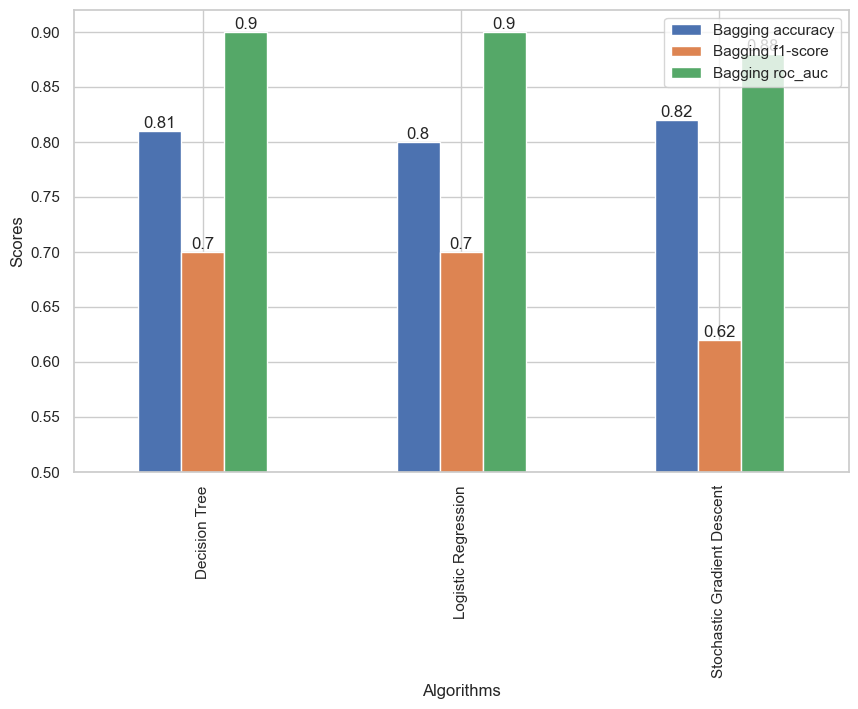

In [401]:
bagging_scores = pd.DataFrame({'Bagging accuracy': bagging_accuracy,
                               'Bagging f1-score': bagging_f1_score,
                               'Bagging roc_auc': bagging_roc_auc}, index=bagging_accuracy.keys())


display(bagging_scores)
ax = bagging_scores.map(lambda x: round(x, 2)).plot(kind='bar', figsize=(10, 6))
plt.ylim(0.50, 0.92)
plt.xlabel('Algorithms')
plt.ylabel('Scores')

for container in ax.containers:
  ax.bar_label(container)

In [452]:
gboosting_params = {
  'estimator' : [DecisionTreeClassifier(random_state=random_state), GaussianNB()],
  'n_estimators': [20, 40]
}

columns = grids_cv['Decision Tree'].best_estimator_.steps[0][1].get_feature_names_out()  

simple_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=random_state), gboosting_params, n_jobs=-1, cv=StratifiedKFold(5))
simple_grid_search.fit(X_train_norm[columns], y_train)
print(simple_grid_search.best_params_)

show_metrics(simple_grid_search, X_test_norm[columns])

{'estimator': DecisionTreeClassifier(random_state=42), 'n_estimators': 100}
Best parameters for estimator: {'estimator': DecisionTreeClassifier(random_state=42), 'n_estimators': 100}
XGBoost Perfomance:
Accuracy: 0.8232789212207239
Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.89      0.88      1035
         Yes       0.68      0.63      0.66       374

    accuracy                           0.82      1409
   macro avg       0.77      0.76      0.77      1409
weighted avg       0.82      0.82      0.82      1409

ROC AUC Score:
0.8827662817432639




## Training the best estimator on the whole dataset

Perfomance:
Accuracy: 0.836007383217379
Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.91      0.89      5174
         Yes       0.72      0.62      0.67      1869

    accuracy                           0.84      7043
   macro avg       0.80      0.77      0.78      7043
weighted avg       0.83      0.84      0.83      7043

ROC AUC Score:
0.8972252504238275


Confusion matrix, without normalization
[[4728  446]
 [ 709 1160]]


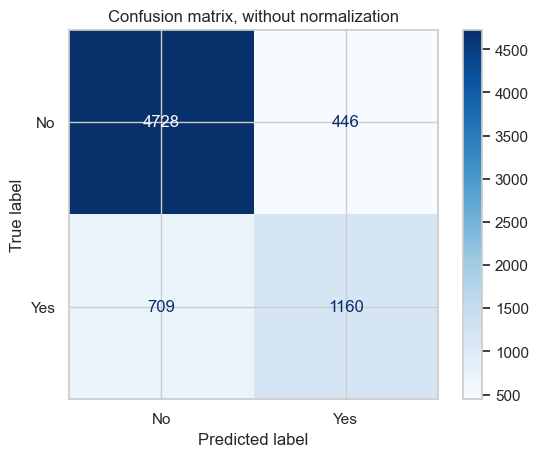



Normalized confusion matrix
[[0.91379977 0.08620023]
 [0.37934724 0.62065276]]


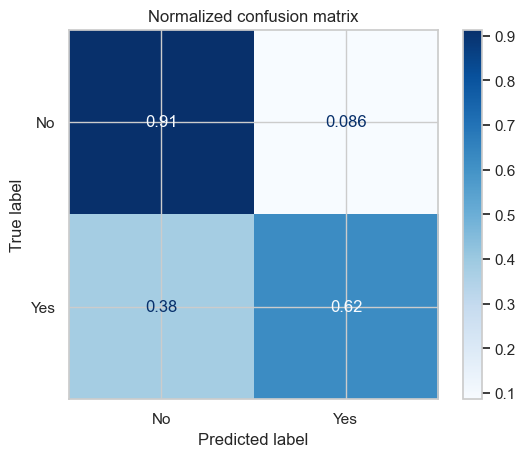

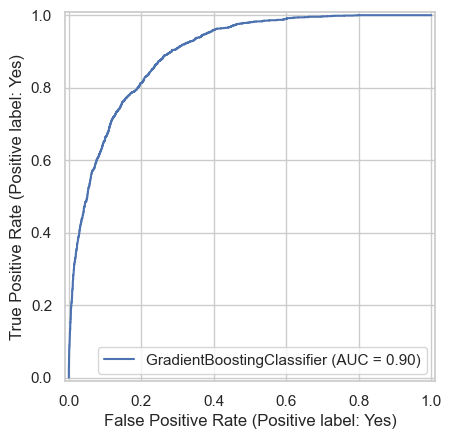

In [542]:
best_gboosting_params = search_cv['Gradient Boosting'].best_estimator_.get_params()
best_gradient_boosting = GradientBoostingClassifier(random_state=random_state)
best_gradient_boosting.set_params(**best_gboosting_params)
best_gradient_boosting.fit(X, y)
best_y_pred = best_gradient_boosting.predict(X)

print("Perfomance:")
print("Accuracy:", accuracy_score(y, best_y_pred))
print("Classification Report:")
print(classification_report(y, best_y_pred, zero_division=0.0))
print("ROC AUC Score:")
print(roc_auc_score(y, best_gradient_boosting.predict_proba(X)[:, 1]))
print("\n")

# Plot confusion matrix
plot_confusion_matrix(best_gradient_boosting, X, y)

# Plot ROC Curve
RocCurveDisplay.from_estimator(best_gradient_boosting, X, y)



## Feature Importance For best estimators

In [547]:
gbc_feat_importance = pd.DataFrame({'features': best_gradient_boosting.feature_names_in_, 'importance': best_gradient_boosting.feature_importances_})
print(gbc_feat_importance.sort_values(by='importance', ascending=False).to_string())

                                    features  importance
17                          Tenure in Months    0.231299
32                        Online Security_No    0.192264
16                       Number of Referrals    0.170824
50           Payment Method_Electronic check    0.084426
6                            Monthly Charges    0.048819
10                      Number of Dependents    0.048628
3                                     Tenure    0.038551
62                 Internet Type_No Internet    0.035929
45                   Contract_Month-to-month    0.024660
21                      Premium Tech Support    0.012715
38                           Tech Support_No    0.011980
9                                    Married    0.011104
0                             Senior Citizen    0.010027
60                         Internet Type_DSL    0.009154
5                          Paperless Billing    0.008648
24                             Total Charges    0.008567
11                             

In [ ]:
best_bag = BaggingClassifier(estimator=LogisticRegression(C=10, penalty="l2", solver="liblinear"), n_estimators=200, random_state=random_state)
best_bag.fit(X, y)
bag_y_pred = best_bag.predict(X)

print("Perfomance:")
print("Accuracy:", accuracy_score(y, bag_y_pred))
print("Classification Report:")
print(classification_report(y, bag_y_pred, zero_division=0.0))
print("ROC AUC Score:")
print(roc_auc_score(y, best_bag.predict_proba(X)[:, 1]))
print("\n")

# Plot confusion matrix
plot_confusion_matrix(best_bag, X, y)

# Plot ROC Curve
RocCurveDisplay.from_estimator(best_bag, X, y)



In [14]:
print(pd.DataFrame({'feature': best_bag.feature_names_in_, 'coef' :best_bag.estimators_[1].coef_[0]}).sort_values(by='coef', ascending=False).to_string())

                                     feature          coef
15                         Referred a Friend  5.875671e-01
9                                    Married  5.039799e-01
1                                    Partner  5.039799e-01
64                            City_San Diego  3.751644e-01
45                   Contract_Month-to-month  3.458394e-01
5                          Paperless Billing  3.082713e-01
2                                 Dependents  2.699336e-01
50           Payment Method_Electronic check  2.444853e-01
32                        Online Security_No  2.179008e-01
30           Multiple Lines_No phone service  1.823556e-01
38                           Tech Support_No  1.740089e-01
58                             Offer_Offer E  1.385593e-01
34                          Online Backup_No  1.158413e-01
59                       Internet Type_Cable  1.112276e-01
55                             Offer_Offer B  8.223664e-02
22                           Streaming Music  7.932081e-